In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/PRUEBA A.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=125.5, y1=121.6
Page 1, Q1, A: Yellow pixels: 335
Page 1, Q1, A: Total non-white pixels: 548
Page 1, Q1, A: Yellow percentage: 61.1%


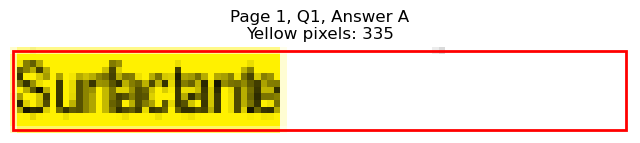

Page 1, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=120.2, y1=133.6
Page 1, Q1, B: Yellow pixels: 40
Page 1, Q1, B: Total non-white pixels: 285
Page 1, Q1, B: Yellow percentage: 14.0%


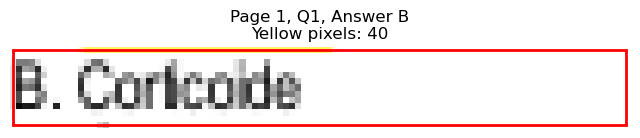

Page 1, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=130.7, y1=145.6
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 274
Page 1, Q1, C: Yellow percentage: 0.0%


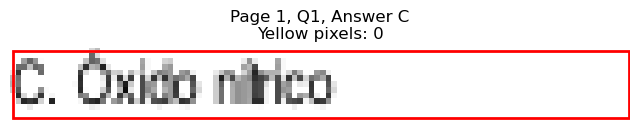

Page 1, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=367.3, y1=121.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 242
Page 1, Q1, D: Yellow percentage: 0.0%


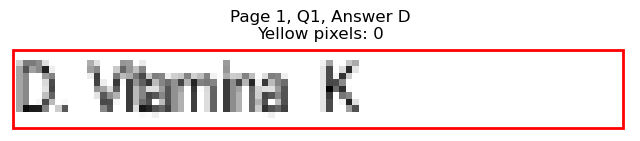

Page 1, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=377.0, y1=133.6
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 268
Page 1, Q1, E: Yellow percentage: 0.0%


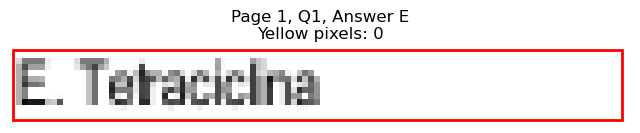


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=123.2, y1=181.6
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 240
Page 1, Q2, A: Yellow percentage: 0.0%


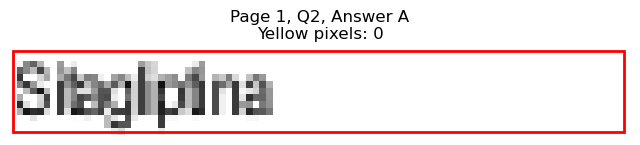

Page 1, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=125.5, y1=193.6
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 271
Page 1, Q2, B: Yellow percentage: 0.0%


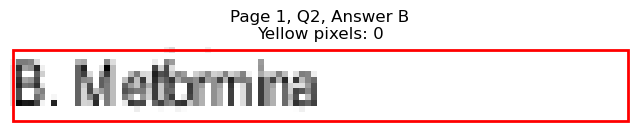

Page 1, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=126.2, y1=205.6
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 273
Page 1, Q2, C: Yellow percentage: 0.0%


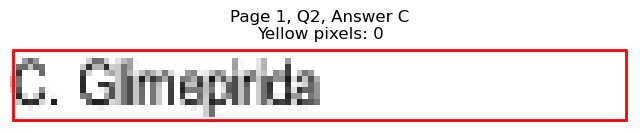

Page 1, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=380.0, y1=181.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 299
Page 1, Q2, D: Yellow percentage: 0.0%


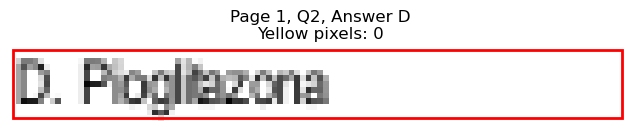

Page 1, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=388.4, y1=193.6
Page 1, Q2, E: Yellow pixels: 471
Page 1, Q2, E: Total non-white pixels: 832
Page 1, Q2, E: Yellow percentage: 56.6%


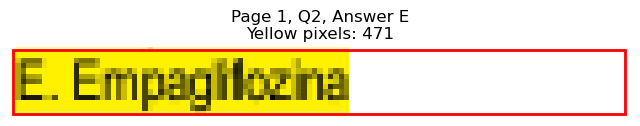


Page 1, Q2 - Selected Answer: E (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=142.0, y1=265.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 289
Page 1, Q3, A: Yellow percentage: 0.0%


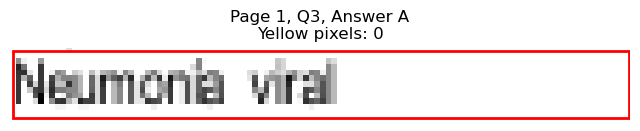

Page 1, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=154.7, y1=277.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 407
Page 1, Q3, B: Yellow percentage: 0.0%


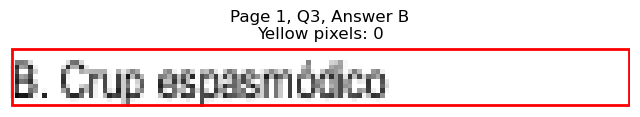

Page 1, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=130.0, y1=289.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 273
Page 1, Q3, C: Yellow percentage: 0.0%


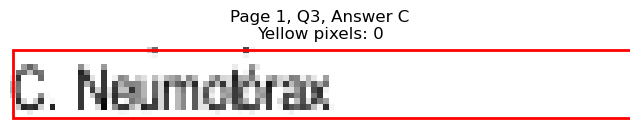

Page 1, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=393.5, y1=265.7
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 343
Page 1, Q3, D: Yellow percentage: 0.0%


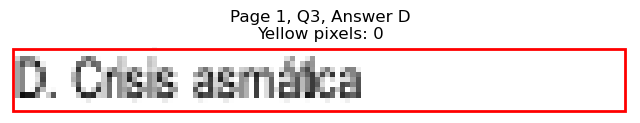

Page 1, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=393.6, y1=277.7
Page 1, Q3, E: Yellow pixels: 543
Page 1, Q3, E: Total non-white pixels: 910
Page 1, Q3, E: Yellow percentage: 59.7%


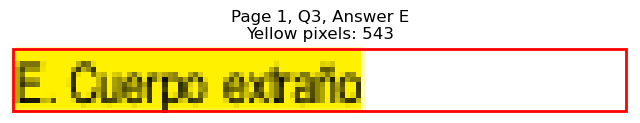


Page 1, Q3 - Selected Answer: E (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=94.0, y1=326.5
Page 1, Q4, A: Yellow pixels: 74
Page 1, Q4, A: Total non-white pixels: 130
Page 1, Q4, A: Yellow percentage: 56.9%


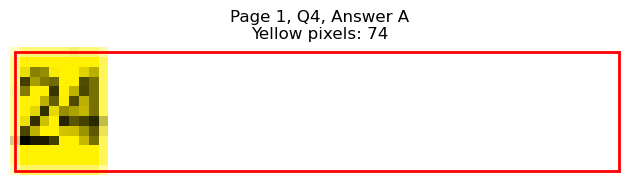

Page 1, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=93.2, y1=338.5
Page 1, Q4, B: Yellow pixels: 8
Page 1, Q4, B: Total non-white pixels: 93
Page 1, Q4, B: Yellow percentage: 8.6%


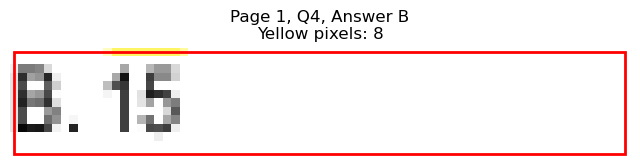

Page 1, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=94.0, y1=350.5
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 80
Page 1, Q4, C: Yellow percentage: 0.0%


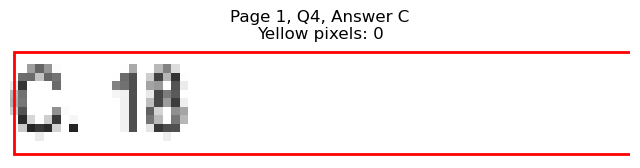

Page 1, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=345.5, y1=326.5
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 83
Page 1, Q4, D: Yellow percentage: 0.0%


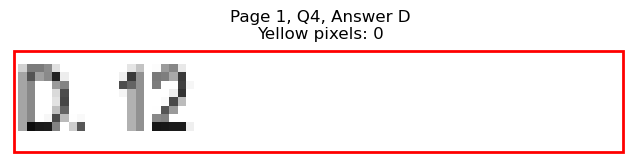

Page 1, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=344.8, y1=338.5
Page 1, Q4, E: Yellow pixels: 0
Page 1, Q4, E: Total non-white pixels: 93
Page 1, Q4, E: Yellow percentage: 0.0%


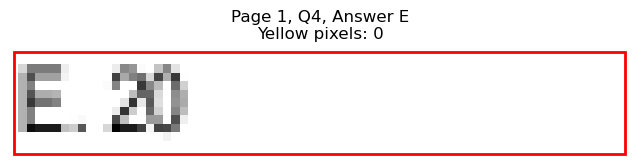


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=188.4, y1=422.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 502
Page 1, Q5, A: Yellow percentage: 0.0%


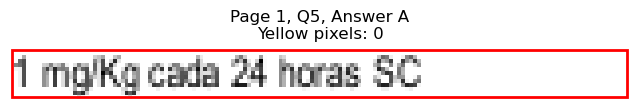

Page 1, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=186.9, y1=434.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 522
Page 1, Q5, B: Yellow percentage: 0.0%


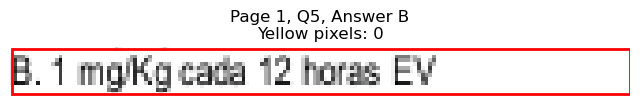

Page 1, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=187.7, y1=446.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 518
Page 1, Q5, C: Yellow percentage: 0.0%


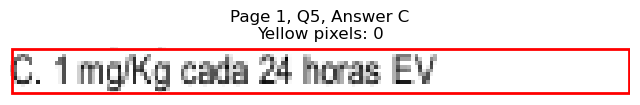

Page 1, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=440.2, y1=422.6
Page 1, Q5, D: Yellow pixels: 956
Page 1, Q5, D: Total non-white pixels: 1508
Page 1, Q5, D: Yellow percentage: 63.4%


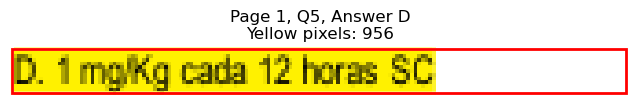

Page 1, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=438.6, y1=434.6
Page 1, Q5, E: Yellow pixels: 115
Page 1, Q5, E: Total non-white pixels: 639
Page 1, Q5, E: Yellow percentage: 18.0%


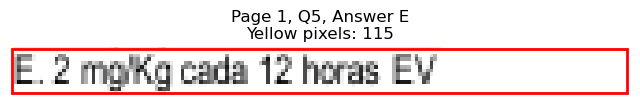


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.6, y0=483.4, x1=153.2, y1=495.4
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 366
Page 1, Q6, A: Yellow percentage: 0.0%


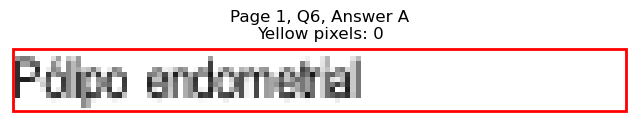

Page 1, Q6 - B: Detected box: x0=71.3, y0=495.4, x1=129.2, y1=507.4
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 290
Page 1, Q6, B: Yellow percentage: 0.0%


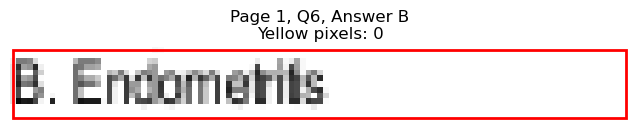

Page 1, Q6 - C: Detected box: x0=71.3, y0=507.4, x1=172.0, y1=519.4
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 504
Page 1, Q6, C: Yellow percentage: 0.0%


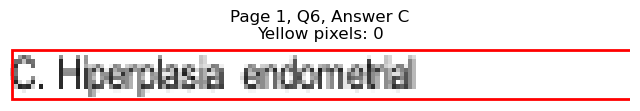

Page 1, Q6 - D: Detected box: x0=322.9, y0=483.4, x1=397.4, y1=495.4
Page 1, Q6, D: Yellow pixels: 635
Page 1, Q6, D: Total non-white pixels: 949
Page 1, Q6, D: Yellow percentage: 66.9%


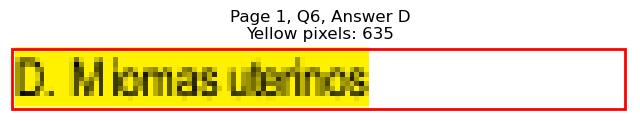

Page 1, Q6 - E: Detected box: x0=322.9, y0=495.4, x1=424.2, y1=507.4
Page 1, Q6, E: Yellow pixels: 72
Page 1, Q6, E: Total non-white pixels: 552
Page 1, Q6, E: Yellow percentage: 13.0%


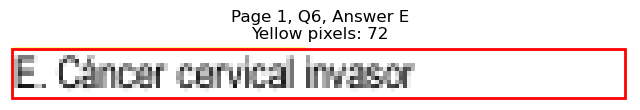


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.6, y0=579.4, x1=250.0, y1=591.5
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 813
Page 1, Q7, A: Yellow percentage: 0.0%


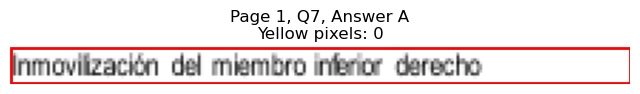

Page 1, Q7 - B: Detected box: x0=71.3, y0=591.5, x1=198.3, y1=603.5
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 606
Page 1, Q7, B: Yellow percentage: 0.0%


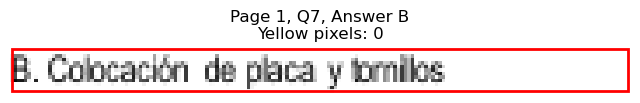

Page 1, Q7 - C: Detected box: x0=71.3, y0=603.5, x1=143.5, y1=615.5
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 349
Page 1, Q7, C: Yellow percentage: 0.0%


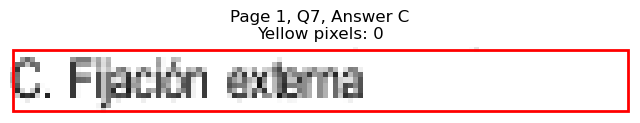

Page 1, Q7 - D: Detected box: x0=322.9, y0=579.4, x1=454.5, y1=591.5
Page 1, Q7, D: Yellow pixels: 1162
Page 1, Q7, D: Total non-white pixels: 1703
Page 1, Q7, D: Yellow percentage: 68.2%


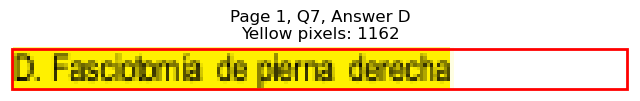

Page 1, Q7 - E: Detected box: x0=322.9, y0=591.5, x1=452.0, y1=603.5
Page 1, Q7, E: Yellow pixels: 129
Page 1, Q7, E: Total non-white pixels: 755
Page 1, Q7, E: Yellow percentage: 17.1%


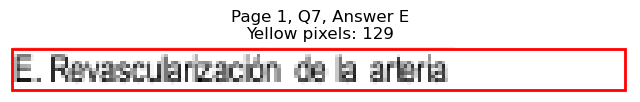


Page 1, Q7 - Selected Answer: D (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.6, y0=639.5, x1=176.6, y1=651.6
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 483
Page 1, Q8, A: Yellow percentage: 0.0%


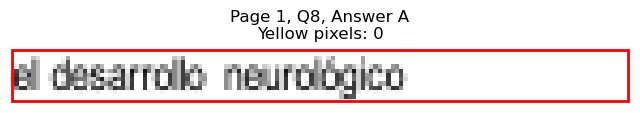

Page 1, Q8 - B: Detected box: x0=71.3, y0=651.5, x1=121.8, y1=663.6
Page 1, Q8, B: Yellow pixels: 418
Page 1, Q8, B: Total non-white pixels: 639
Page 1, Q8, B: Yellow percentage: 65.4%


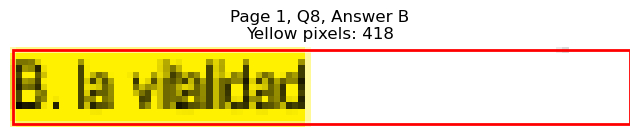

Page 1, Q8 - C: Detected box: x0=71.3, y0=663.5, x1=189.2, y1=675.6
Page 1, Q8, C: Yellow pixels: 48
Page 1, Q8, C: Total non-white pixels: 601
Page 1, Q8, C: Yellow percentage: 8.0%


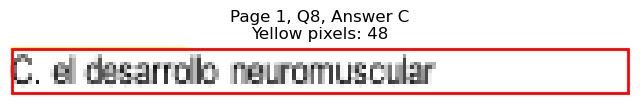

Page 1, Q8 - D: Detected box: x0=322.9, y0=639.5, x1=407.8, y1=651.6
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 425
Page 1, Q8, D: Yellow percentage: 0.0%


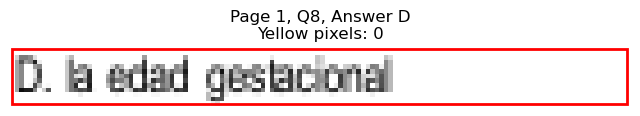

Page 1, Q8 - E: Detected box: x0=322.9, y0=651.5, x1=411.5, y1=663.6
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 693
Page 1, Q8, E: Yellow percentage: 0.0%


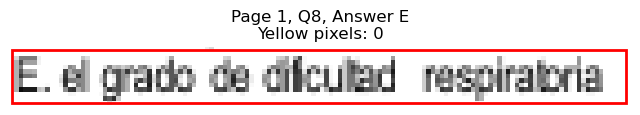


Page 1, Q8 - Selected Answer: B (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=171.2, y1=712.3
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 576
Page 1, Q9, A: Yellow percentage: 0.0%


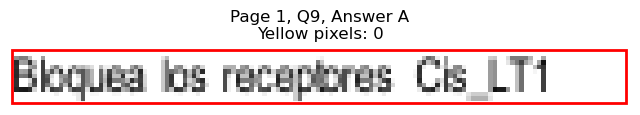

Page 1, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=242.4, y1=724.4
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 825
Page 1, Q9, B: Yellow percentage: 0.0%


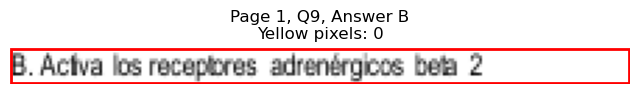

Page 1, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=236.7, y1=736.4
Page 1, Q9, C: Yellow pixels: 1323
Page 1, Q9, C: Total non-white pixels: 2132
Page 1, Q9, C: Yellow percentage: 62.1%


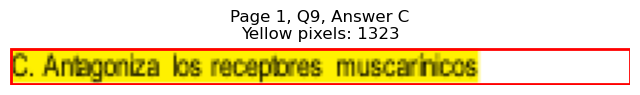

Page 1, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=506.0, y1=712.3
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 897
Page 1, Q9, D: Yellow percentage: 0.0%


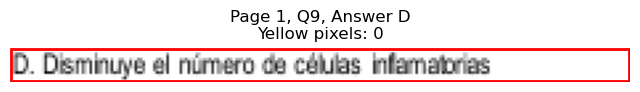

Page 1, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=425.8, y1=724.4
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 761
Page 1, Q9, E: Yellow percentage: 0.0%


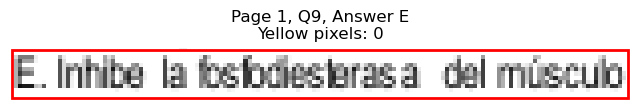


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=154.0, y1=133.6
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 370
Page 2, Q1, A: Yellow percentage: 0.0%


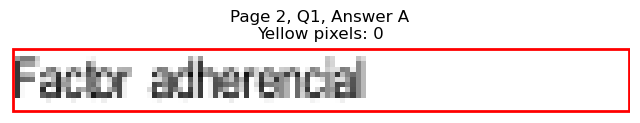

Page 2, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=203.6, y1=145.6
Page 2, Q1, B: Yellow pixels: 981
Page 2, Q1, B: Total non-white pixels: 1703
Page 2, Q1, B: Yellow percentage: 57.6%


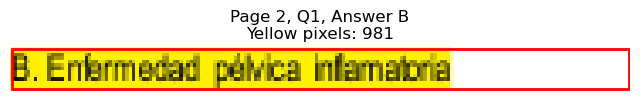

Page 2, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=154.7, y1=157.6
Page 2, Q1, C: Yellow pixels: 130
Page 2, Q1, C: Total non-white pixels: 539
Page 2, Q1, C: Yellow percentage: 24.1%


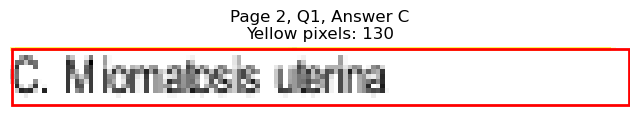

Page 2, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=428.0, y1=133.6
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 518
Page 2, Q1, D: Yellow percentage: 0.0%


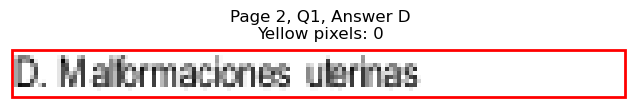

Page 2, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=376.3, y1=145.6
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 511
Page 2, Q1, E: Yellow percentage: 0.0%


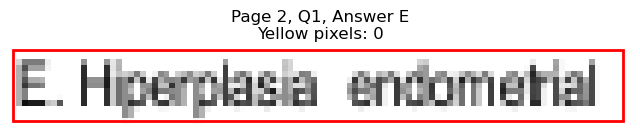


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=139.0, y1=205.6
Page 2, Q2, A: Yellow pixels: 831
Page 2, Q2, A: Total non-white pixels: 1391
Page 2, Q2, A: Yellow percentage: 59.7%


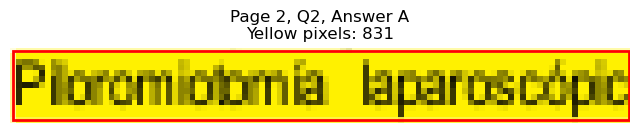

Page 2, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=138.2, y1=217.7
Page 2, Q2, B: Yellow pixels: 106
Page 2, Q2, B: Total non-white pixels: 457
Page 2, Q2, B: Yellow percentage: 23.2%


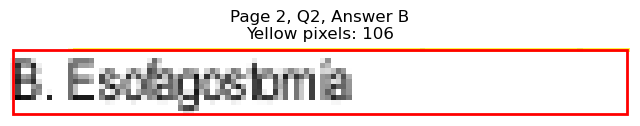

Page 2, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=141.2, y1=229.7
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 580
Page 2, Q2, C: Yellow percentage: 0.0%


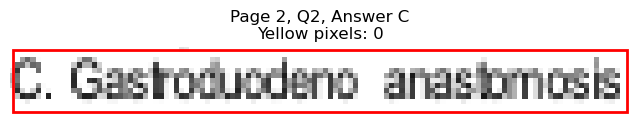

Page 2, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=385.3, y1=205.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 420
Page 2, Q2, D: Yellow percentage: 0.0%


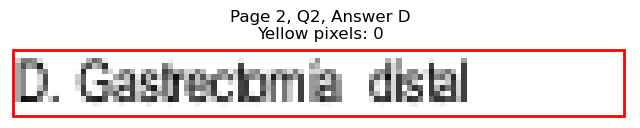

Page 2, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=384.5, y1=217.7
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 304
Page 2, Q2, E: Yellow percentage: 0.0%


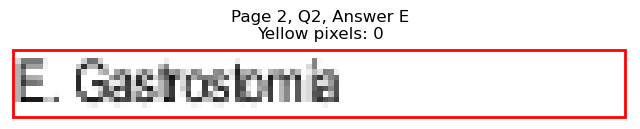


Page 2, Q2 - Selected Answer: A (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.6, y0=289.7, x1=119.5, y1=301.8
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 184
Page 2, Q3, A: Yellow percentage: 0.0%


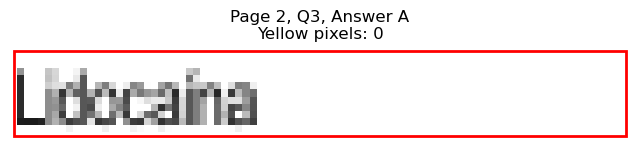

Page 2, Q3 - B: Detected box: x0=71.3, y0=302.5, x1=123.2, y1=314.5
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 254
Page 2, Q3, B: Yellow percentage: 0.0%


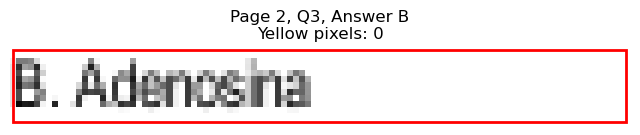

Page 2, Q3 - C: Detected box: x0=71.3, y0=314.5, x1=116.5, y1=326.5
Page 2, Q3, C: Yellow pixels: 390
Page 2, Q3, C: Total non-white pixels: 572
Page 2, Q3, C: Yellow percentage: 68.2%


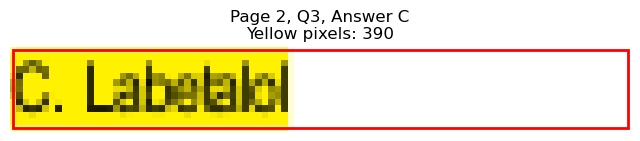

Page 2, Q3 - D: Detected box: x0=322.9, y0=289.7, x1=383.0, y1=301.8
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 298
Page 2, Q3, D: Yellow percentage: 0.0%


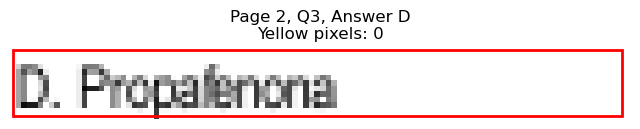

Page 2, Q3 - E: Detected box: x0=322.9, y0=302.5, x1=367.3, y1=314.5
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 212
Page 2, Q3, E: Yellow percentage: 0.0%


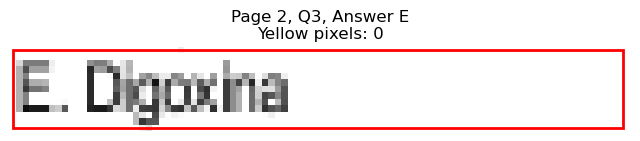


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.6, y0=362.5, x1=121.8, y1=374.6
Page 2, Q4, A: Yellow pixels: 283
Page 2, Q4, A: Total non-white pixels: 494
Page 2, Q4, A: Yellow percentage: 57.3%


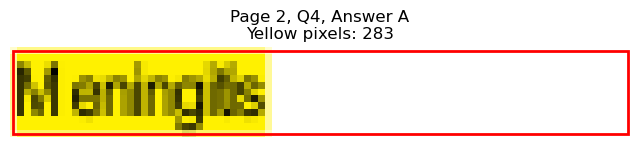

Page 2, Q4 - B: Detected box: x0=71.3, y0=374.5, x1=166.0, y1=386.6
Page 2, Q4, B: Yellow pixels: 36
Page 2, Q4, B: Total non-white pixels: 532
Page 2, Q4, B: Yellow percentage: 6.8%


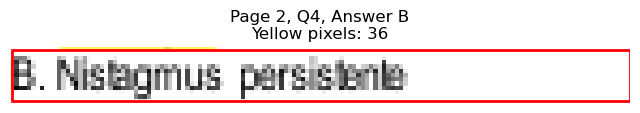

Page 2, Q4 - C: Detected box: x0=71.3, y0=386.5, x1=115.0, y1=398.6
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 198
Page 2, Q4, C: Yellow percentage: 0.0%


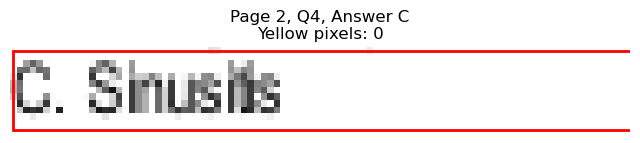

Page 2, Q4 - D: Detected box: x0=322.9, y0=362.5, x1=398.8, y1=374.6
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 370
Page 2, Q4, D: Yellow percentage: 0.0%


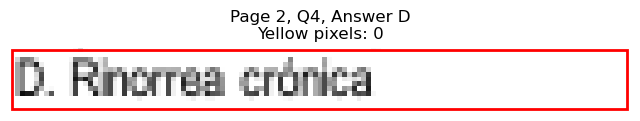

Page 2, Q4 - E: Detected box: x0=322.9, y0=374.5, x1=404.7, y1=386.6
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 384
Page 2, Q4, E: Yellow percentage: 0.0%


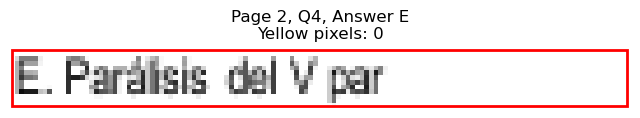


Page 2, Q4 - Selected Answer: A (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=153.1, y0=446.6, x1=238.2, y1=458.6
Page 2, Q5, A: Yellow pixels: 666
Page 2, Q5, A: Total non-white pixels: 1079
Page 2, Q5, A: Yellow percentage: 61.7%


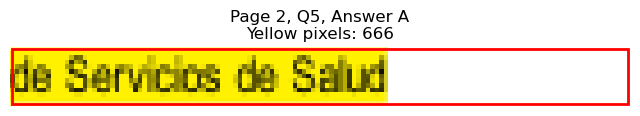

Page 2, Q5 - B: Detected box: x0=71.3, y0=458.6, x1=218.5, y1=470.6
Page 2, Q5, B: Yellow pixels: 153
Page 2, Q5, B: Total non-white pixels: 867
Page 2, Q5, B: Yellow percentage: 17.6%


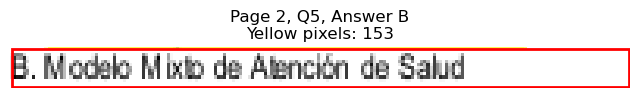

Page 2, Q5 - C: Detected box: x0=71.3, y0=470.6, x1=169.8, y1=482.6
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 692
Page 2, Q5, C: Yellow percentage: 0.0%


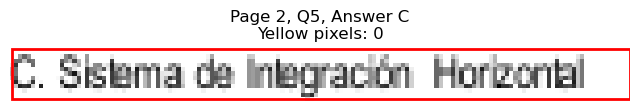

Page 2, Q5 - D: Detected box: x0=322.9, y0=446.6, x1=440.8, y1=458.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 760
Page 2, Q5, D: Yellow percentage: 0.0%


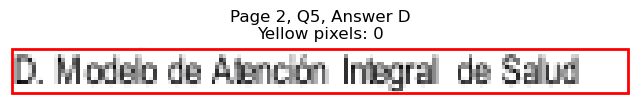

Page 2, Q5 - E: Detected box: x0=322.9, y0=458.6, x1=475.2, y1=470.6
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 737
Page 2, Q5, E: Yellow percentage: 0.0%


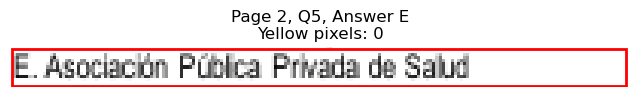


Page 2, Q5 - Selected Answer: A (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=129.9, y0=507.4, x1=235.2, y1=519.4
Page 2, Q6, A: Yellow pixels: 956
Page 2, Q6, A: Total non-white pixels: 1352
Page 2, Q6, A: Yellow percentage: 70.7%


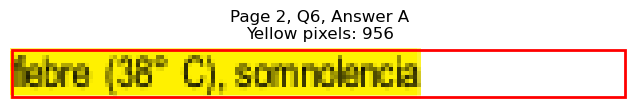

Page 2, Q6 - B: Detected box: x0=71.3, y0=519.4, x1=165.2, y1=531.4
Page 2, Q6, B: Yellow pixels: 133
Page 2, Q6, B: Total non-white pixels: 569
Page 2, Q6, B: Yellow percentage: 23.4%


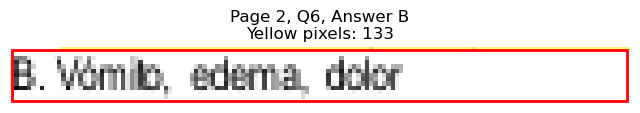

Page 2, Q6 - C: Detected box: x0=71.3, y0=531.4, x1=180.2, y1=543.5
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 496
Page 2, Q6, C: Yellow percentage: 0.0%


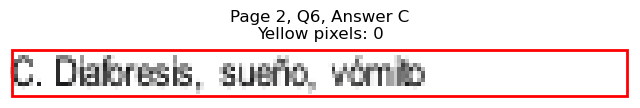

Page 2, Q6 - D: Detected box: x0=322.9, y0=507.4, x1=440.0, y1=519.4
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 546
Page 2, Q6, D: Yellow percentage: 0.0%


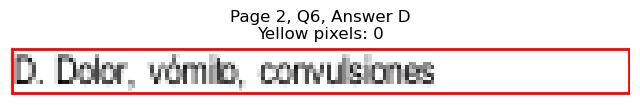

Page 2, Q6 - E: Detected box: x0=322.9, y0=519.4, x1=410.0, y1=531.4
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 583
Page 2, Q6, E: Yellow percentage: 0.0%


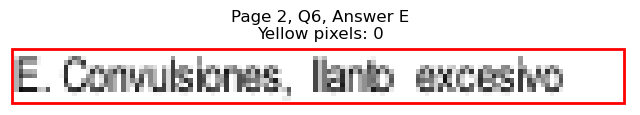


Page 2, Q6 - Selected Answer: A (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.6, y0=579.4, x1=127.8, y1=591.5
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 233
Page 2, Q7, A: Yellow percentage: 0.0%


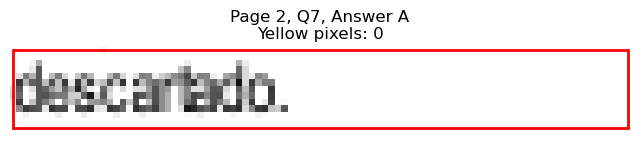

Page 2, Q7 - B: Detected box: x0=71.3, y0=591.5, x1=131.5, y1=603.5
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 290
Page 2, Q7, B: Yellow percentage: 0.0%


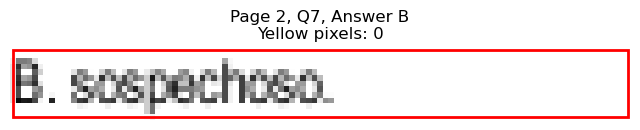

Page 2, Q7 - C: Detected box: x0=71.3, y0=603.5, x1=127.8, y1=615.5
Page 2, Q7, C: Yellow pixels: 499
Page 2, Q7, C: Total non-white pixels: 715
Page 2, Q7, C: Yellow percentage: 69.8%


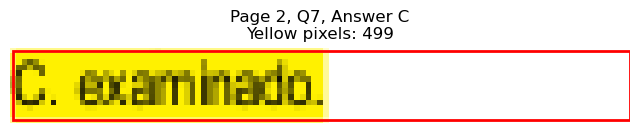

Page 2, Q7 - D: Detected box: x0=322.9, y0=579.4, x1=378.5, y1=591.5
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 279
Page 2, Q7, D: Yellow percentage: 0.0%


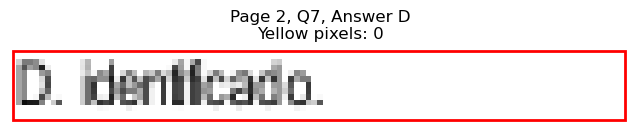

Page 2, Q7 - E: Detected box: x0=322.9, y0=591.5, x1=372.5, y1=603.5
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 245
Page 2, Q7, E: Yellow percentage: 0.0%


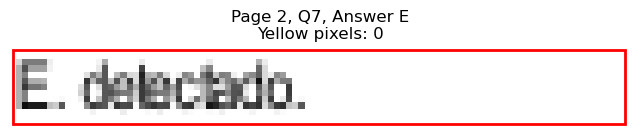


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.6, y0=651.5, x1=118.7, y1=663.6
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 190
Page 2, Q8, A: Yellow percentage: 0.0%


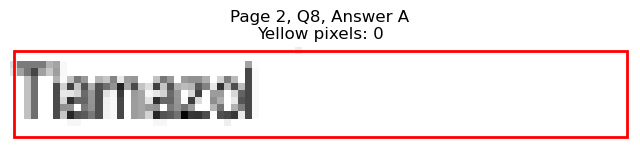

Page 2, Q8 - B: Detected box: x0=71.3, y0=663.5, x1=137.6, y1=675.6
Page 2, Q8, B: Yellow pixels: 495
Page 2, Q8, B: Total non-white pixels: 845
Page 2, Q8, B: Yellow percentage: 58.6%


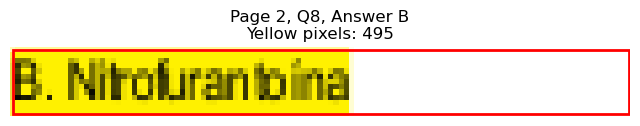

Page 2, Q8 - C: Detected box: x0=71.3, y0=676.3, x1=116.5, y1=688.3
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 270
Page 2, Q8, C: Yellow percentage: 0.0%


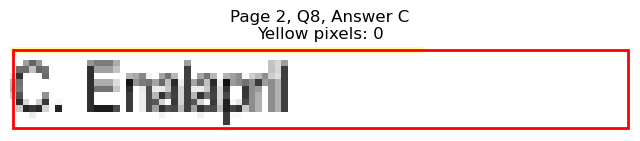

Page 2, Q8 - D: Detected box: x0=322.9, y0=651.5, x1=380.8, y1=663.6
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 281
Page 2, Q8, D: Yellow percentage: 0.0%


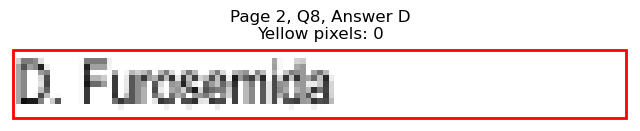

Page 2, Q8 - E: Detected box: x0=322.9, y0=663.5, x1=379.3, y1=675.6
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 256
Page 2, Q8, E: Yellow percentage: 0.0%


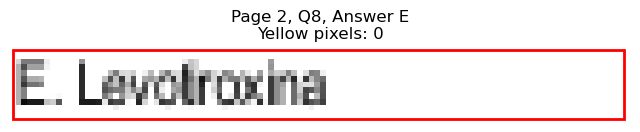


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.6, y0=712.3, x1=142.1, y1=724.4
Page 2, Q9, A: Yellow pixels: 450
Page 2, Q9, A: Total non-white pixels: 754
Page 2, Q9, A: Yellow percentage: 59.7%


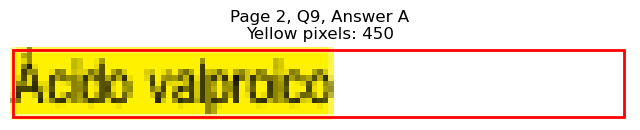

Page 2, Q9 - B: Detected box: x0=71.3, y0=724.3, x1=130.0, y1=736.4
Page 2, Q9, B: Yellow pixels: 1
Page 2, Q9, B: Total non-white pixels: 373
Page 2, Q9, B: Yellow percentage: 0.3%


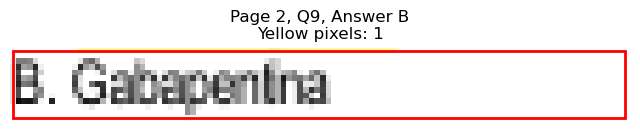

Page 2, Q9 - C: Detected box: x0=71.3, y0=736.4, x1=117.3, y1=748.4
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 215
Page 2, Q9, C: Yellow percentage: 0.0%


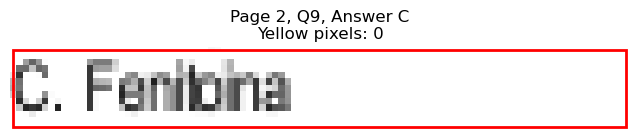

Page 2, Q9 - D: Detected box: x0=322.9, y0=712.3, x1=395.0, y1=724.4
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 368
Page 2, Q9, D: Yellow percentage: 0.0%


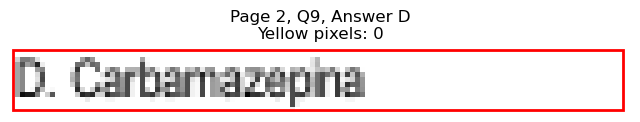

Page 2, Q9 - E: Detected box: x0=322.9, y0=724.3, x1=378.1, y1=736.4
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 295
Page 2, Q9, E: Yellow percentage: 0.0%


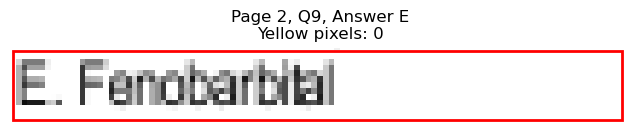


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=106.0, y1=121.6
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 101
Page 3, Q1, A: Yellow percentage: 0.0%


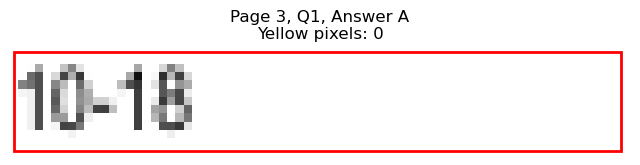

Page 3, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=105.3, y1=133.6
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 154
Page 3, Q1, B: Yellow percentage: 0.0%


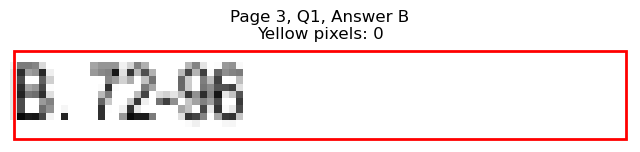

Page 3, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=106.0, y1=145.6
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 141
Page 3, Q1, C: Yellow percentage: 0.0%


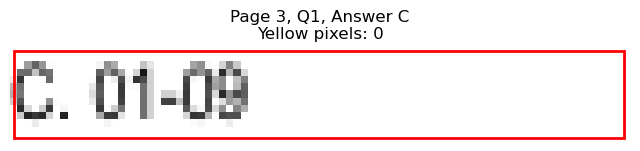

Page 3, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=357.6, y1=121.6
Page 3, Q1, D: Yellow pixels: 296
Page 3, Q1, D: Total non-white pixels: 445
Page 3, Q1, D: Yellow percentage: 66.5%


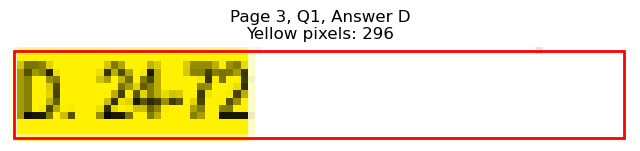

Page 3, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=356.8, y1=133.6
Page 3, Q1, E: Yellow pixels: 32
Page 3, Q1, E: Total non-white pixels: 180
Page 3, Q1, E: Yellow percentage: 17.8%


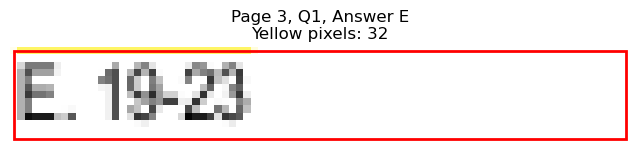


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=124.8, y1=181.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 228
Page 3, Q2, A: Yellow percentage: 0.0%


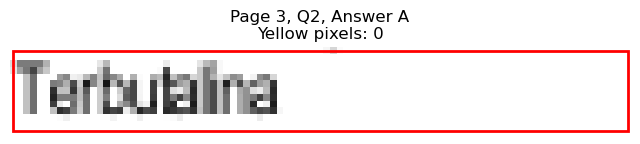

Page 3, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=115.7, y1=193.6
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 226
Page 3, Q2, B: Yellow percentage: 0.0%


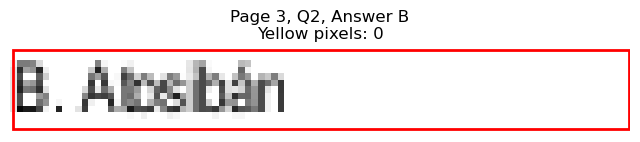

Page 3, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=134.5, y1=205.6
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 290
Page 3, Q2, C: Yellow percentage: 0.0%


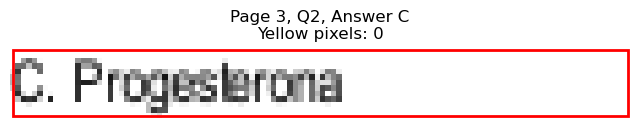

Page 3, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=370.4, y1=181.6
Page 3, Q2, D: Yellow pixels: 355
Page 3, Q2, D: Total non-white pixels: 600
Page 3, Q2, D: Yellow percentage: 59.2%


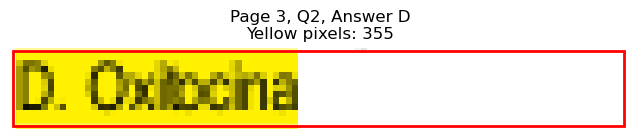

Page 3, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=389.8, y1=193.6
Page 3, Q2, E: Yellow pixels: 45
Page 3, Q2, E: Total non-white pixels: 374
Page 3, Q2, E: Yellow percentage: 12.0%


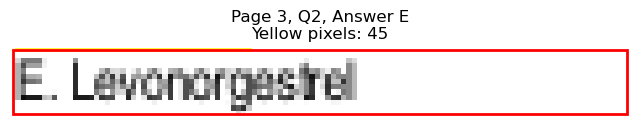


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=125.5, y1=253.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 229
Page 3, Q3, A: Yellow percentage: 0.0%


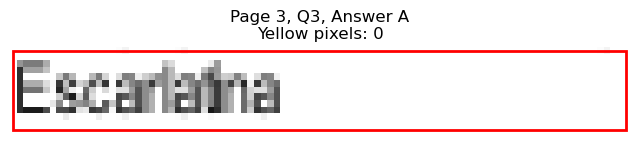

Page 3, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=114.3, y1=265.7
Page 3, Q3, B: Yellow pixels: 318
Page 3, Q3, B: Total non-white pixels: 533
Page 3, Q3, B: Yellow percentage: 59.7%


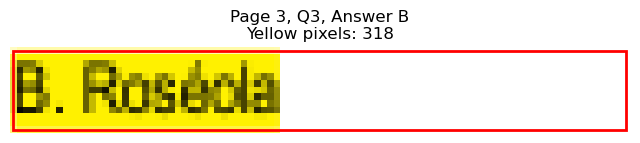

Page 3, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=125.5, y1=277.7
Page 3, Q3, C: Yellow pixels: 41
Page 3, Q3, C: Total non-white pixels: 293
Page 3, Q3, C: Yellow percentage: 14.0%


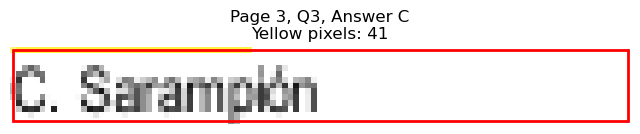

Page 3, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=404.0, y1=253.7
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 404
Page 3, Q3, D: Yellow percentage: 0.0%


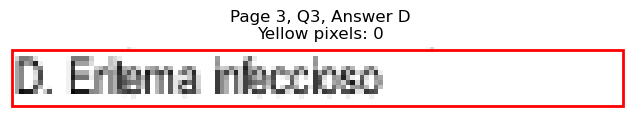

Page 3, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=365.8, y1=265.7
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 212
Page 3, Q3, E: Yellow percentage: 0.0%


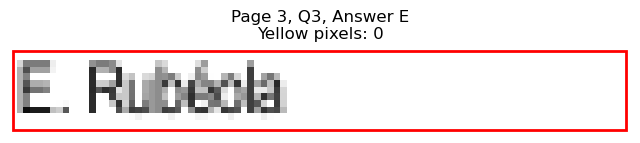


Page 3, Q3 - Selected Answer: B (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=106.0, y1=326.5
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 120
Page 3, Q4, A: Yellow percentage: 0.0%


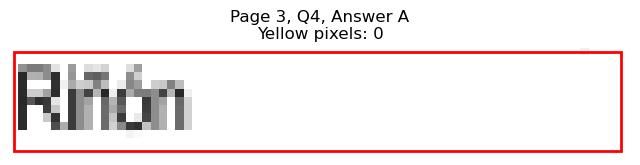

Page 3, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=106.0, y1=338.5
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 186
Page 3, Q4, B: Yellow percentage: 0.0%


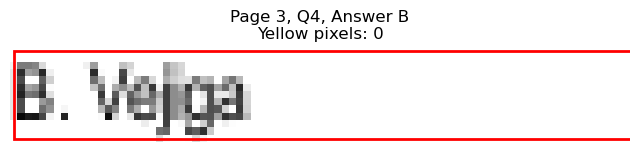

Page 3, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=115.0, y1=350.5
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 196
Page 3, Q4, C: Yellow percentage: 0.0%


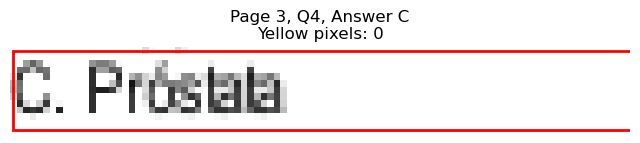

Page 3, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=359.1, y1=326.5
Page 3, Q4, D: Yellow pixels: 308
Page 3, Q4, D: Total non-white pixels: 455
Page 3, Q4, D: Yellow percentage: 67.7%


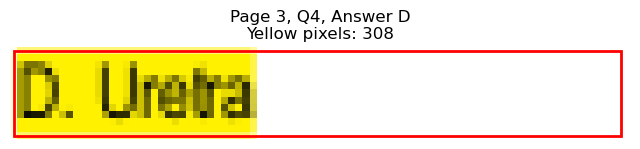

Page 3, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=358.3, y1=338.5
Page 3, Q4, E: Yellow pixels: 34
Page 3, Q4, E: Total non-white pixels: 194
Page 3, Q4, E: Yellow percentage: 17.5%


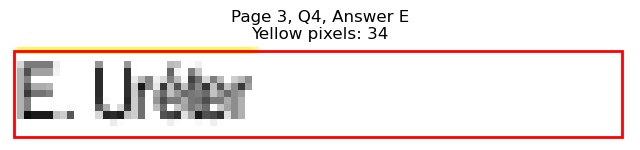


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=134.5, y1=398.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 475
Page 3, Q5, A: Yellow percentage: 0.0%


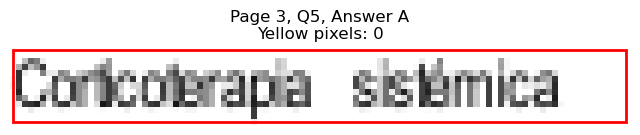

Page 3, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=142.7, y1=410.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 586
Page 3, Q5, B: Yellow percentage: 0.0%


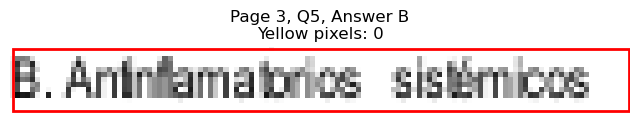

Page 3, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=176.5, y1=422.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 510
Page 3, Q5, C: Yellow percentage: 0.0%


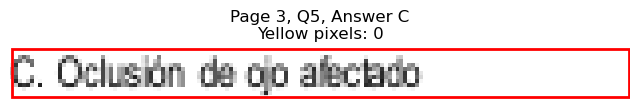

Page 3, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=410.8, y1=398.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 437
Page 3, Q5, D: Yellow percentage: 0.0%


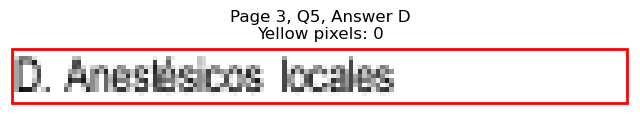

Page 3, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=434.9, y1=410.6
Page 3, Q5, E: Yellow pixels: 982
Page 3, Q5, E: Total non-white pixels: 1443
Page 3, Q5, E: Yellow percentage: 68.1%


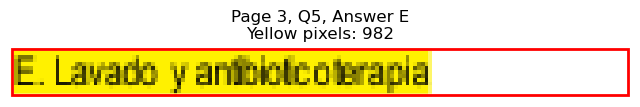


Page 3, Q5 - Selected Answer: E (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=71.3, y0=470.6, x1=79.7, y1=482.6
Page 3, Q6, A: Yellow pixels: 31
Page 3, Q6, A: Total non-white pixels: 112
Page 3, Q6, A: Yellow percentage: 27.7%


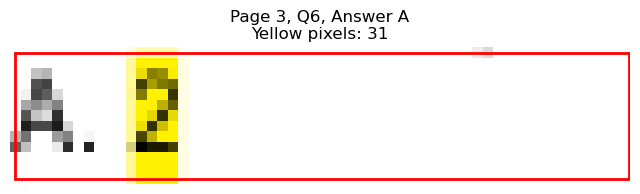

Page 3, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=88.7, y1=495.4
Page 3, Q6, B: Yellow pixels: 4
Page 3, Q6, B: Total non-white pixels: 77
Page 3, Q6, B: Yellow percentage: 5.2%


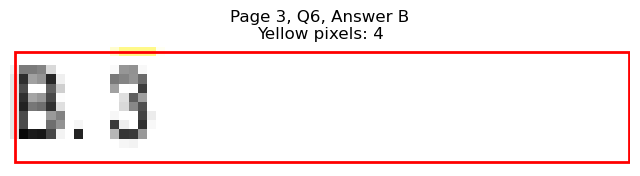

Page 3, Q6 - C: Detected box: x0=71.3, y0=495.4, x1=89.5, y1=507.4
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 57
Page 3, Q6, C: Yellow percentage: 0.0%


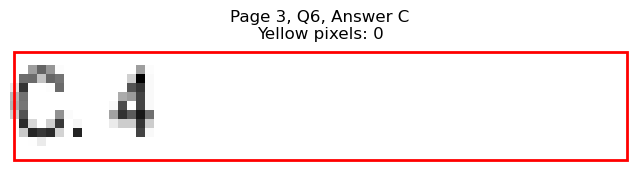

Page 3, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=341.0, y1=482.6
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 63
Page 3, Q6, D: Yellow percentage: 0.0%


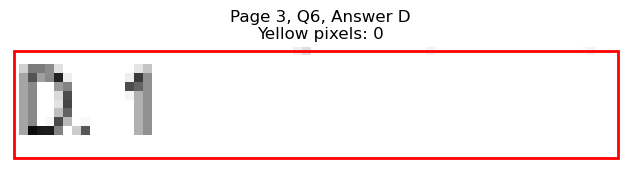

Page 3, Q6 - E: Detected box: x0=322.9, y0=483.4, x1=340.3, y1=495.4
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 64
Page 3, Q6, E: Yellow percentage: 0.0%


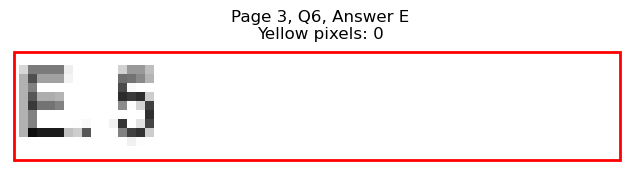


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.6, y0=531.4, x1=119.5, y1=543.5
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 195
Page 3, Q7, A: Yellow percentage: 0.0%


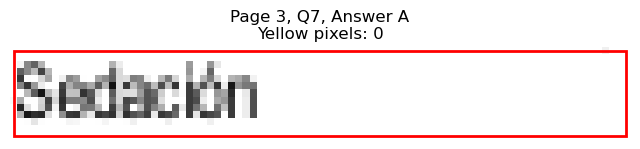

Page 3, Q7 - B: Detected box: x0=71.3, y0=543.4, x1=130.7, y1=555.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 281
Page 3, Q7, B: Yellow percentage: 0.0%


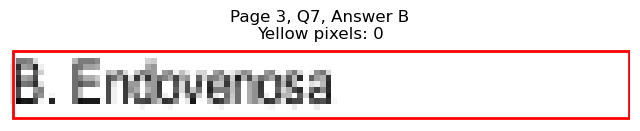

Page 3, Q7 - C: Detected box: x0=71.3, y0=555.4, x1=118.0, y1=567.5
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 219
Page 3, Q7, C: Yellow percentage: 0.0%


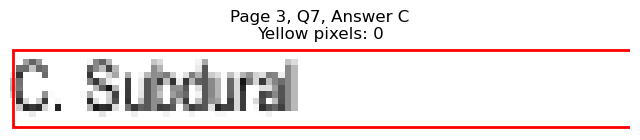

Page 3, Q7 - D: Detected box: x0=322.9, y0=531.4, x1=365.8, y1=543.5
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 210
Page 3, Q7, D: Yellow percentage: 0.0%


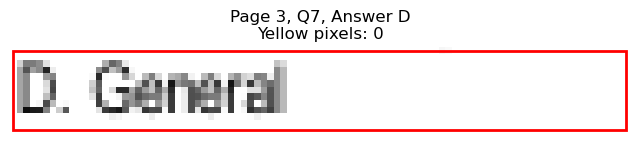

Page 3, Q7 - E: Detected box: x0=322.9, y0=543.4, x1=367.3, y1=555.5
Page 3, Q7, E: Yellow pixels: 360
Page 3, Q7, E: Total non-white pixels: 559
Page 3, Q7, E: Yellow percentage: 64.4%


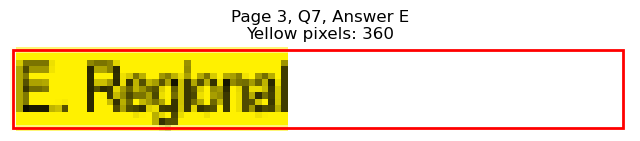


Page 3, Q7 - Selected Answer: E (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=166.6, y0=591.5, x1=269.7, y1=603.5
Page 3, Q8, A: Yellow pixels: 911
Page 3, Q8, A: Total non-white pixels: 1326
Page 3, Q8, A: Yellow percentage: 68.7%


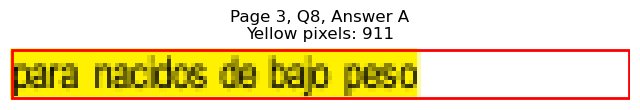

Page 3, Q8 - B: Detected box: x0=71.3, y0=603.5, x1=225.9, y1=615.5
Page 3, Q8, B: Yellow pixels: 184
Page 3, Q8, B: Total non-white pixels: 936
Page 3, Q8, B: Yellow percentage: 19.7%


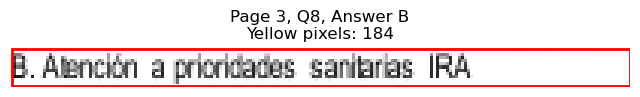

Page 3, Q8 - C: Detected box: x0=71.3, y0=615.5, x1=204.2, y1=627.5
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 658
Page 3, Q8, C: Yellow percentage: 0.0%


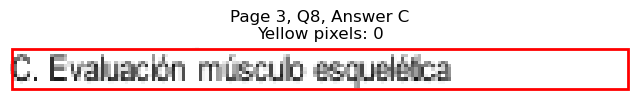

Page 3, Q8 - D: Detected box: x0=322.9, y0=591.5, x1=446.0, y1=603.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 847
Page 3, Q8, D: Yellow percentage: 0.0%


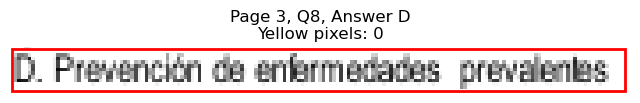

Page 3, Q8 - E: Detected box: x0=391.9, y0=603.5, x1=508.3, y1=615.5
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 572
Page 3, Q8, E: Yellow percentage: 0.0%


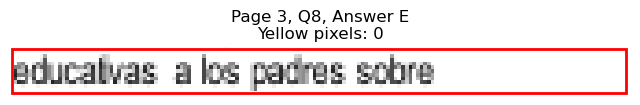


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.6, y0=663.5, x1=112.7, y1=675.6
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 140
Page 3, Q9, A: Yellow percentage: 0.0%


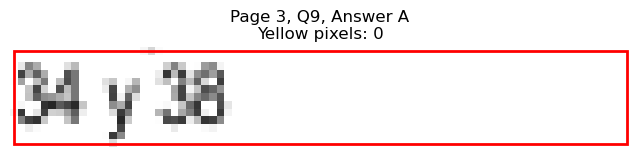

Page 3, Q9 - B: Detected box: x0=71.3, y0=676.3, x1=112.0, y1=688.3
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 172
Page 3, Q9, B: Yellow percentage: 0.0%


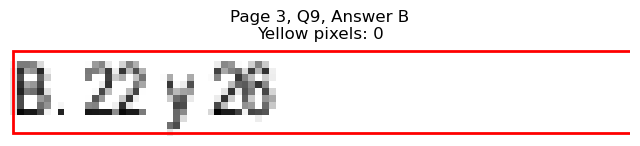

Page 3, Q9 - C: Detected box: x0=71.3, y0=688.3, x1=112.8, y1=700.3
Page 3, Q9, C: Yellow pixels: 340
Page 3, Q9, C: Total non-white pixels: 520
Page 3, Q9, C: Yellow percentage: 65.4%


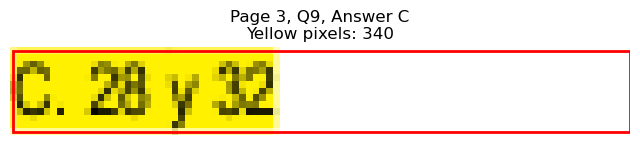

Page 3, Q9 - D: Detected box: x0=322.9, y0=663.5, x1=364.3, y1=675.6
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 184
Page 3, Q9, D: Yellow percentage: 0.0%


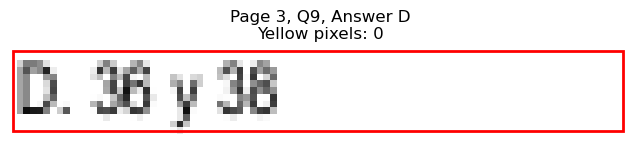

Page 3, Q9 - E: Detected box: x0=322.9, y0=676.3, x1=363.5, y1=688.3
Page 3, Q9, E: Yellow pixels: 0
Page 3, Q9, E: Total non-white pixels: 160
Page 3, Q9, E: Yellow percentage: 0.0%


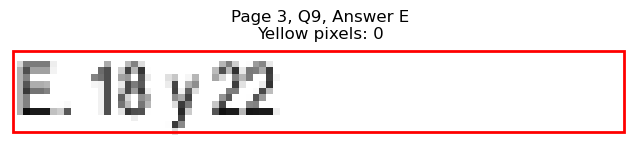


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=82.6, y0=736.4, x1=131.5, y1=748.4
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 225
Page 3, Q10, A: Yellow percentage: 0.0%


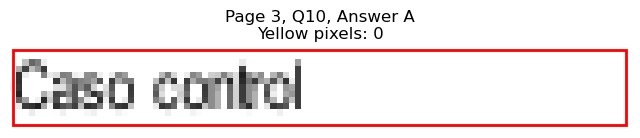

Page 3, Q10 - B: Detected box: x0=71.3, y0=748.4, x1=112.7, y1=760.4
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 196
Page 3, Q10, B: Yellow percentage: 0.0%


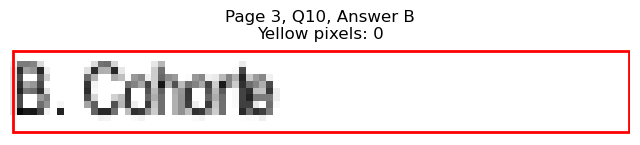

Page 3, Q10 - C: Detected box: x0=71.3, y0=760.4, x1=129.3, y1=772.4
Page 3, Q10, C: Yellow pixels: 509
Page 3, Q10, C: Total non-white pixels: 728
Page 3, Q10, C: Yellow percentage: 69.9%


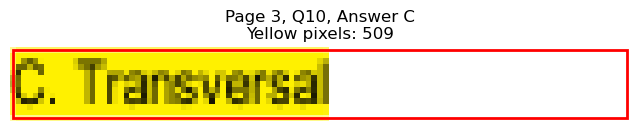

Page 3, Q10 - D: Detected box: x0=322.9, y0=736.4, x1=384.5, y1=748.4
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 309
Page 3, Q10, D: Yellow percentage: 0.0%


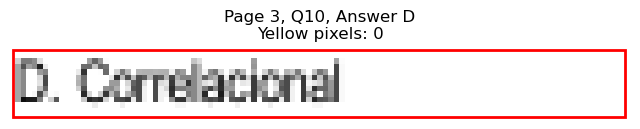

Page 3, Q10 - E: Detected box: x0=322.9, y0=748.4, x1=381.8, y1=760.4
Page 3, Q10, E: Yellow pixels: 0
Page 3, Q10, E: Total non-white pixels: 301
Page 3, Q10, E: Yellow percentage: 0.0%


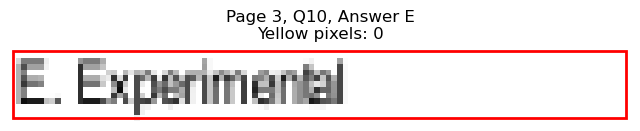


Page 3, Q10 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=182.6, y1=133.6
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 542
Page 4, Q1, A: Yellow percentage: 0.0%


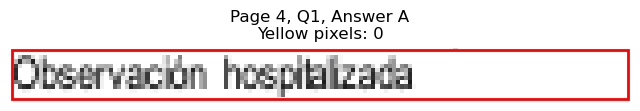

Page 4, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=159.2, y1=145.6
Page 4, Q1, B: Yellow pixels: 976
Page 4, Q1, B: Total non-white pixels: 1586
Page 4, Q1, B: Yellow percentage: 61.5%


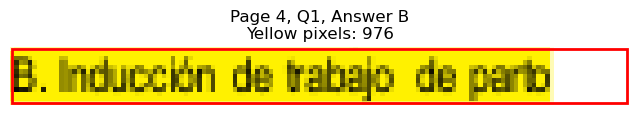

Page 4, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=152.5, y1=157.6
Page 4, Q1, C: Yellow pixels: 121
Page 4, Q1, C: Total non-white pixels: 482
Page 4, Q1, C: Yellow percentage: 25.1%


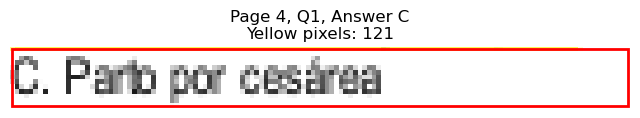

Page 4, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=428.8, y1=133.6
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 540
Page 4, Q1, D: Yellow percentage: 0.0%


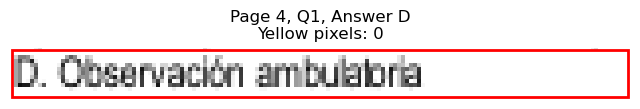

Page 4, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=425.8, y1=145.6
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 486
Page 4, Q1, E: Yellow percentage: 0.0%


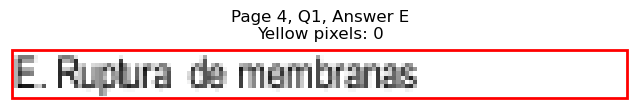


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.6, y0=205.6, x1=115.0, y1=217.7
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 166
Page 4, Q2, A: Yellow percentage: 0.0%


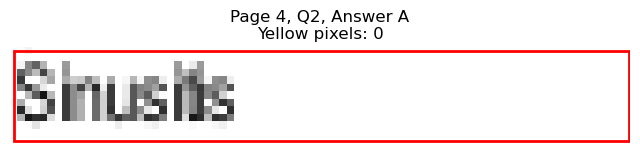

Page 4, Q2 - B: Detected box: x0=71.3, y0=217.6, x1=139.8, y1=229.7
Page 4, Q2, B: Yellow pixels: 543
Page 4, Q2, B: Total non-white pixels: 871
Page 4, Q2, B: Yellow percentage: 62.3%


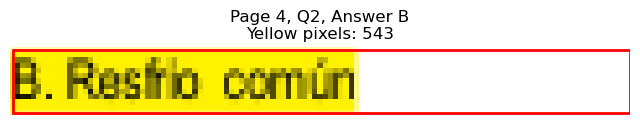

Page 4, Q2 - C: Detected box: x0=71.3, y0=229.6, x1=144.3, y1=241.7
Page 4, Q2, C: Yellow pixels: 66
Page 4, Q2, C: Total non-white pixels: 431
Page 4, Q2, C: Yellow percentage: 15.3%


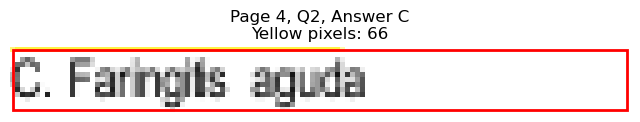

Page 4, Q2 - D: Detected box: x0=322.9, y0=205.6, x1=372.5, y1=217.7
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 254
Page 4, Q2, D: Yellow percentage: 0.0%


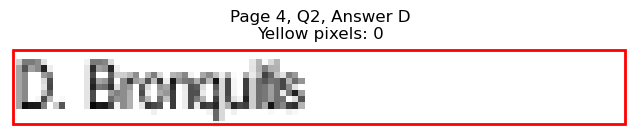

Page 4, Q2 - E: Detected box: x0=322.9, y0=217.6, x1=406.3, y1=229.7
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 408
Page 4, Q2, E: Yellow percentage: 0.0%


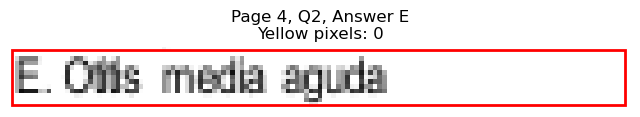


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.6, y0=289.7, x1=128.5, y1=301.8
Page 4, Q3, A: Yellow pixels: 693
Page 4, Q3, A: Total non-white pixels: 1174
Page 4, Q3, A: Yellow percentage: 59.0%


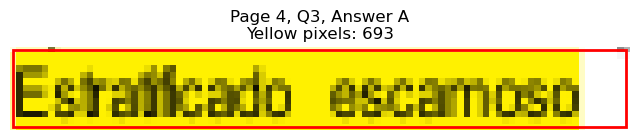

Page 4, Q3 - B: Detected box: x0=71.3, y0=302.5, x1=144.2, y1=314.5
Page 4, Q3, B: Yellow pixels: 88
Page 4, Q3, B: Total non-white pixels: 456
Page 4, Q3, B: Yellow percentage: 19.3%


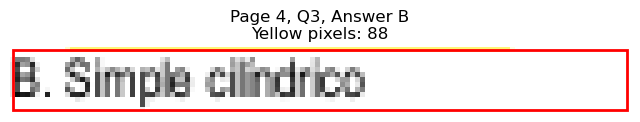

Page 4, Q3 - C: Detected box: x0=71.3, y0=314.5, x1=137.5, y1=326.5
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 297
Page 4, Q3, C: Yellow percentage: 0.0%


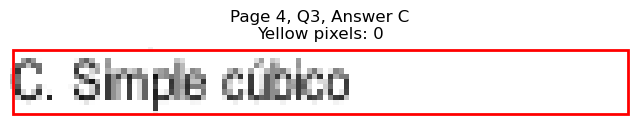

Page 4, Q3 - D: Detected box: x0=322.9, y0=289.7, x1=395.0, y1=301.8
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 364
Page 4, Q3, D: Yellow percentage: 0.0%


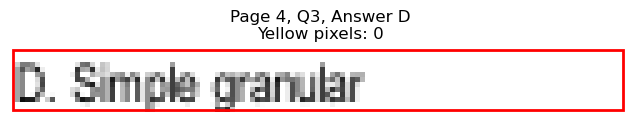

Page 4, Q3 - E: Detected box: x0=322.9, y0=302.5, x1=392.7, y1=314.5
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 555
Page 4, Q3, E: Yellow percentage: 0.0%


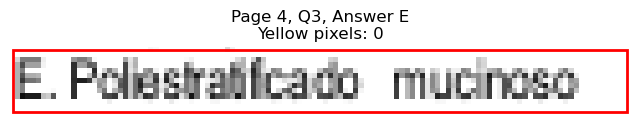


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=128.5, y1=362.5
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 241
Page 4, Q4, A: Yellow percentage: 0.0%


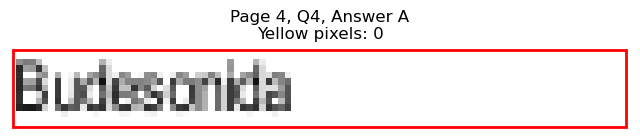

Page 4, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=128.5, y1=374.6
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 300
Page 4, Q4, B: Yellow percentage: 0.0%


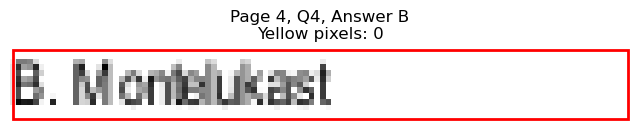

Page 4, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=114.3, y1=386.6
Page 4, Q4, C: Yellow pixels: 362
Page 4, Q4, C: Total non-white pixels: 533
Page 4, Q4, C: Yellow percentage: 67.9%


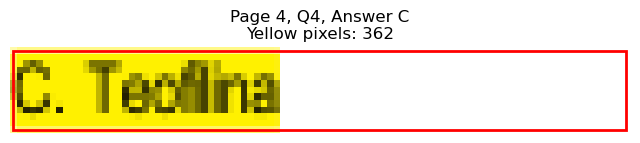

Page 4, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=367.3, y1=362.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 206
Page 4, Q4, D: Yellow percentage: 0.0%


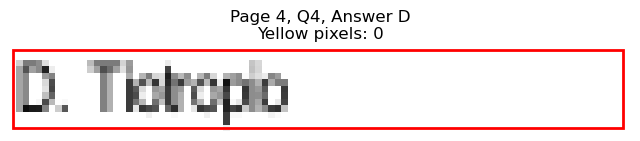

Page 4, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=374.8, y1=374.6
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 260
Page 4, Q4, E: Yellow percentage: 0.0%


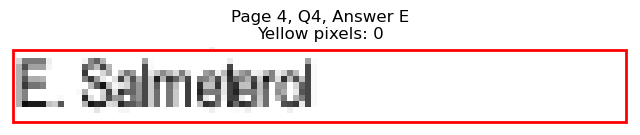


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.6, y0=434.6, x1=126.3, y1=446.6
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 436
Page 4, Q5, A: Yellow percentage: 0.0%


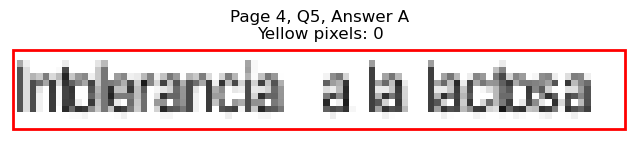

Page 4, Q5 - B: Detected box: x0=71.3, y0=446.6, x1=127.0, y1=458.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 513
Page 4, Q5, B: Yellow percentage: 0.0%


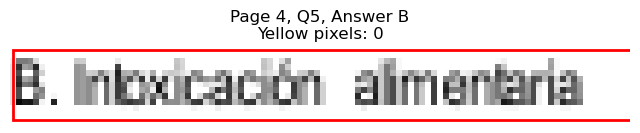

Page 4, Q5 - C: Detected box: x0=71.3, y0=458.6, x1=114.2, y1=470.6
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 206
Page 4, Q5, C: Yellow percentage: 0.0%


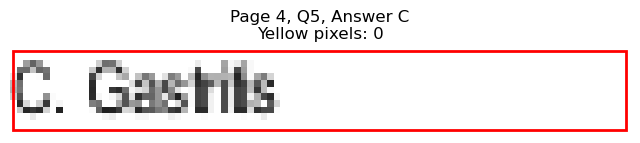

Page 4, Q5 - D: Detected box: x0=322.9, y0=434.6, x1=400.4, y1=446.6
Page 4, Q5, D: Yellow pixels: 598
Page 4, Q5, D: Total non-white pixels: 989
Page 4, Q5, D: Yellow percentage: 60.5%


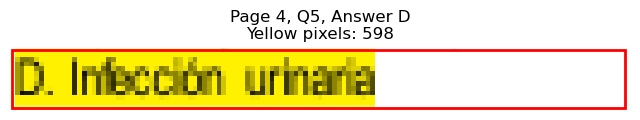

Page 4, Q5 - E: Detected box: x0=322.9, y0=446.6, x1=404.0, y1=458.6
Page 4, Q5, E: Yellow pixels: 75
Page 4, Q5, E: Total non-white pixels: 467
Page 4, Q5, E: Yellow percentage: 16.1%


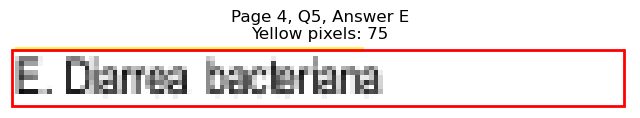


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.6, y0=495.4, x1=164.5, y1=507.4
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 416
Page 4, Q6, A: Yellow percentage: 0.0%


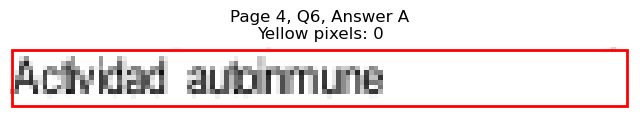

Page 4, Q6 - B: Detected box: x0=71.3, y0=507.4, x1=169.7, y1=519.4
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 489
Page 4, Q6, B: Yellow percentage: 0.0%


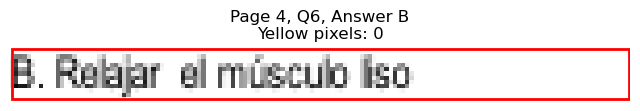

Page 4, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=217.9, y1=531.4
Page 4, Q6, C: Yellow pixels: 1316
Page 4, Q6, C: Total non-white pixels: 1885
Page 4, Q6, C: Yellow percentage: 69.8%


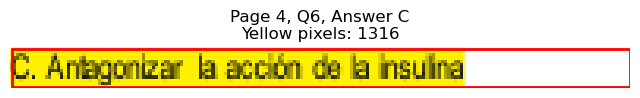

Page 4, Q6 - D: Detected box: x0=322.9, y0=495.4, x1=429.7, y1=507.4
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 510
Page 4, Q6, D: Yellow percentage: 0.0%


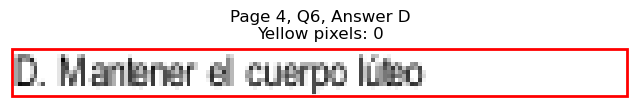

Page 4, Q6 - E: Detected box: x0=322.9, y0=507.4, x1=438.5, y1=519.4
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 737
Page 4, Q6, E: Yellow percentage: 0.0%


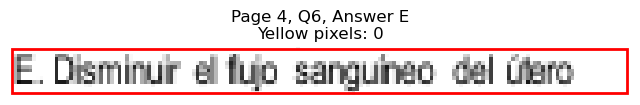


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.6, y0=591.5, x1=157.1, y1=603.5
Page 4, Q7, A: Yellow pixels: 622
Page 4, Q7, A: Total non-white pixels: 949
Page 4, Q7, A: Yellow percentage: 65.5%


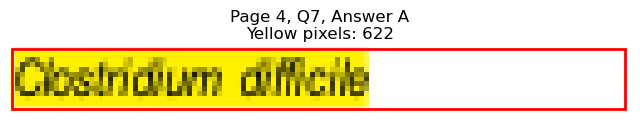

Page 4, Q7 - B: Detected box: x0=71.3, y0=603.5, x1=118.7, y1=615.5
Page 4, Q7, B: Yellow pixels: 72
Page 4, Q7, B: Total non-white pixels: 303
Page 4, Q7, B: Yellow percentage: 23.8%


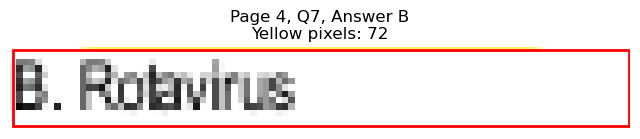

Page 4, Q7 - C: Detected box: x0=71.3, y0=615.5, x1=165.3, y1=627.5
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 473
Page 4, Q7, C: Yellow percentage: 0.0%


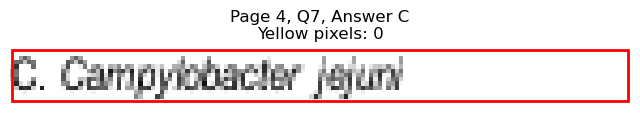

Page 4, Q7 - D: Detected box: x0=322.9, y0=591.5, x1=397.4, y1=603.5
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 352
Page 4, Q7, D: Yellow percentage: 0.0%


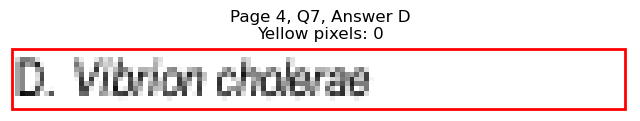

Page 4, Q7 - E: Detected box: x0=322.9, y0=603.5, x1=364.3, y1=615.5
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 266
Page 4, Q7, E: Yellow percentage: 0.0%


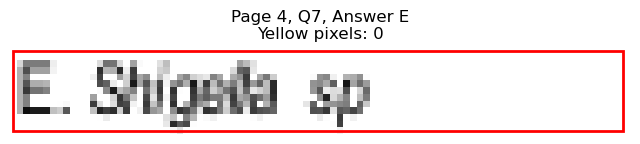


Page 4, Q7 - Selected Answer: A (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.6, y0=651.5, x1=236.5, y1=663.6
Page 4, Q8, A: Yellow pixels: 1359
Page 4, Q8, A: Total non-white pixels: 1989
Page 4, Q8, A: Yellow percentage: 68.3%


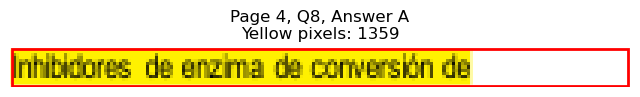

Page 4, Q8 - B: Detected box: x0=144.0, y0=676.3, x1=213.9, y1=688.3
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 337
Page 4, Q8, B: Yellow percentage: 0.0%


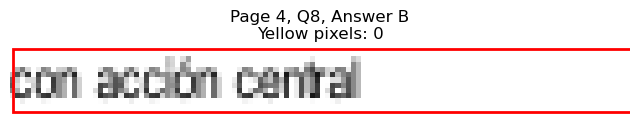

Page 4, Q8 - C: Detected box: x0=322.9, y0=651.5, x1=383.0, y1=663.6
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 557
Page 4, Q8, C: Yellow percentage: 0.0%


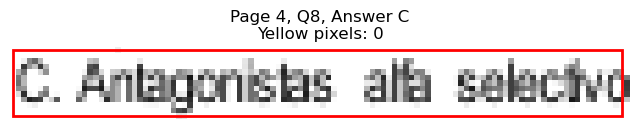

Page 4, Q8 - D: Detected box: x0=322.9, y0=663.5, x1=394.3, y1=675.6
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 531
Page 4, Q8, D: Yellow percentage: 0.0%


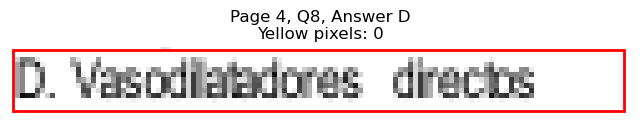

Page 4, Q8 - E: Detected box: x0=385.9, y0=676.3, x1=478.3, y1=688.3
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 439
Page 4, Q8, E: Yellow percentage: 0.0%


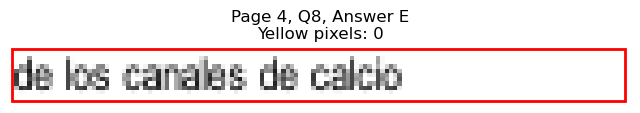


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=82.6, y0=736.4, x1=158.5, y1=748.4
Page 4, Q9, A: Yellow pixels: 989
Page 4, Q9, A: Total non-white pixels: 1444
Page 4, Q9, A: Yellow percentage: 68.5%


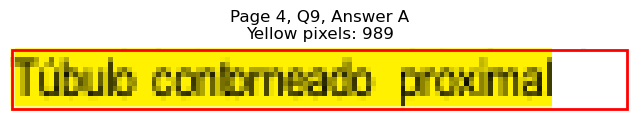

Page 4, Q9 - B: Detected box: x0=71.3, y0=748.4, x1=148.0, y1=760.4
Page 4, Q9, B: Yellow pixels: 110
Page 4, Q9, B: Total non-white pixels: 673
Page 4, Q9, B: Yellow percentage: 16.3%


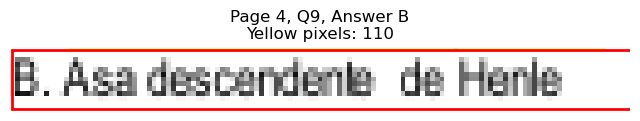

Page 4, Q9 - C: Detected box: x0=71.3, y0=760.4, x1=142.0, y1=772.4
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 316
Page 4, Q9, C: Yellow percentage: 0.0%


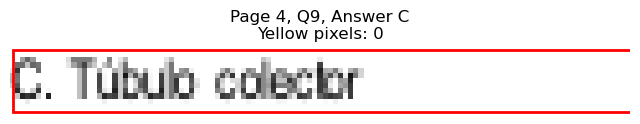

Page 4, Q9 - D: Detected box: x0=322.9, y0=736.4, x1=383.0, y1=748.4
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 289
Page 4, Q9, D: Yellow percentage: 0.0%


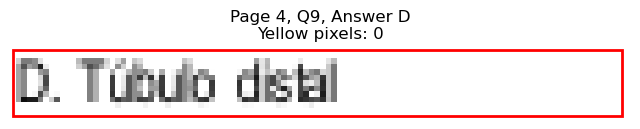

Page 4, Q9 - E: Detected box: x0=322.9, y0=748.4, x1=395.0, y1=760.4
Page 4, Q9, E: Yellow pixels: 0
Page 4, Q9, E: Total non-white pixels: 527
Page 4, Q9, E: Yellow percentage: 0.0%


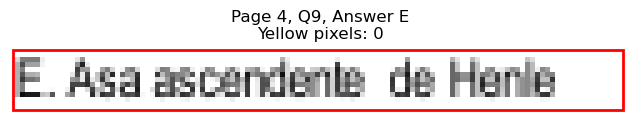


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=244.9, y1=108.8
Page 5, Q1, A: Yellow pixels: 1298
Page 5, Q1, A: Total non-white pixels: 2100
Page 5, Q1, A: Yellow percentage: 61.8%


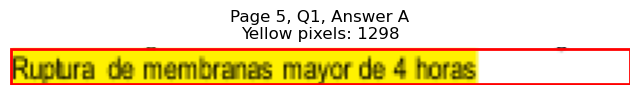

Page 5, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=171.2, y1=121.6
Page 5, Q1, B: Yellow pixels: 139
Page 5, Q1, B: Total non-white pixels: 650
Page 5, Q1, B: Yellow percentage: 21.4%


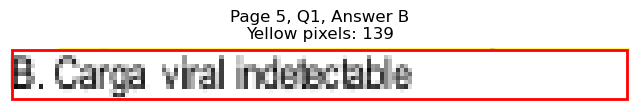

Page 5, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=255.2, y1=133.6
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 876
Page 5, Q1, C: Yellow percentage: 0.0%


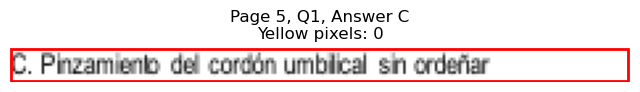

Page 5, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=379.3, y1=108.8
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 543
Page 5, Q1, D: Yellow percentage: 0.0%


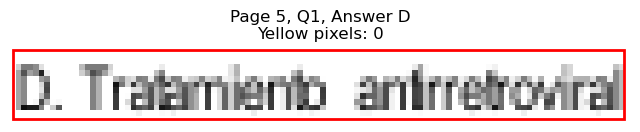

Page 5, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=419.7, y1=121.6
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 718
Page 5, Q1, E: Yellow percentage: 0.0%


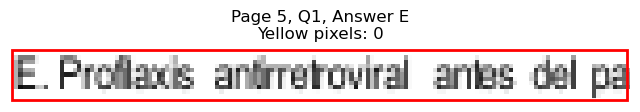


Page 5, Q1 - Selected Answer: A (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=126.8, y0=157.6, x1=168.2, y1=169.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 225
Page 5, Q2, A: Yellow percentage: 0.0%


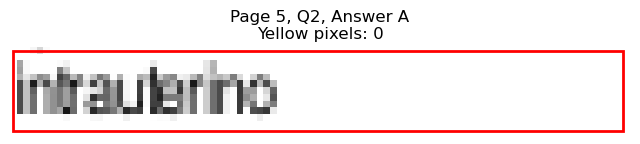

Page 5, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=154.7, y1=181.6
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 415
Page 5, Q2, B: Yellow percentage: 0.0%


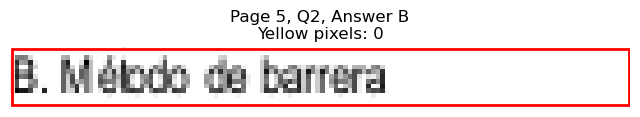

Page 5, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=181.0, y1=193.6
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 548
Page 5, Q2, C: Yellow percentage: 0.0%


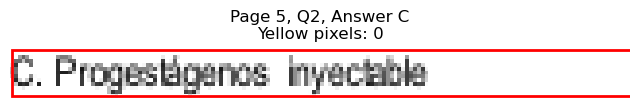

Page 5, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=454.3, y1=169.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 660
Page 5, Q2, D: Yellow percentage: 0.0%


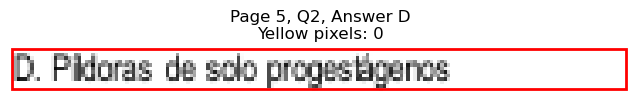

Page 5, Q2 - E: Detected box: x0=396.5, y0=169.6, x1=469.5, y1=181.6
Page 5, Q2, E: Yellow pixels: 562
Page 5, Q2, E: Total non-white pixels: 936
Page 5, Q2, E: Yellow percentage: 60.0%


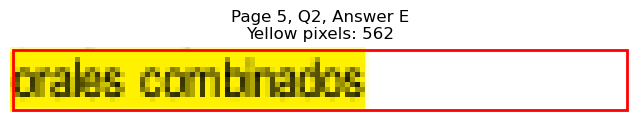


Page 5, Q2 - Selected Answer: E (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=184.6, y0=217.6, x1=278.7, y1=229.7
Page 5, Q3, A: Yellow pixels: 737
Page 5, Q3, A: Total non-white pixels: 1248
Page 5, Q3, A: Yellow percentage: 59.1%


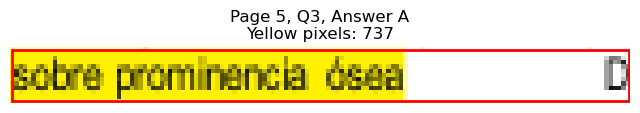

Page 5, Q3 - B: Detected box: x0=71.3, y0=229.6, x1=250.8, y1=241.7
Page 5, Q3, B: Yellow pixels: 193
Page 5, Q3, B: Total non-white pixels: 1023
Page 5, Q3, B: Yellow percentage: 18.9%


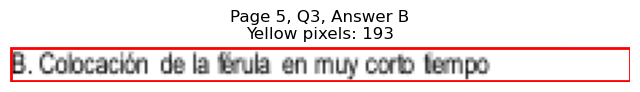

Page 5, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=193.0, y1=253.7
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 574
Page 5, Q3, C: Yellow percentage: 0.0%


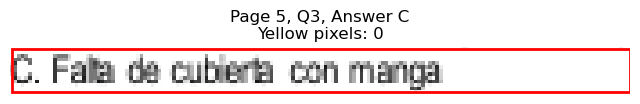

Page 5, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=446.0, y1=229.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 733
Page 5, Q3, D: Yellow percentage: 0.0%


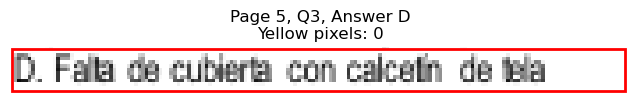

Page 5, Q3 - E: Detected box: x0=322.9, y0=229.6, x1=424.3, y1=241.7
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 479
Page 5, Q3, E: Yellow percentage: 0.0%


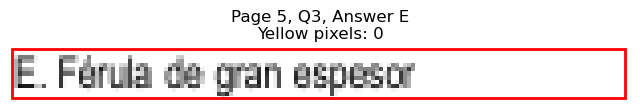


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=133.1, y1=301.8
Page 5, Q4, A: Yellow pixels: 356
Page 5, Q4, A: Total non-white pixels: 637
Page 5, Q4, A: Yellow percentage: 55.9%


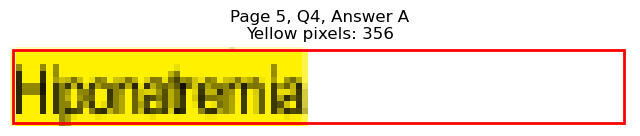

Page 5, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=132.2, y1=314.5
Page 5, Q4, B: Yellow pixels: 47
Page 5, Q4, B: Total non-white pixels: 370
Page 5, Q4, B: Yellow percentage: 12.7%


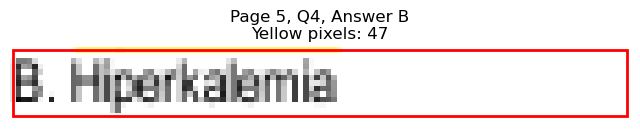

Page 5, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=136.0, y1=326.5
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 303
Page 5, Q4, C: Yellow percentage: 0.0%


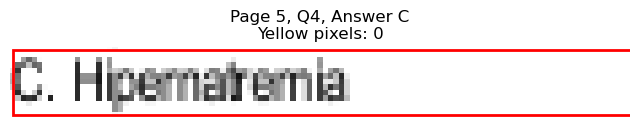

Page 5, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=386.0, y1=301.8
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 326
Page 5, Q4, D: Yellow percentage: 0.0%


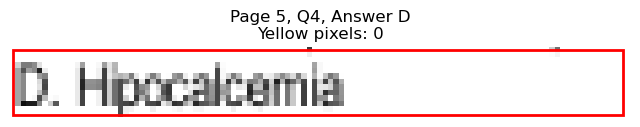

Page 5, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=380.8, y1=314.5
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 290
Page 5, Q4, E: Yellow percentage: 0.0%


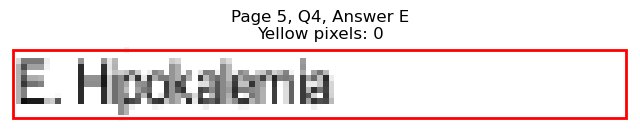


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.6, y0=350.5, x1=142.8, y1=362.5
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 574
Page 5, Q5, A: Yellow percentage: 0.0%


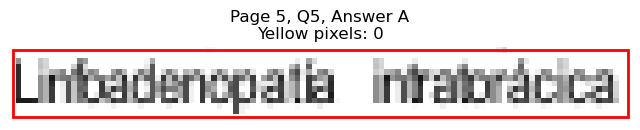

Page 5, Q5 - B: Detected box: x0=71.3, y0=362.5, x1=113.5, y1=374.6
Page 5, Q5, B: Yellow pixels: 813
Page 5, Q5, B: Total non-white pixels: 1209
Page 5, Q5, B: Yellow percentage: 67.2%


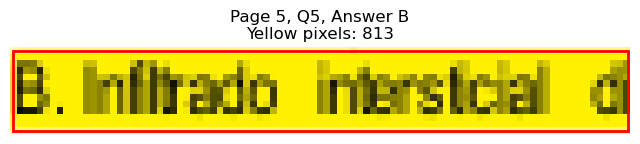

Page 5, Q5 - C: Detected box: x0=71.3, y0=374.5, x1=157.1, y1=386.6
Page 5, Q5, C: Yellow pixels: 108
Page 5, Q5, C: Total non-white pixels: 510
Page 5, Q5, C: Yellow percentage: 21.2%


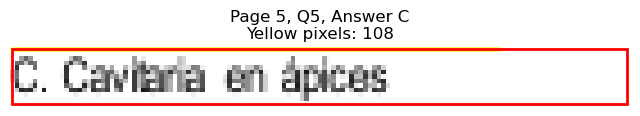

Page 5, Q5 - D: Detected box: x0=322.9, y0=350.5, x1=401.8, y1=362.5
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 383
Page 5, Q5, D: Yellow percentage: 0.0%


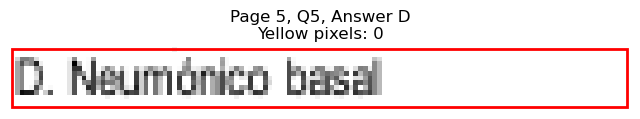

Page 5, Q5 - E: Detected box: x0=322.9, y0=362.5, x1=395.8, y1=374.6
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 351
Page 5, Q5, E: Yellow percentage: 0.0%


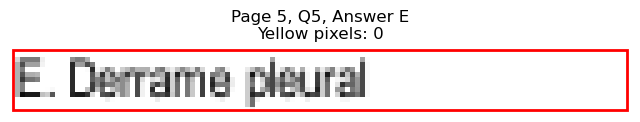


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.6, y0=422.5, x1=153.3, y1=434.6
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 348
Page 5, Q6, A: Yellow percentage: 0.0%


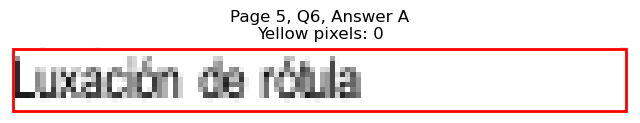

Page 5, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=168.2, y1=446.6
Page 5, Q6, B: Yellow pixels: 1190
Page 5, Q6, B: Total non-white pixels: 1924
Page 5, Q6, B: Yellow percentage: 61.9%


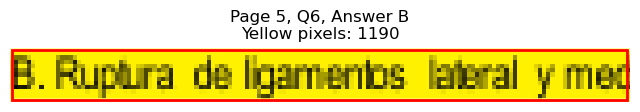

Page 5, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=181.7, y1=458.6
Page 5, Q6, C: Yellow pixels: 156
Page 5, Q6, C: Total non-white pixels: 661
Page 5, Q6, C: Yellow percentage: 23.6%


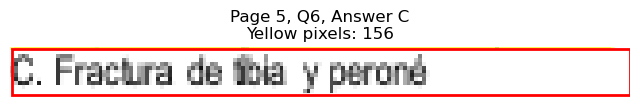

Page 5, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=423.5, y1=434.6
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 508
Page 5, Q6, D: Yellow percentage: 0.0%


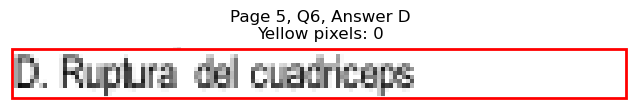

Page 5, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=428.0, y1=446.6
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 483
Page 5, Q6, E: Yellow percentage: 0.0%


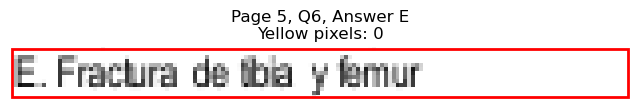


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=123.9, y0=495.4, x1=211.8, y1=507.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 431
Page 5, Q7, A: Yellow percentage: 0.0%


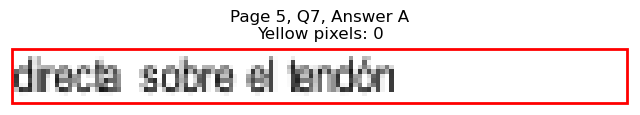

Page 5, Q7 - B: Detected box: x0=71.3, y0=507.4, x1=198.4, y1=519.4
Page 5, Q7, B: Yellow pixels: 1138
Page 5, Q7, B: Total non-white pixels: 1625
Page 5, Q7, B: Yellow percentage: 70.0%


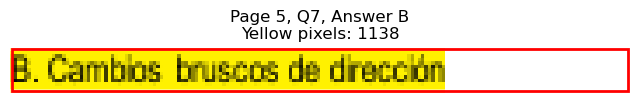

Page 5, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=200.6, y1=531.4
Page 5, Q7, C: Yellow pixels: 124
Page 5, Q7, C: Total non-white pixels: 749
Page 5, Q7, C: Yellow percentage: 16.6%


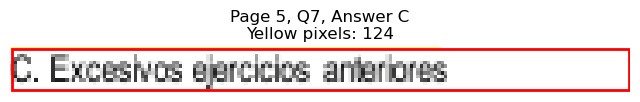

Page 5, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=408.5, y1=507.4
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 643
Page 5, Q7, D: Yellow percentage: 0.0%


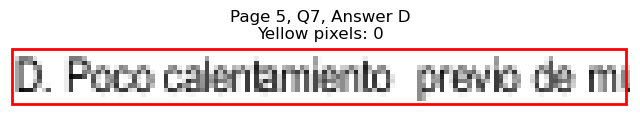

Page 5, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=439.2, y1=519.4
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 562
Page 5, Q7, E: Yellow percentage: 0.0%


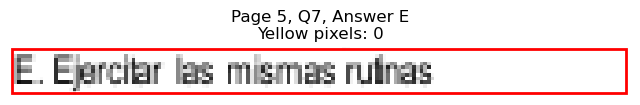


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=122.5, y1=591.5
Page 5, Q8, A: Yellow pixels: 311
Page 5, Q8, A: Total non-white pixels: 509
Page 5, Q8, A: Yellow percentage: 61.1%


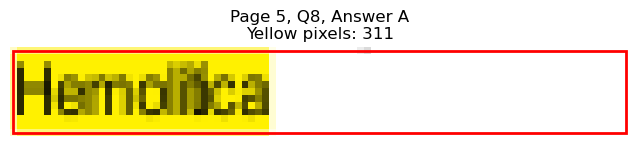

Page 5, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=123.2, y1=603.5
Page 5, Q8, B: Yellow pixels: 37
Page 5, Q8, B: Total non-white pixels: 446
Page 5, Q8, B: Yellow percentage: 8.3%


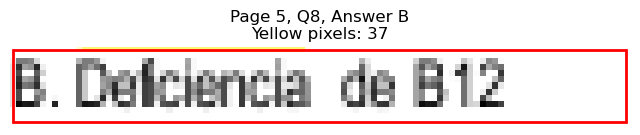

Page 5, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=141.3, y1=615.5
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 356
Page 5, Q8, C: Yellow percentage: 0.0%


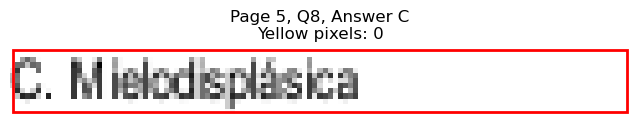

Page 5, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=380.8, y1=591.5
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 287
Page 5, Q8, D: Yellow percentage: 0.0%


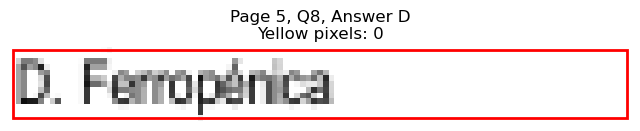

Page 5, Q8 - E: Detected box: x0=377.6, y0=591.5, x1=433.3, y1=603.5
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 274
Page 5, Q8, E: Yellow percentage: 0.0%


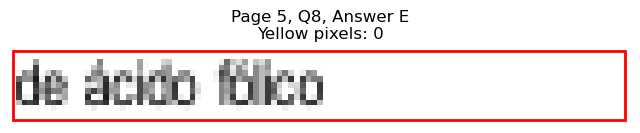


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=82.6, y0=639.5, x1=218.5, y1=651.6
Page 5, Q9, A: Yellow pixels: 1566
Page 5, Q9, A: Total non-white pixels: 2288
Page 5, Q9, A: Yellow percentage: 68.4%


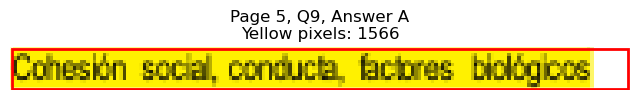

Page 5, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=229.0, y1=663.6
Page 5, Q9, B: Yellow pixels: 174
Page 5, Q9, B: Total non-white pixels: 933
Page 5, Q9, B: Yellow percentage: 18.6%


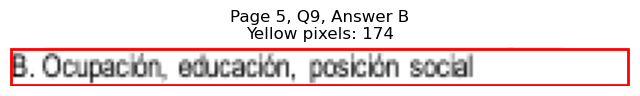

Page 5, Q9 - C: Detected box: x0=151.6, y0=663.5, x1=268.8, y1=675.6
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 588
Page 5, Q9, C: Yellow percentage: 0.0%


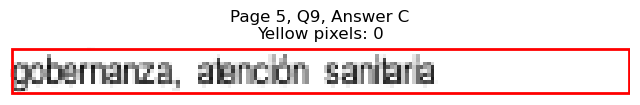

Page 5, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=442.2, y1=651.6
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 808
Page 5, Q9, D: Yellow percentage: 0.0%


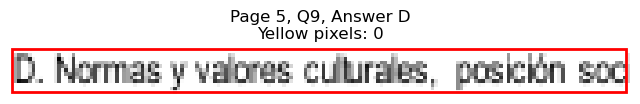

Page 5, Q9 - E: Detected box: x0=392.6, y0=651.5, x1=487.2, y1=663.6
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 451
Page 5, Q9, E: Yellow percentage: 0.0%


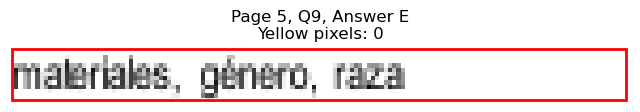


Page 5, Q9 - Selected Answer: A (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=82.6, y0=724.3, x1=122.5, y1=736.4
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 207
Page 5, Q10, A: Yellow percentage: 0.0%


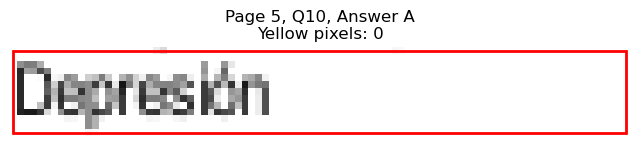

Page 5, Q10 - B: Detected box: x0=71.3, y0=736.4, x1=121.7, y1=748.4
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 251
Page 5, Q10, B: Yellow percentage: 0.0%


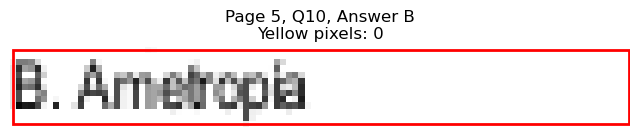

Page 5, Q10 - C: Detected box: x0=71.3, y0=748.4, x1=142.0, y1=760.4
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 313
Page 5, Q10, C: Yellow percentage: 0.0%


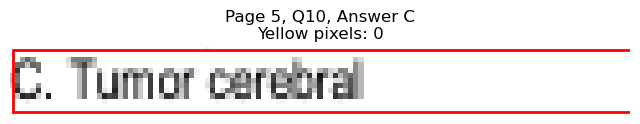

Page 5, Q10 - D: Detected box: x0=322.9, y0=724.3, x1=367.3, y1=736.4
Page 5, Q10, D: Yellow pixels: 325
Page 5, Q10, D: Total non-white pixels: 559
Page 5, Q10, D: Yellow percentage: 58.1%


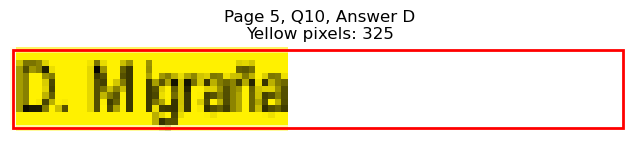

Page 5, Q10 - E: Detected box: x0=322.9, y0=736.4, x1=379.4, y1=748.4
Page 5, Q10, E: Yellow pixels: 2
Page 5, Q10, E: Total non-white pixels: 298
Page 5, Q10, E: Yellow percentage: 0.7%


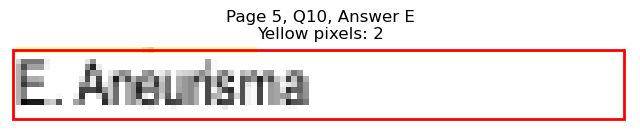


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=143.6, y1=108.8
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 463
Page 6, Q1, A: Yellow percentage: 0.0%


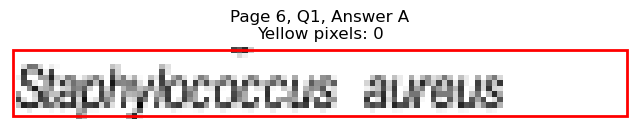

Page 6, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=144.3, y1=121.6
Page 6, Q1, B: Yellow pixels: 640
Page 6, Q1, B: Total non-white pixels: 923
Page 6, Q1, B: Yellow percentage: 69.3%


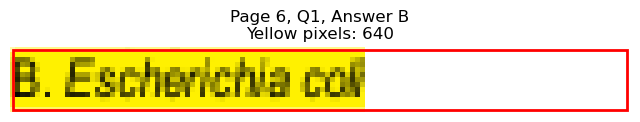

Page 6, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=167.6, y1=133.6
Page 6, Q1, C: Yellow pixels: 71
Page 6, Q1, C: Total non-white pixels: 534
Page 6, Q1, C: Yellow percentage: 13.3%


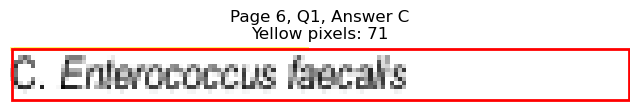

Page 6, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=423.7, y1=108.8
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 504
Page 6, Q1, D: Yellow percentage: 0.0%


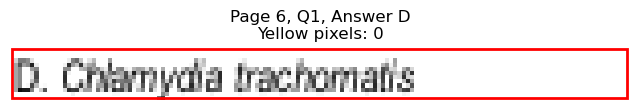

Page 6, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=398.1, y1=121.6
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 340
Page 6, Q1, E: Yellow percentage: 0.0%


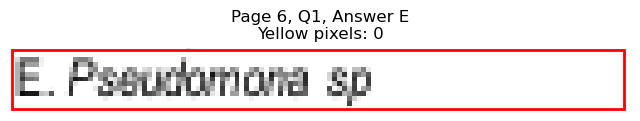


Page 6, Q1 - Selected Answer: B (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=148.0, y1=181.6
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 340
Page 6, Q2, A: Yellow percentage: 0.0%


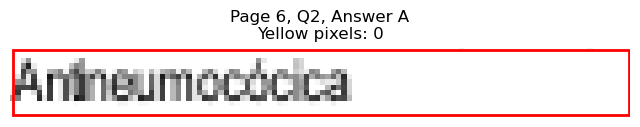

Page 6, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=142.0, y1=193.6
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 352
Page 6, Q2, B: Yellow percentage: 0.0%


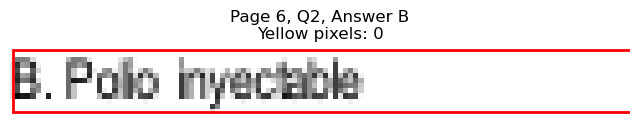

Page 6, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=117.2, y1=205.6
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 208
Page 6, Q2, C: Yellow percentage: 0.0%


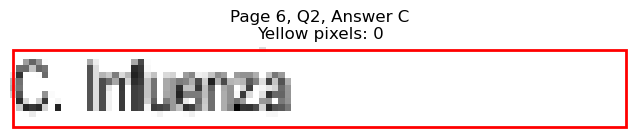

Page 6, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=408.6, y1=181.6
Page 6, Q2, D: Yellow pixels: 683
Page 6, Q2, D: Total non-white pixels: 1105
Page 6, Q2, D: Yellow percentage: 61.8%


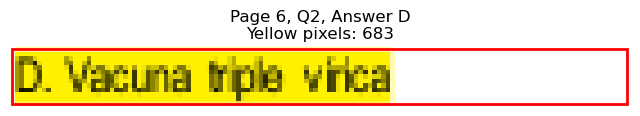

Page 6, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=382.3, y1=193.6
Page 6, Q2, E: Yellow pixels: 83
Page 6, Q2, E: Total non-white pixels: 373
Page 6, Q2, E: Yellow percentage: 22.3%


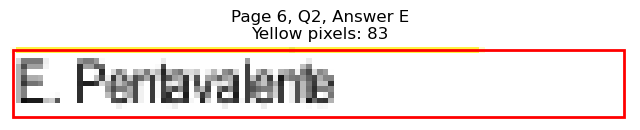


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=157.0, y1=265.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 394
Page 6, Q3, A: Yellow percentage: 0.0%


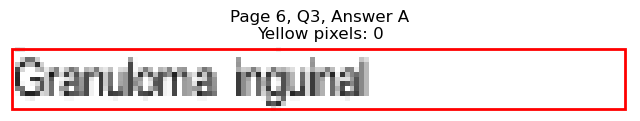

Page 6, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=126.3, y1=277.7
Page 6, Q3, B: Yellow pixels: 429
Page 6, Q3, B: Total non-white pixels: 691
Page 6, Q3, B: Yellow percentage: 62.1%


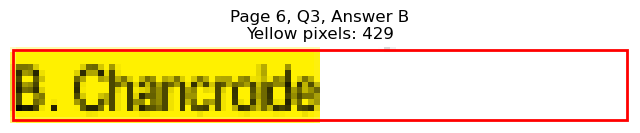

Page 6, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=103.0, y1=289.7
Page 6, Q3, C: Yellow pixels: 53
Page 6, Q3, C: Total non-white pixels: 196
Page 6, Q3, C: Yellow percentage: 27.0%


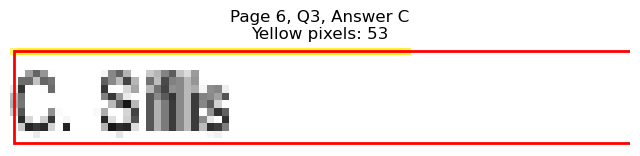

Page 6, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=389.1, y1=265.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 341
Page 6, Q3, D: Yellow percentage: 0.0%


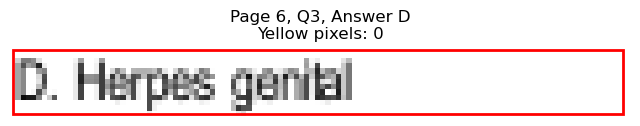

Page 6, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=383.8, y1=277.7
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 278
Page 6, Q3, E: Yellow percentage: 0.0%


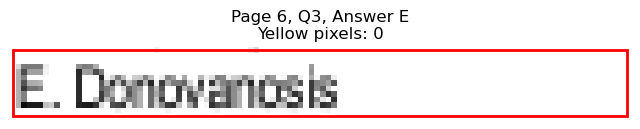


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=169.7, y1=338.5
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 451
Page 6, Q4, A: Yellow percentage: 0.0%


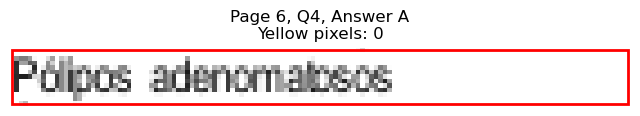

Page 6, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=144.3, y1=350.5
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 371
Page 6, Q4, B: Yellow percentage: 0.0%


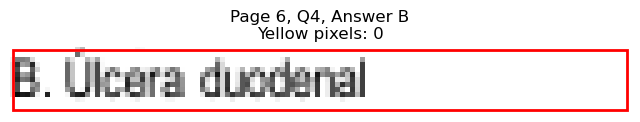

Page 6, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=154.8, y1=362.5
Page 6, Q4, C: Yellow pixels: 731
Page 6, Q4, C: Total non-white pixels: 1066
Page 6, Q4, C: Yellow percentage: 68.6%


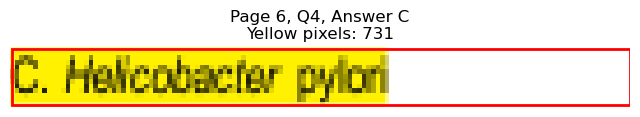

Page 6, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=365.8, y1=338.5
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 220
Page 6, Q4, D: Yellow percentage: 0.0%


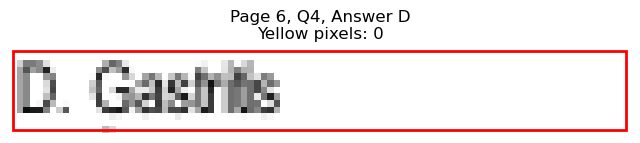

Page 6, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=391.3, y1=350.5
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 341
Page 6, Q4, E: Yellow percentage: 0.0%


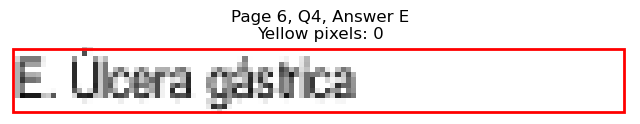


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=130.0, y1=398.6
Page 6, Q5, A: Yellow pixels: 354
Page 6, Q5, A: Total non-white pixels: 599
Page 6, Q5, A: Yellow percentage: 59.1%


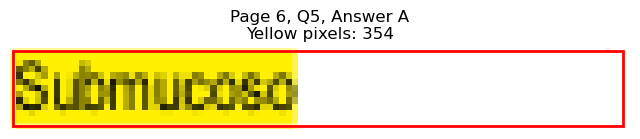

Page 6, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=104.5, y1=410.6
Page 6, Q5, B: Yellow pixels: 45
Page 6, Q5, B: Total non-white pixels: 205
Page 6, Q5, B: Yellow percentage: 22.0%


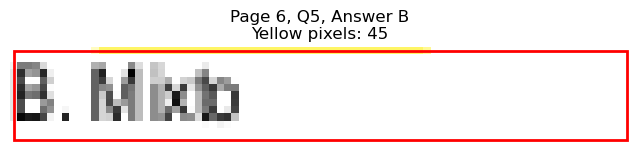

Page 6, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=121.8, y1=422.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 224
Page 6, Q5, C: Yellow percentage: 0.0%


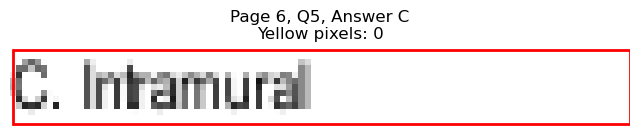

Page 6, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=377.0, y1=398.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 270
Page 6, Q5, D: Yellow percentage: 0.0%


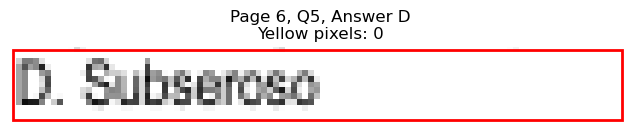

Page 6, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=379.3, y1=410.6
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 280
Page 6, Q5, E: Yellow percentage: 0.0%


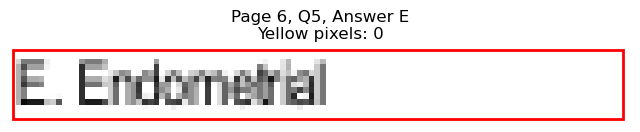


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.6, y0=470.6, x1=126.2, y1=482.6
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 432
Page 6, Q6, A: Yellow percentage: 0.0%


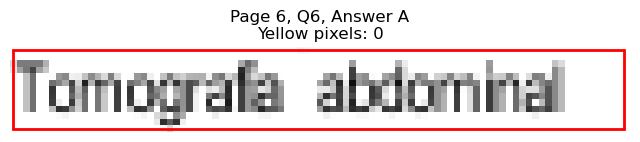

Page 6, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=169.7, y1=495.4
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 498
Page 6, Q6, B: Yellow percentage: 0.0%


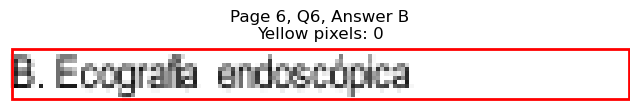

Page 6, Q6 - C: Detected box: x0=71.3, y0=495.4, x1=136.8, y1=507.4
Page 6, Q6, C: Yellow pixels: 1034
Page 6, Q6, C: Total non-white pixels: 1508
Page 6, Q6, C: Yellow percentage: 68.6%


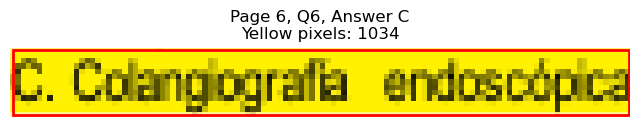

Page 6, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=389.8, y1=482.6
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 598
Page 6, Q6, D: Yellow percentage: 0.0%


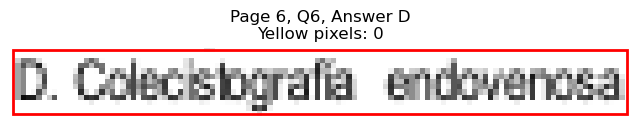

Page 6, Q6 - E: Detected box: x0=322.9, y0=483.4, x1=412.3, y1=495.4
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 445
Page 6, Q6, E: Yellow percentage: 0.0%


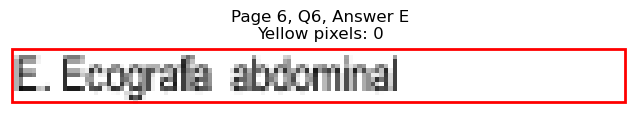


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.6, y0=531.4, x1=151.8, y1=543.5
Page 6, Q7, A: Yellow pixels: 602
Page 6, Q7, A: Total non-white pixels: 885
Page 6, Q7, A: Yellow percentage: 68.0%


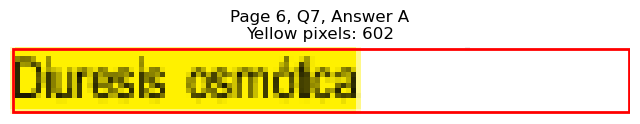

Page 6, Q7 - B: Detected box: x0=71.3, y0=543.4, x1=128.5, y1=555.5
Page 6, Q7, B: Yellow pixels: 66
Page 6, Q7, B: Total non-white pixels: 613
Page 6, Q7, B: Yellow percentage: 10.8%


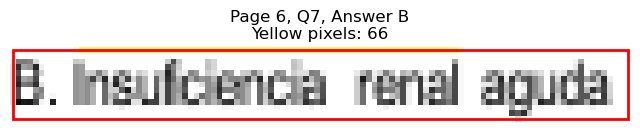

Page 6, Q7 - C: Detected box: x0=71.3, y0=555.4, x1=129.2, y1=567.5
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 519
Page 6, Q7, C: Yellow percentage: 0.0%


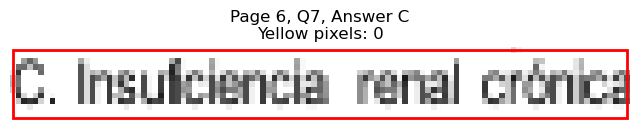

Page 6, Q7 - D: Detected box: x0=378.4, y0=531.4, x1=451.3, y1=543.5
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 384
Page 6, Q7, D: Yellow percentage: 0.0%


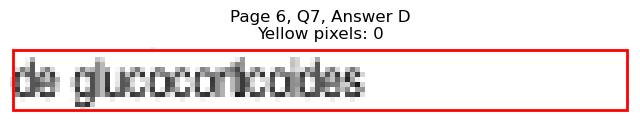

Page 6, Q7 - E: Detected box: x0=322.9, y0=543.4, x1=377.8, y1=555.5
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 411
Page 6, Q7, E: Yellow percentage: 0.0%


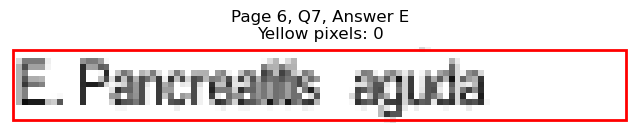


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.6, y0=603.5, x1=143.5, y1=615.5
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 299
Page 6, Q8, A: Yellow percentage: 0.0%


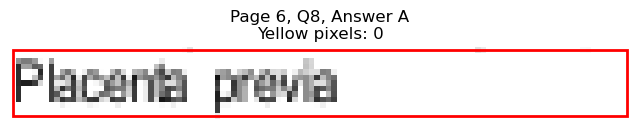

Page 6, Q8 - B: Detected box: x0=71.3, y0=615.5, x1=139.8, y1=627.5
Page 6, Q8, B: Yellow pixels: 586
Page 6, Q8, B: Total non-white pixels: 871
Page 6, Q8, B: Yellow percentage: 67.3%


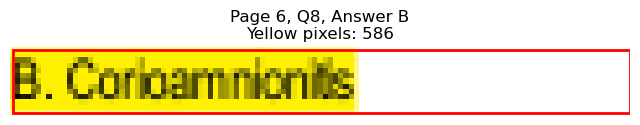

Page 6, Q8 - C: Detected box: x0=122.3, y0=627.5, x1=187.7, y1=639.6
Page 6, Q8, C: Yellow pixels: 15
Page 6, Q8, C: Total non-white pixels: 292
Page 6, Q8, C: Yellow percentage: 5.1%


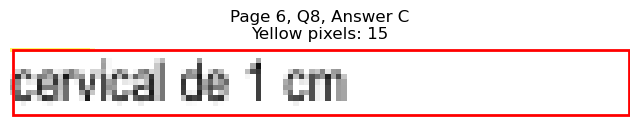

Page 6, Q8 - D: Detected box: x0=322.9, y0=603.5, x1=467.7, y1=615.5
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 706
Page 6, Q8, D: Yellow percentage: 0.0%


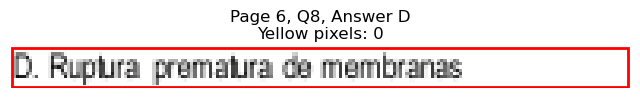

Page 6, Q8 - E: Detected box: x0=322.9, y0=615.5, x1=454.2, y1=627.5
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 658
Page 6, Q8, E: Yellow percentage: 0.0%


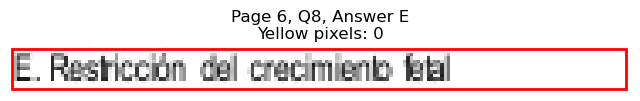


Page 6, Q8 - Selected Answer: B (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.6, y0=688.3, x1=148.0, y1=700.3
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 337
Page 6, Q9, A: Yellow percentage: 0.0%


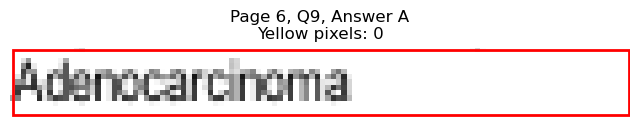

Page 6, Q9 - B: Detected box: x0=71.3, y0=700.3, x1=169.7, y1=712.3
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 488
Page 6, Q9, B: Yellow percentage: 0.0%


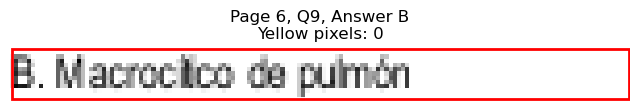

Page 6, Q9 - C: Detected box: x0=71.3, y0=712.3, x1=131.5, y1=724.4
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 285
Page 6, Q9, C: Yellow percentage: 0.0%


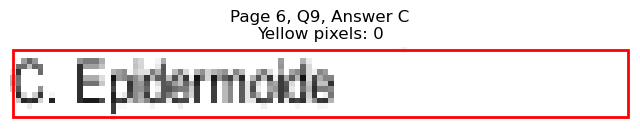

Page 6, Q9 - D: Detected box: x0=322.9, y0=688.3, x1=419.2, y1=700.3
Page 6, Q9, D: Yellow pixels: 762
Page 6, Q9, D: Total non-white pixels: 1235
Page 6, Q9, D: Yellow percentage: 61.7%


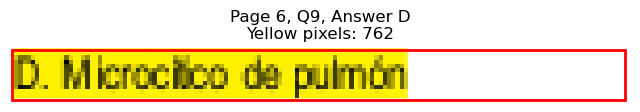

Page 6, Q9 - E: Detected box: x0=322.9, y0=700.3, x1=412.3, y1=712.3
Page 6, Q9, E: Yellow pixels: 1
Page 6, Q9, E: Total non-white pixels: 539
Page 6, Q9, E: Yellow percentage: 0.2%


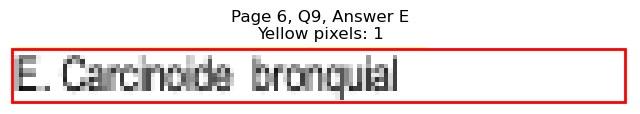


Page 6, Q9 - Selected Answer: D (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=82.6, y0=748.4, x1=94.0, y1=760.4
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 50
Page 6, Q10, A: Yellow percentage: 0.0%


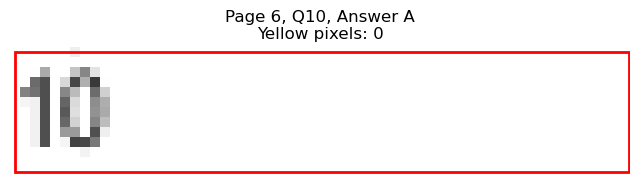

Page 6, Q10 - B: Detected box: x0=71.3, y0=760.4, x1=88.7, y1=772.4
Page 6, Q10, B: Yellow pixels: 143
Page 6, Q10, B: Total non-white pixels: 208
Page 6, Q10, B: Yellow percentage: 68.8%


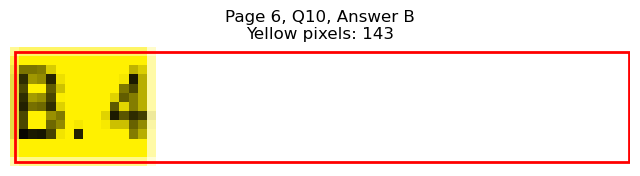

Page 6, Q10 - C: Detected box: x0=71.3, y0=772.4, x1=89.5, y1=784.4
Page 6, Q10, C: Yellow pixels: 14
Page 6, Q10, C: Total non-white pixels: 78
Page 6, Q10, C: Yellow percentage: 17.9%


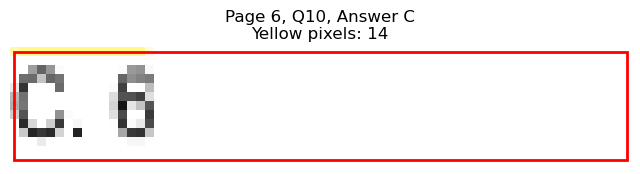

Page 6, Q10 - D: Detected box: x0=322.9, y0=748.4, x1=341.0, y1=760.4
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 69
Page 6, Q10, D: Yellow percentage: 0.0%


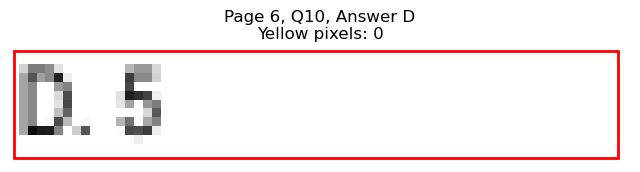

Page 6, Q10 - E: Detected box: x0=322.9, y0=760.4, x1=338.2, y1=772.4
Page 6, Q10, E: Yellow pixels: 0
Page 6, Q10, E: Total non-white pixels: 64
Page 6, Q10, E: Yellow percentage: 0.0%


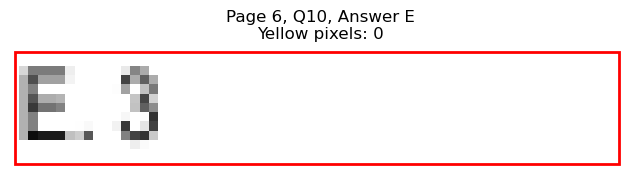


Page 6, Q10 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=136.7, y1=133.6
Page 7, Q1, A: Yellow pixels: 915
Page 7, Q1, A: Total non-white pixels: 1365
Page 7, Q1, A: Yellow percentage: 67.0%


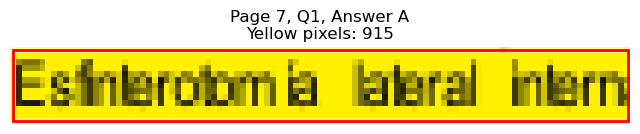

Page 7, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=136.0, y1=145.6
Page 7, Q1, B: Yellow pixels: 103
Page 7, Q1, B: Total non-white pixels: 666
Page 7, Q1, B: Yellow percentage: 15.5%


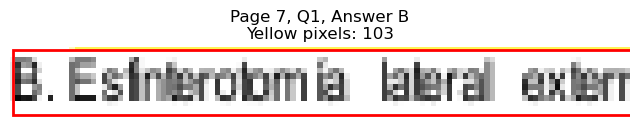

Page 7, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=159.2, y1=157.6
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 416
Page 7, Q1, C: Yellow percentage: 0.0%


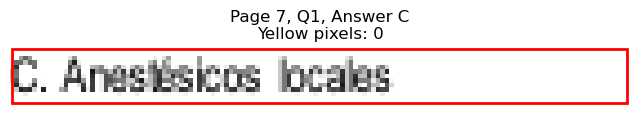

Page 7, Q1 - D: Detected box: x0=375.4, y0=121.5, x1=452.8, y1=133.6
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 378
Page 7, Q1, D: Yellow percentage: 0.0%


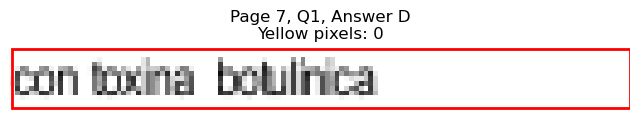

Page 7, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=378.6, y1=145.6
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 268
Page 7, Q1, E: Yellow percentage: 0.0%


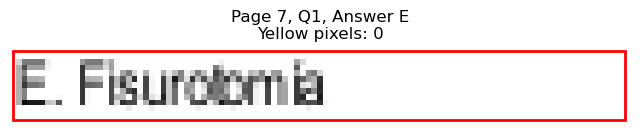


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=133.0, y1=205.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 245
Page 7, Q2, A: Yellow percentage: 0.0%


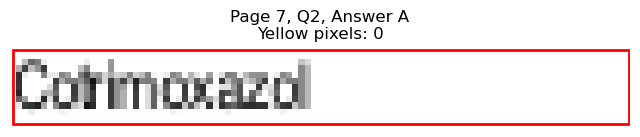

Page 7, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=130.7, y1=217.7
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 310
Page 7, Q2, B: Yellow percentage: 0.0%


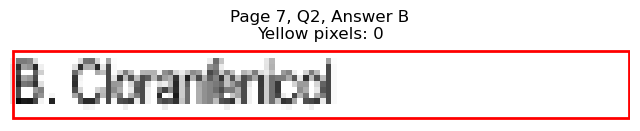

Page 7, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=125.5, y1=229.7
Page 7, Q2, C: Yellow pixels: 410
Page 7, Q2, C: Total non-white pixels: 689
Page 7, Q2, C: Yellow percentage: 59.5%


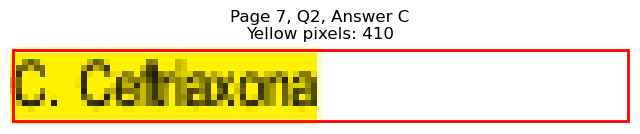

Page 7, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=380.0, y1=205.6
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 286
Page 7, Q2, D: Yellow percentage: 0.0%


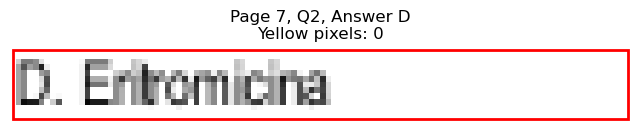

Page 7, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=377.0, y1=217.7
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 268
Page 7, Q2, E: Yellow percentage: 0.0%


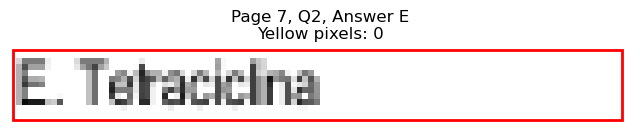


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.6, y0=265.7, x1=132.3, y1=277.7
Page 7, Q3, A: Yellow pixels: 348
Page 7, Q3, A: Total non-white pixels: 624
Page 7, Q3, A: Yellow percentage: 55.8%


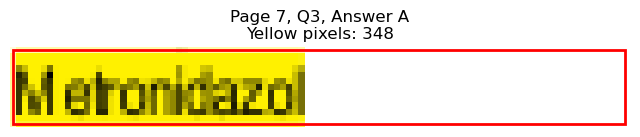

Page 7, Q3 - B: Detected box: x0=71.3, y0=277.7, x1=124.0, y1=289.7
Page 7, Q3, B: Yellow pixels: 47
Page 7, Q3, B: Total non-white pixels: 303
Page 7, Q3, B: Yellow percentage: 15.5%


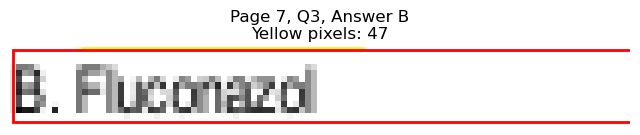

Page 7, Q3 - C: Detected box: x0=71.3, y0=289.7, x1=130.0, y1=301.8
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 277
Page 7, Q3, C: Yellow percentage: 0.0%


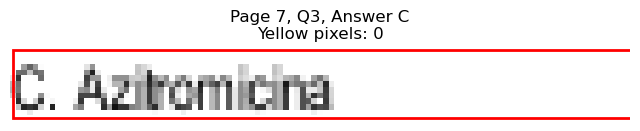

Page 7, Q3 - D: Detected box: x0=322.9, y0=265.7, x1=368.0, y1=277.7
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 221
Page 7, Q3, D: Yellow percentage: 0.0%


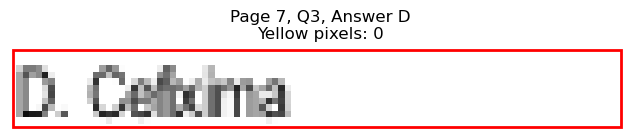

Page 7, Q3 - E: Detected box: x0=322.9, y0=277.7, x1=377.0, y1=289.7
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 248
Page 7, Q3, E: Yellow percentage: 0.0%


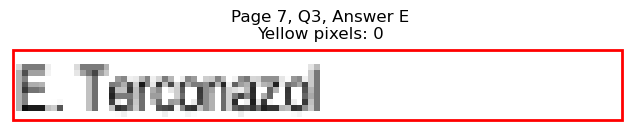


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=146.6, y1=362.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 355
Page 7, Q4, A: Yellow percentage: 0.0%


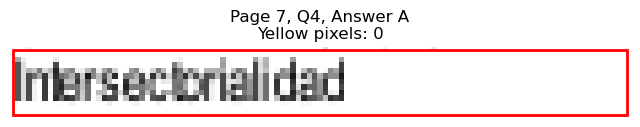

Page 7, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=118.8, y1=374.6
Page 7, Q4, B: Yellow pixels: 407
Page 7, Q4, B: Total non-white pixels: 598
Page 7, Q4, B: Yellow percentage: 68.1%


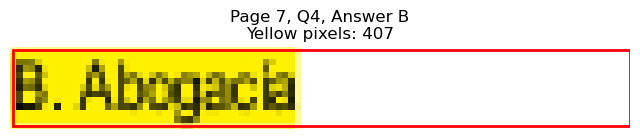

Page 7, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=131.5, y1=386.6
Page 7, Q4, C: Yellow pixels: 45
Page 7, Q4, C: Total non-white pixels: 328
Page 7, Q4, C: Yellow percentage: 13.7%


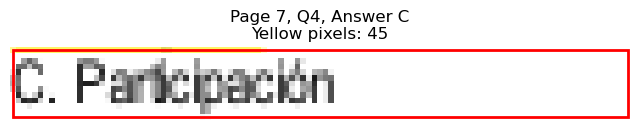

Page 7, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=393.5, y1=362.5
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 355
Page 7, Q4, D: Yellow percentage: 0.0%


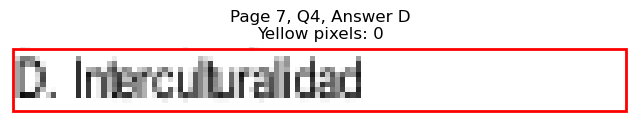

Page 7, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=383.8, y1=374.6
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 297
Page 7, Q4, E: Yellow percentage: 0.0%


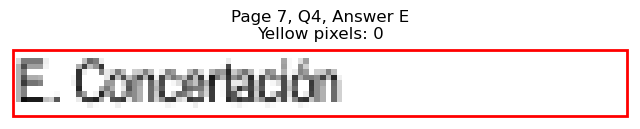


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.6, y0=422.5, x1=167.6, y1=434.6
Page 7, Q5, A: Yellow pixels: 623
Page 7, Q5, A: Total non-white pixels: 1092
Page 7, Q5, A: Yellow percentage: 57.1%


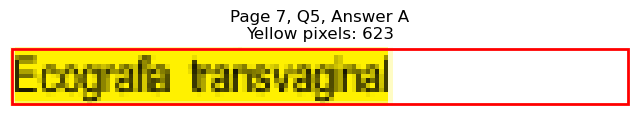

Page 7, Q5 - B: Detected box: x0=71.3, y0=434.6, x1=169.7, y1=446.6
Page 7, Q5, B: Yellow pixels: 82
Page 7, Q5, B: Total non-white pixels: 586
Page 7, Q5, B: Yellow percentage: 14.0%


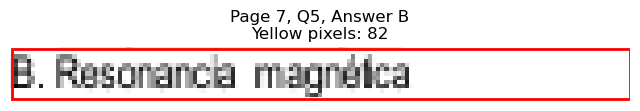

Page 7, Q5 - C: Detected box: x0=71.3, y0=446.6, x1=130.0, y1=458.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 284
Page 7, Q5, C: Yellow percentage: 0.0%


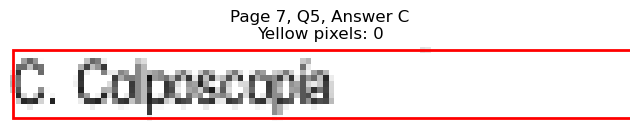

Page 7, Q5 - D: Detected box: x0=322.9, y0=422.5, x1=400.3, y1=434.6
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 421
Page 7, Q5, D: Yellow percentage: 0.0%


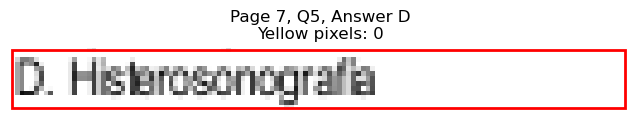

Page 7, Q5 - E: Detected box: x0=322.9, y0=434.6, x1=377.0, y1=446.6
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 264
Page 7, Q5, E: Yellow percentage: 0.0%


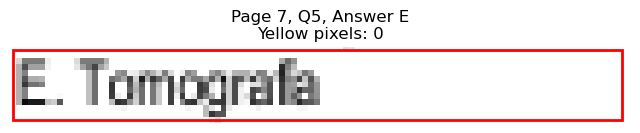


Page 7, Q5 - Selected Answer: A (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.6, y0=495.4, x1=98.5, y1=507.4
Page 7, Q6, A: Yellow pixels: 113
Page 7, Q6, A: Total non-white pixels: 195
Page 7, Q6, A: Yellow percentage: 57.9%


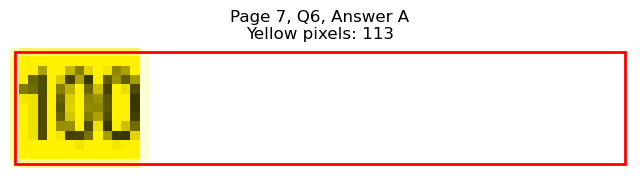

Page 7, Q6 - B: Detected box: x0=71.3, y0=507.4, x1=93.2, y1=519.4
Page 7, Q6, B: Yellow pixels: 13
Page 7, Q6, B: Total non-white pixels: 117
Page 7, Q6, B: Yellow percentage: 11.1%


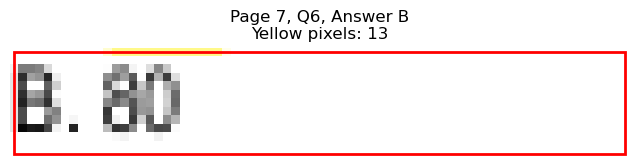

Page 7, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=98.5, y1=531.4
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 99
Page 7, Q6, C: Yellow percentage: 0.0%


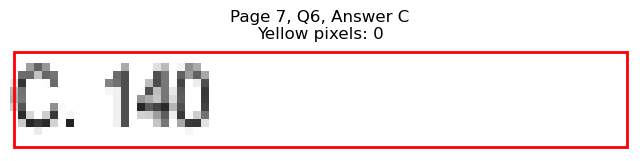

Page 7, Q6 - D: Detected box: x0=322.9, y0=495.4, x1=345.5, y1=507.4
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 101
Page 7, Q6, D: Yellow percentage: 0.0%


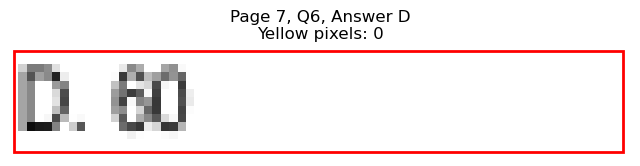

Page 7, Q6 - E: Detected box: x0=322.9, y0=507.4, x1=349.3, y1=519.4
Page 7, Q6, E: Yellow pixels: 0
Page 7, Q6, E: Total non-white pixels: 105
Page 7, Q6, E: Yellow percentage: 0.0%


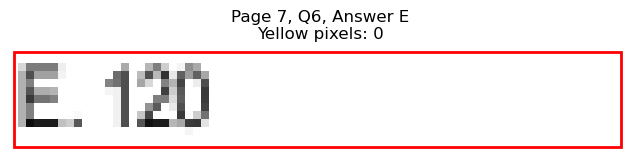


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.6, y0=567.5, x1=121.0, y1=579.5
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 228
Page 7, Q7, A: Yellow percentage: 0.0%


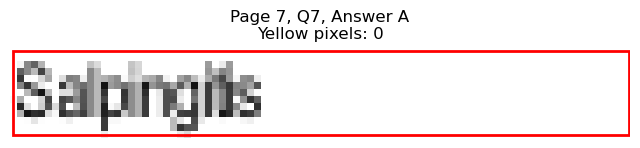

Page 7, Q7 - B: Detected box: x0=71.3, y0=579.4, x1=111.2, y1=591.5
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 206
Page 7, Q7, B: Yellow percentage: 0.0%


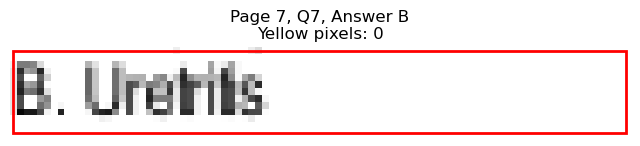

Page 7, Q7 - C: Detected box: x0=71.3, y0=591.5, x1=107.5, y1=603.5
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 166
Page 7, Q7, C: Yellow percentage: 0.0%


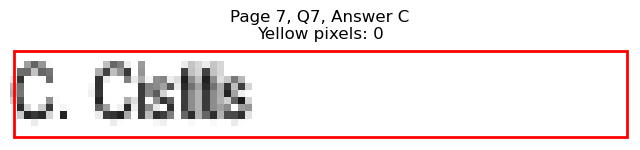

Page 7, Q7 - D: Detected box: x0=322.9, y0=567.5, x1=377.1, y1=579.5
Page 7, Q7, D: Yellow pixels: 443
Page 7, Q7, D: Total non-white pixels: 689
Page 7, Q7, D: Yellow percentage: 64.3%


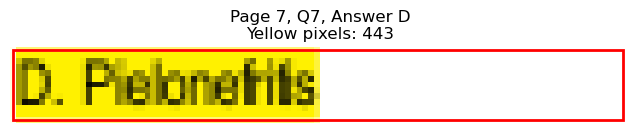

Page 7, Q7 - E: Detected box: x0=322.9, y0=579.4, x1=368.0, y1=591.5
Page 7, Q7, E: Yellow pixels: 51
Page 7, Q7, E: Total non-white pixels: 276
Page 7, Q7, E: Yellow percentage: 18.5%


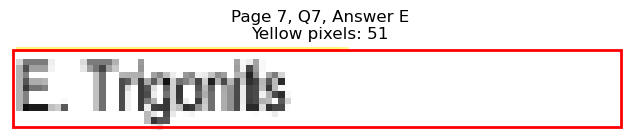


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.6, y0=627.5, x1=217.7, y1=639.6
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 682
Page 7, Q8, A: Yellow percentage: 0.0%


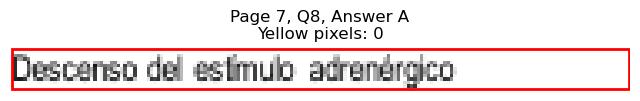

Page 7, Q8 - B: Detected box: x0=120.8, y0=639.5, x1=257.5, y1=651.6
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 702
Page 7, Q8, B: Yellow percentage: 0.0%


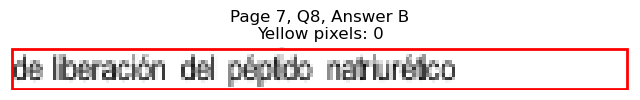

Page 7, Q8 - C: Detected box: x0=322.9, y0=627.5, x1=494.0, y1=639.6
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 859
Page 7, Q8, C: Yellow percentage: 0.0%


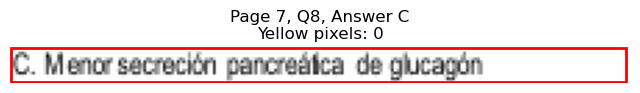

Page 7, Q8 - D: Detected box: x0=322.9, y0=639.5, x1=431.8, y1=651.6
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 715
Page 7, Q8, D: Yellow percentage: 0.0%


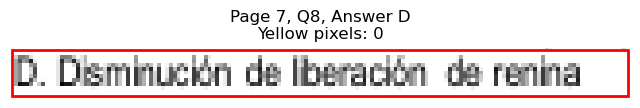

Page 7, Q8 - E: Detected box: x0=322.9, y0=651.5, x1=396.5, y1=663.6
Page 7, Q8, E: Yellow pixels: 1002
Page 7, Q8, E: Total non-white pixels: 1469
Page 7, Q8, E: Yellow percentage: 68.2%


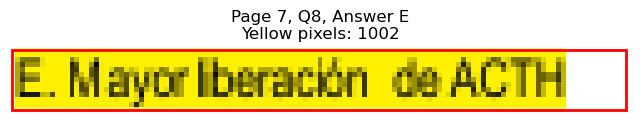


Page 7, Q8 - Selected Answer: E (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=105.3, y1=712.3
Page 7, Q9, A: Yellow pixels: 151
Page 7, Q9, A: Total non-white pixels: 273
Page 7, Q9, A: Yellow percentage: 55.3%


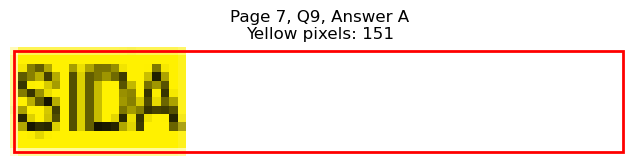

Page 7, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=112.0, y1=724.4
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 220
Page 7, Q9, B: Yellow percentage: 0.0%


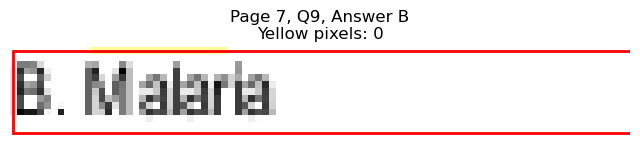

Page 7, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=152.5, y1=736.4
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 370
Page 7, Q9, C: Yellow percentage: 0.0%


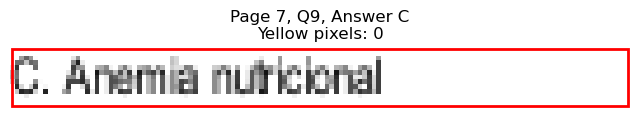

Page 7, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=385.3, y1=712.3
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 323
Page 7, Q9, D: Yellow percentage: 0.0%


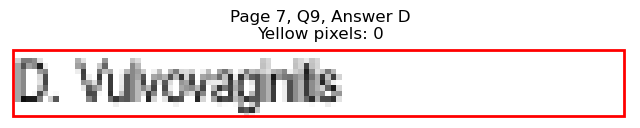

Page 7, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=399.5, y1=724.4
Page 7, Q9, E: Yellow pixels: 0
Page 7, Q9, E: Total non-white pixels: 373
Page 7, Q9, E: Yellow percentage: 0.0%


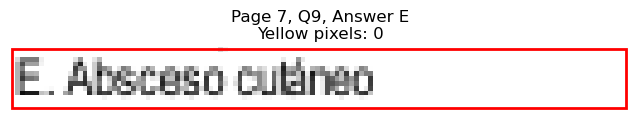


Page 7, Q9 - Selected Answer: A (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=143.5, y1=121.6
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 334
Page 8, Q1, A: Yellow percentage: 0.0%


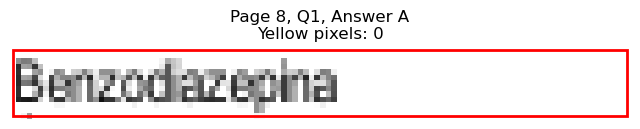

Page 8, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=145.0, y1=133.6
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 390
Page 8, Q1, B: Yellow percentage: 0.0%


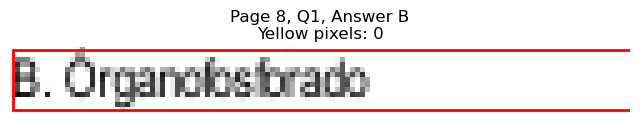

Page 8, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=112.0, y1=145.6
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 176
Page 8, Q1, C: Yellow percentage: 0.0%


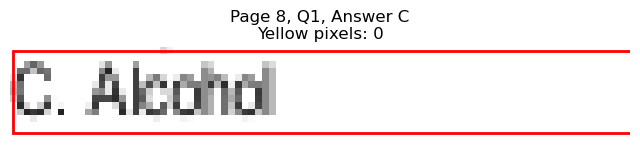

Page 8, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=366.6, y1=121.6
Page 8, Q1, D: Yellow pixels: 364
Page 8, Q1, D: Total non-white pixels: 559
Page 8, Q1, D: Yellow percentage: 65.1%


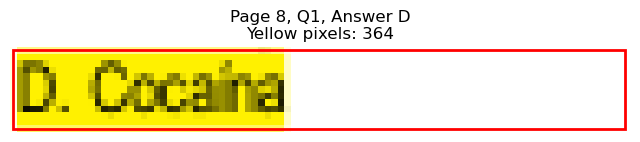

Page 8, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=364.3, y1=133.6
Page 8, Q1, E: Yellow pixels: 41
Page 8, Q1, E: Total non-white pixels: 222
Page 8, Q1, E: Yellow percentage: 18.5%


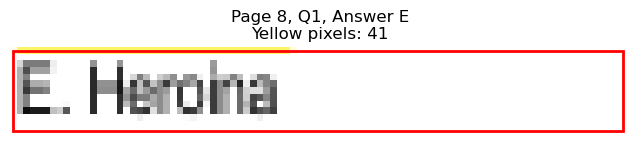


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=148.0, y1=193.6
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 342
Page 8, Q2, A: Yellow percentage: 0.0%


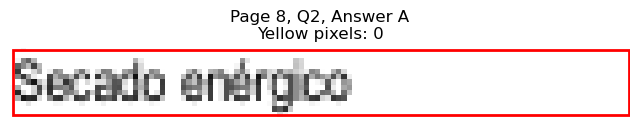

Page 8, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=184.7, y1=205.6
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 560
Page 8, Q2, B: Yellow percentage: 0.0%


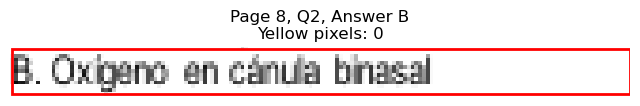

Page 8, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=151.0, y1=217.7
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 380
Page 8, Q2, C: Yellow percentage: 0.0%


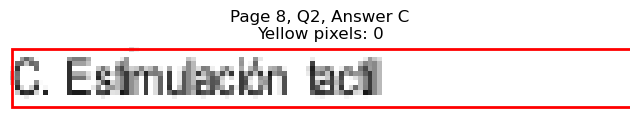

Page 8, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=373.3, y1=193.6
Page 8, Q2, D: Yellow pixels: 804
Page 8, Q2, D: Total non-white pixels: 1326
Page 8, Q2, D: Yellow percentage: 60.6%


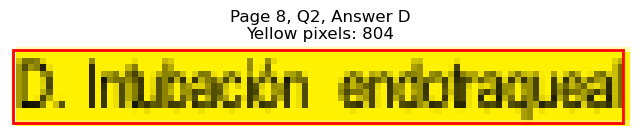

Page 8, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=381.5, y1=205.6
Page 8, Q2, E: Yellow pixels: 109
Page 8, Q2, E: Total non-white pixels: 555
Page 8, Q2, E: Yellow percentage: 19.6%


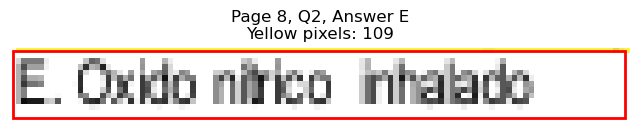


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.6, y0=265.7, x1=138.2, y1=277.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 286
Page 8, Q3, A: Yellow percentage: 0.0%


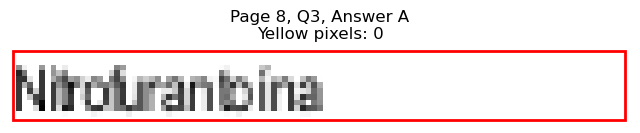

Page 8, Q3 - B: Detected box: x0=71.3, y0=277.7, x1=126.2, y1=289.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 277
Page 8, Q3, B: Yellow percentage: 0.0%


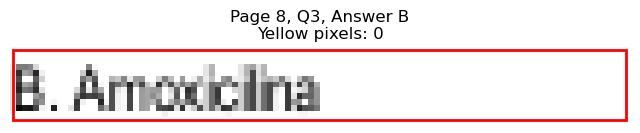

Page 8, Q3 - C: Detected box: x0=71.3, y0=289.7, x1=134.6, y1=301.8
Page 8, Q3, C: Yellow pixels: 500
Page 8, Q3, C: Total non-white pixels: 806
Page 8, Q3, C: Yellow percentage: 62.0%


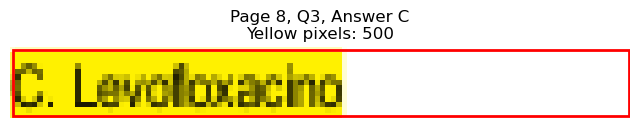

Page 8, Q3 - D: Detected box: x0=322.9, y0=265.7, x1=384.5, y1=277.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 298
Page 8, Q3, D: Yellow percentage: 0.0%


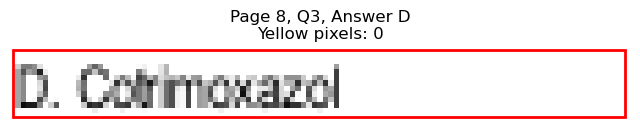

Page 8, Q3 - E: Detected box: x0=322.9, y0=277.7, x1=377.8, y1=289.7
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 264
Page 8, Q3, E: Yellow percentage: 0.0%


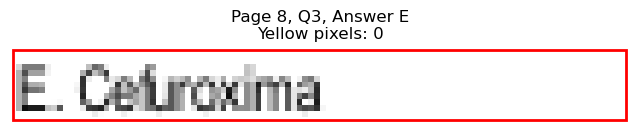


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=126.2, y1=362.5
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 224
Page 8, Q4, A: Yellow percentage: 0.0%


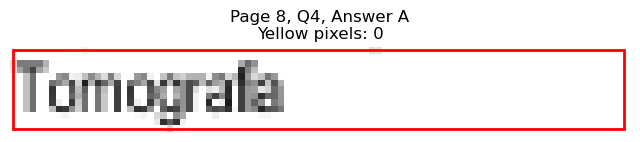

Page 8, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=133.7, y1=374.6
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 325
Page 8, Q4, B: Yellow percentage: 0.0%


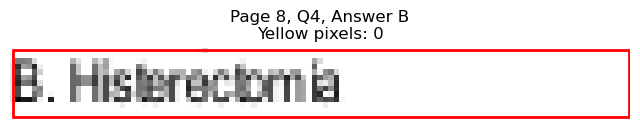

Page 8, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=134.5, y1=386.6
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 289
Page 8, Q4, C: Yellow percentage: 0.0%


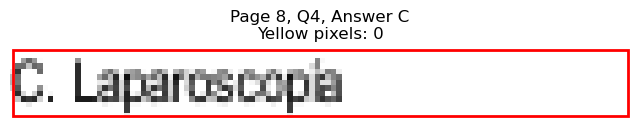

Page 8, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=381.6, y1=362.5
Page 8, Q4, D: Yellow pixels: 497
Page 8, Q4, D: Total non-white pixels: 754
Page 8, Q4, D: Yellow percentage: 65.9%


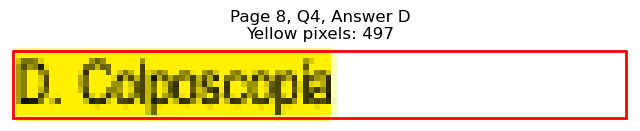

Page 8, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=376.3, y1=374.6
Page 8, Q4, E: Yellow pixels: 56
Page 8, Q4, E: Total non-white pixels: 305
Page 8, Q4, E: Yellow percentage: 18.4%


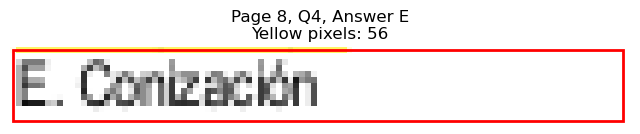


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=155.6, y1=422.6
Page 8, Q5, A: Yellow pixels: 545
Page 8, Q5, A: Total non-white pixels: 939
Page 8, Q5, A: Yellow percentage: 58.0%


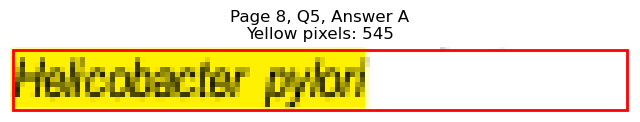

Page 8, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=140.5, y1=434.6
Page 8, Q5, B: Yellow pixels: 70
Page 8, Q5, B: Total non-white pixels: 425
Page 8, Q5, B: Yellow percentage: 16.5%


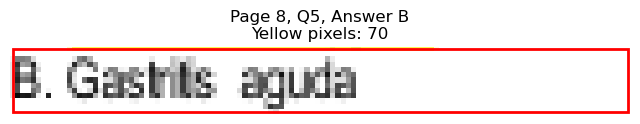

Page 8, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=142.7, y1=446.6
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 316
Page 8, Q5, C: Yellow percentage: 0.0%


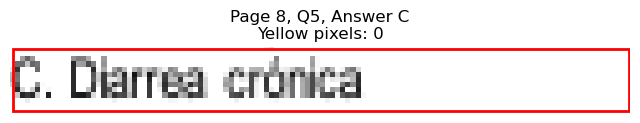

Page 8, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=392.9, y1=422.6
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 351
Page 8, Q5, D: Yellow percentage: 0.0%


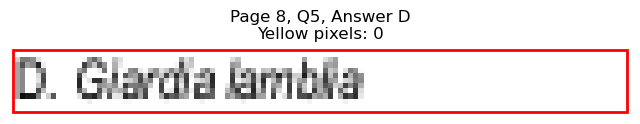

Page 8, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=370.3, y1=434.6
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 382
Page 8, Q5, E: Yellow percentage: 0.0%


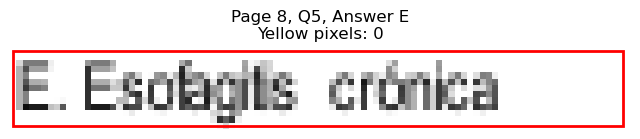


Page 8, Q5 - Selected Answer: A (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.6, y0=483.4, x1=193.0, y1=495.4
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 703
Page 8, Q6, A: Yellow percentage: 0.0%


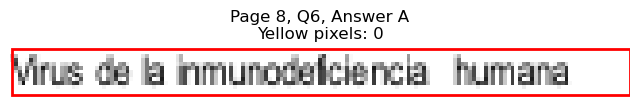

Page 8, Q6 - B: Detected box: x0=71.3, y0=495.4, x1=183.4, y1=507.4
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 541
Page 8, Q6, B: Yellow percentage: 0.0%


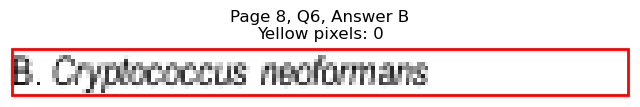

Page 8, Q6 - C: Detected box: x0=71.3, y0=507.4, x1=190.9, y1=519.4
Page 8, Q6, C: Yellow pixels: 1060
Page 8, Q6, C: Total non-white pixels: 1534
Page 8, Q6, C: Yellow percentage: 69.1%


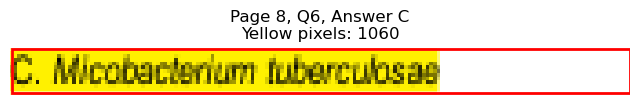

Page 8, Q6 - D: Detected box: x0=322.9, y0=483.4, x1=431.2, y1=495.4
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 518
Page 8, Q6, D: Yellow percentage: 0.0%


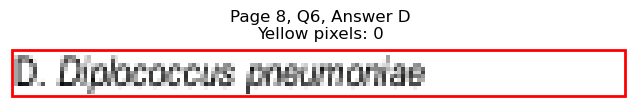

Page 8, Q6 - E: Detected box: x0=322.9, y0=495.4, x1=398.9, y1=507.4
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 391
Page 8, Q6, E: Yellow percentage: 0.0%


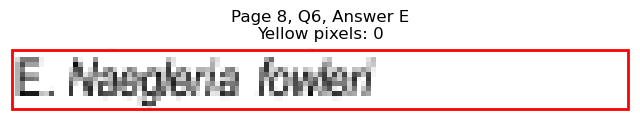


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.6, y0=555.4, x1=187.9, y1=567.5
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 559
Page 8, Q7, A: Yellow percentage: 0.0%


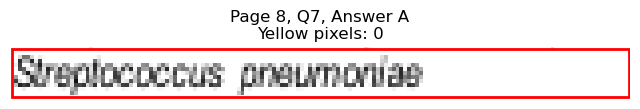

Page 8, Q7 - B: Detected box: x0=71.3, y0=567.5, x1=142.8, y1=579.5
Page 8, Q7, B: Yellow pixels: 905
Page 8, Q7, B: Total non-white pixels: 1300
Page 8, Q7, B: Yellow percentage: 69.6%


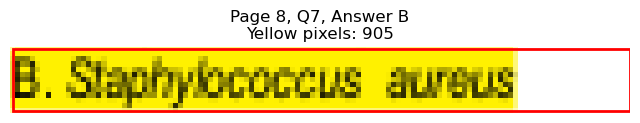

Page 8, Q7 - C: Detected box: x0=71.3, y0=579.4, x1=172.1, y1=591.5
Page 8, Q7, C: Yellow pixels: 98
Page 8, Q7, C: Total non-white pixels: 592
Page 8, Q7, C: Yellow percentage: 16.6%


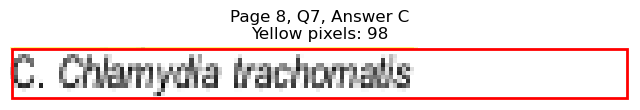

Page 8, Q7 - D: Detected box: x0=322.9, y0=555.4, x1=432.7, y1=567.5
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 558
Page 8, Q7, D: Yellow percentage: 0.0%


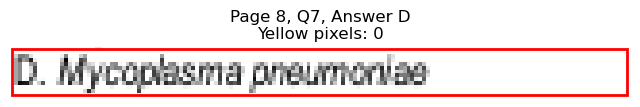

Page 8, Q7 - E: Detected box: x0=322.9, y0=567.5, x1=383.9, y1=579.5
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 307
Page 8, Q7, E: Yellow percentage: 0.0%


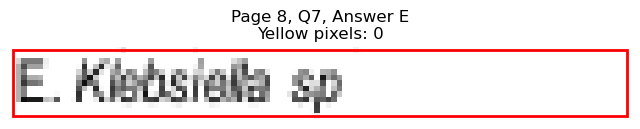


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=71.3, y0=639.5, x1=79.7, y1=651.6
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 66
Page 8, Q8, A: Yellow percentage: 0.0%


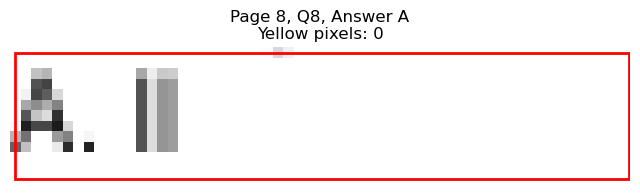

Page 8, Q8 - B: Detected box: x0=71.3, y0=651.5, x1=91.7, y1=663.6
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 86
Page 8, Q8, B: Yellow percentage: 0.0%


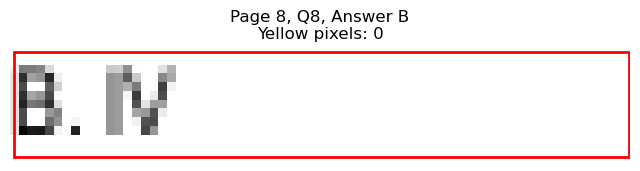

Page 8, Q8 - C: Detected box: x0=71.3, y0=663.5, x1=90.2, y1=675.6
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 57
Page 8, Q8, C: Yellow percentage: 0.0%


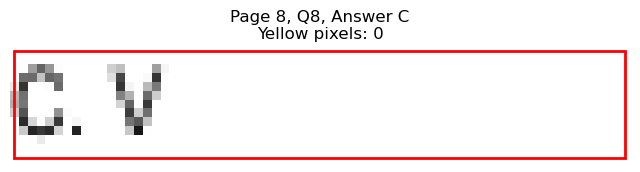

Page 8, Q8 - D: Detected box: x0=322.9, y0=639.5, x1=338.8, y1=651.6
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 48
Page 8, Q8, D: Yellow percentage: 0.0%


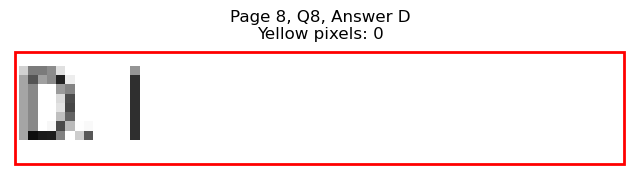

Page 8, Q8 - E: Detected box: x0=322.9, y0=651.5, x1=342.6, y1=663.6
Page 8, Q8, E: Yellow pixels: 148
Page 8, Q8, E: Total non-white pixels: 247
Page 8, Q8, E: Yellow percentage: 59.9%


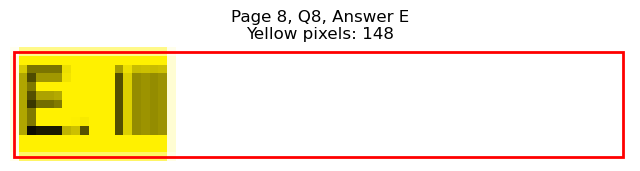


Page 8, Q8 - Selected Answer: E (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=193.0, y1=712.3
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 539
Page 8, Q9, A: Yellow percentage: 0.0%


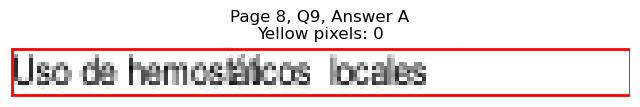

Page 8, Q9 - B: Detected box: x0=136.7, y0=712.3, x1=223.9, y1=724.4
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 431
Page 8, Q9, B: Yellow percentage: 0.0%


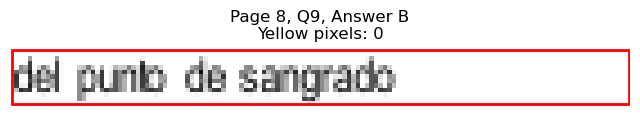

Page 8, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=153.2, y1=736.4
Page 8, Q9, C: Yellow pixels: 1056
Page 8, Q9, C: Total non-white pixels: 1729
Page 8, Q9, C: Yellow percentage: 61.1%


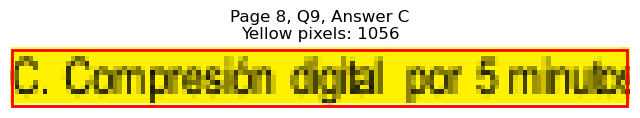

Page 8, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=388.3, y1=712.3
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 561
Page 8, Q9, D: Yellow percentage: 0.0%


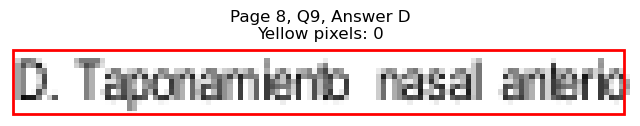

Page 8, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=422.3, y1=724.4
Page 8, Q9, E: Yellow pixels: 0
Page 8, Q9, E: Total non-white pixels: 458
Page 8, Q9, E: Yellow percentage: 0.0%


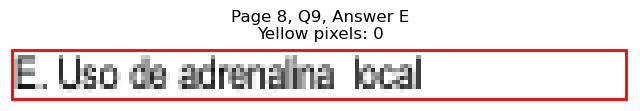


Page 8, Q9 - Selected Answer: C (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=112.8, y1=133.6
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 156
Page 9, Q1, A: Yellow percentage: 0.0%


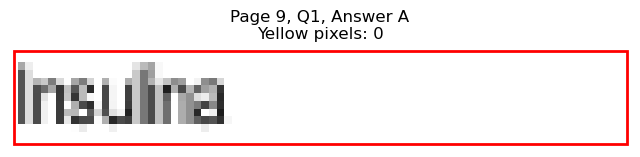

Page 9, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=125.5, y1=145.6
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 268
Page 9, Q1, B: Yellow percentage: 0.0%


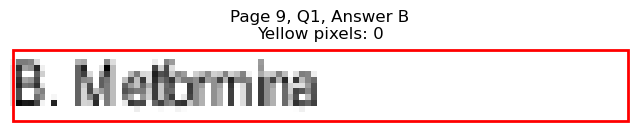

Page 9, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=116.5, y1=157.6
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 205
Page 9, Q1, C: Yellow percentage: 0.0%


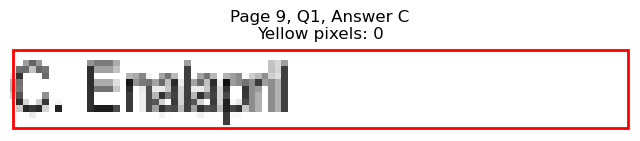

Page 9, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=396.6, y1=133.6
Page 9, Q1, D: Yellow pixels: 611
Page 9, Q1, D: Total non-white pixels: 949
Page 9, Q1, D: Yellow percentage: 64.4%


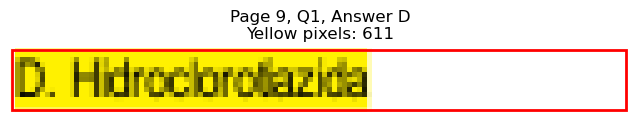

Page 9, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=379.3, y1=145.6
Page 9, Q1, E: Yellow pixels: 71
Page 9, Q1, E: Total non-white pixels: 329
Page 9, Q1, E: Yellow percentage: 21.6%


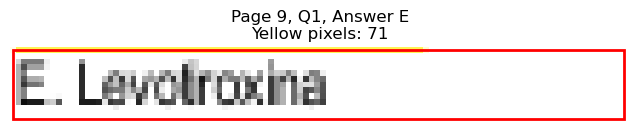


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.6, y0=205.6, x1=113.5, y1=217.7
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 163
Page 9, Q2, A: Yellow percentage: 0.0%


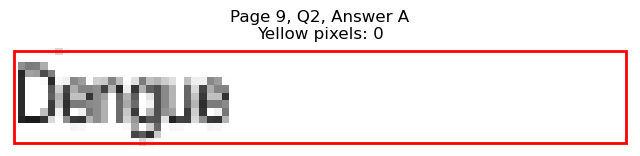

Page 9, Q2 - B: Detected box: x0=71.3, y0=217.6, x1=123.2, y1=229.7
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 255
Page 9, Q2, B: Yellow percentage: 0.0%


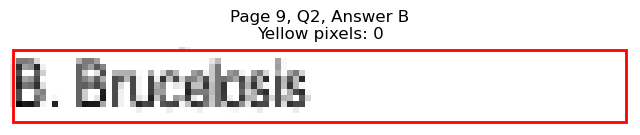

Page 9, Q2 - C: Detected box: x0=71.3, y0=229.6, x1=124.0, y1=241.7
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 236
Page 9, Q2, C: Yellow percentage: 0.0%


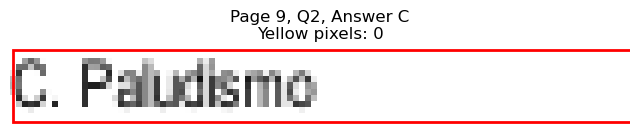

Page 9, Q2 - D: Detected box: x0=322.9, y0=205.6, x1=402.6, y1=217.7
Page 9, Q2, D: Yellow pixels: 597
Page 9, Q2, D: Total non-white pixels: 1027
Page 9, Q2, D: Yellow percentage: 58.1%


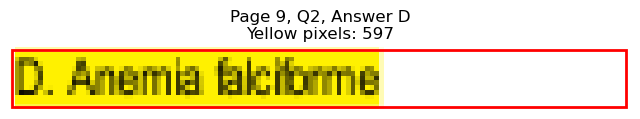

Page 9, Q2 - E: Detected box: x0=322.9, y0=217.6, x1=383.8, y1=229.7
Page 9, Q2, E: Yellow pixels: 77
Page 9, Q2, E: Total non-white pixels: 365
Page 9, Q2, E: Yellow percentage: 21.1%


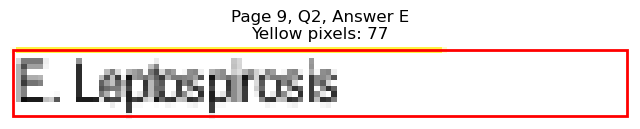


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.6, y0=277.7, x1=196.0, y1=289.7
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 604
Page 9, Q3, A: Yellow percentage: 0.0%


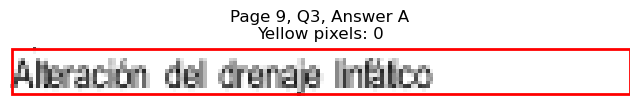

Page 9, Q3 - B: Detected box: x0=71.3, y0=289.7, x1=202.7, y1=301.8
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 651
Page 9, Q3, B: Yellow percentage: 0.0%


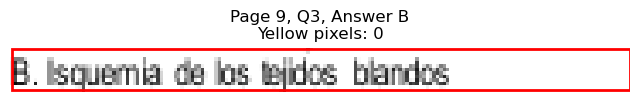

Page 9, Q3 - C: Detected box: x0=71.3, y0=302.5, x1=148.8, y1=314.5
Page 9, Q3, C: Yellow pixels: 692
Page 9, Q3, C: Total non-white pixels: 990
Page 9, Q3, C: Yellow percentage: 69.9%


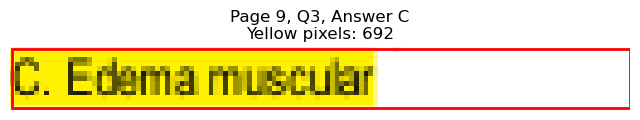

Page 9, Q3 - D: Detected box: x0=322.9, y0=277.7, x1=378.5, y1=289.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 440
Page 9, Q3, D: Yellow percentage: 0.0%


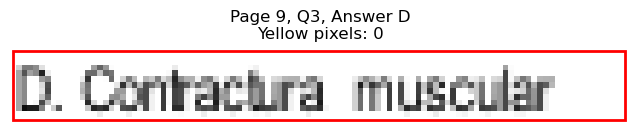

Page 9, Q3 - E: Detected box: x0=322.9, y0=289.7, x1=397.3, y1=301.8
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 353
Page 9, Q3, E: Yellow percentage: 0.0%


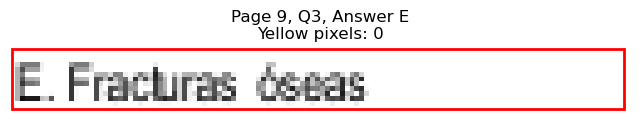


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=107.5, y1=362.5
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 123
Page 9, Q4, A: Yellow percentage: 0.0%


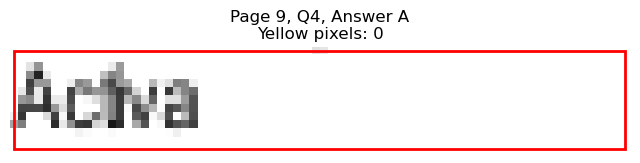

Page 9, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=117.2, y1=374.6
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 233
Page 9, Q4, B: Yellow percentage: 0.0%


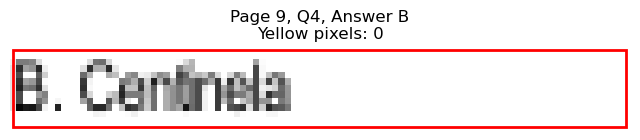

Page 9, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=110.5, y1=386.6
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 156
Page 9, Q4, C: Yellow percentage: 0.0%


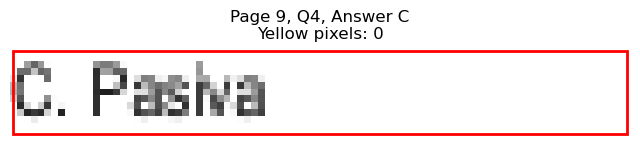

Page 9, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=378.5, y1=362.5
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 255
Page 9, Q4, D: Yellow percentage: 0.0%


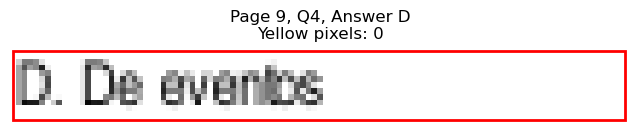

Page 9, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=356.1, y1=374.6
Page 9, Q4, E: Yellow pixels: 275
Page 9, Q4, E: Total non-white pixels: 416
Page 9, Q4, E: Yellow percentage: 66.1%


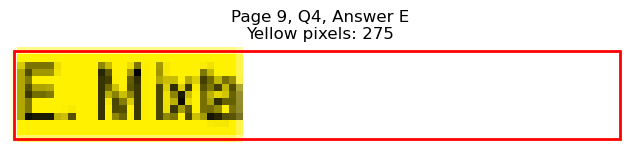


Page 9, Q4 - Selected Answer: E (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.6, y0=434.6, x1=108.3, y1=446.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 133
Page 9, Q5, A: Yellow percentage: 0.0%


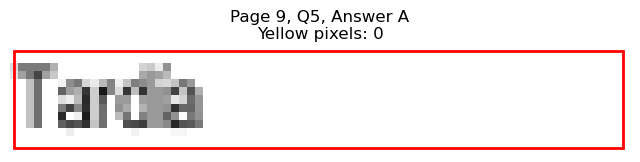

Page 9, Q5 - B: Detected box: x0=71.3, y0=446.6, x1=115.0, y1=458.6
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 223
Page 9, Q5, B: Yellow percentage: 0.0%


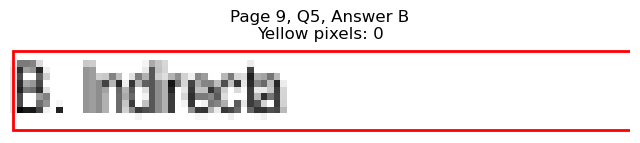

Page 9, Q5 - C: Detected box: x0=71.3, y0=458.6, x1=116.4, y1=470.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 192
Page 9, Q5, C: Yellow percentage: 0.0%


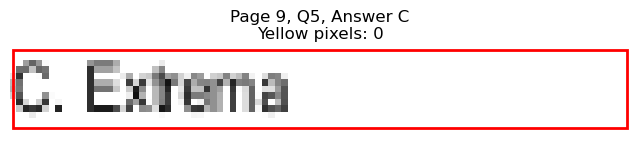

Page 9, Q5 - D: Detected box: x0=322.9, y0=434.6, x1=374.8, y1=446.6
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 237
Page 9, Q5, D: Yellow percentage: 0.0%


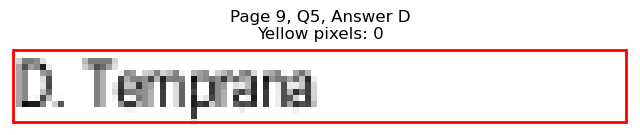

Page 9, Q5 - E: Detected box: x0=322.9, y0=446.6, x1=361.3, y1=458.6
Page 9, Q5, E: Yellow pixels: 276
Page 9, Q5, E: Total non-white pixels: 481
Page 9, Q5, E: Yellow percentage: 57.4%


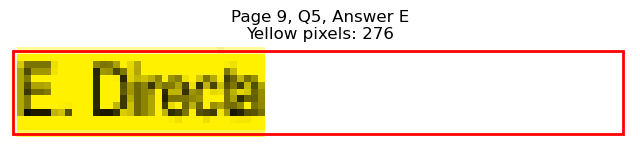


Page 9, Q5 - Selected Answer: E (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.6, y0=519.4, x1=135.2, y1=531.4
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 274
Page 9, Q6, A: Yellow percentage: 0.0%


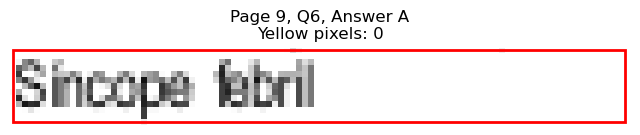

Page 9, Q6 - B: Detected box: x0=71.3, y0=531.4, x1=183.3, y1=543.5
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 554
Page 9, Q6, B: Yellow percentage: 0.0%


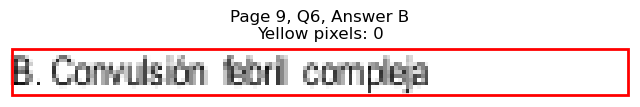

Page 9, Q6 - C: Detected box: x0=71.3, y0=543.4, x1=147.2, y1=555.5
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 382
Page 9, Q6, C: Yellow percentage: 0.0%


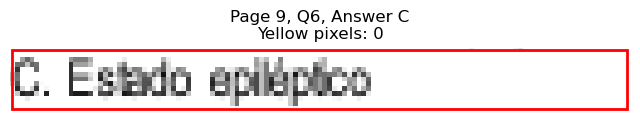

Page 9, Q6 - D: Detected box: x0=322.9, y0=519.4, x1=431.0, y1=531.4
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 551
Page 9, Q6, D: Yellow percentage: 0.0%


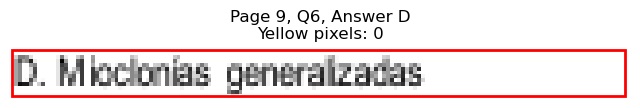

Page 9, Q6 - E: Detected box: x0=322.9, y0=531.4, x1=425.9, y1=543.5
Page 9, Q6, E: Yellow pixels: 908
Page 9, Q6, E: Total non-white pixels: 1326
Page 9, Q6, E: Yellow percentage: 68.5%


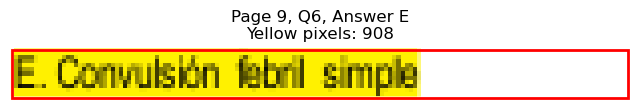


Page 9, Q6 - Selected Answer: E (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.6, y0=579.4, x1=134.5, y1=591.5
Page 9, Q7, A: Yellow pixels: 570
Page 9, Q7, A: Total non-white pixels: 859
Page 9, Q7, A: Yellow percentage: 66.4%


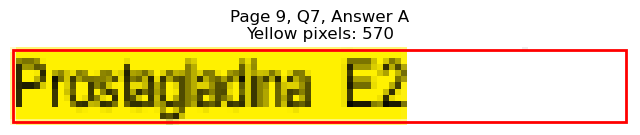

Page 9, Q7 - B: Detected box: x0=71.3, y0=591.5, x1=133.7, y1=603.5
Page 9, Q7, B: Yellow pixels: 65
Page 9, Q7, B: Total non-white pixels: 449
Page 9, Q7, B: Yellow percentage: 14.5%


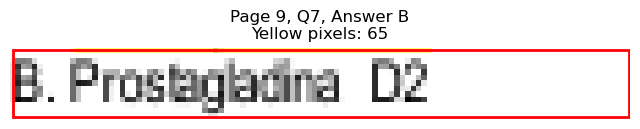

Page 9, Q7 - C: Detected box: x0=71.3, y0=603.5, x1=195.3, y1=615.5
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 602
Page 9, Q7, C: Yellow percentage: 0.0%


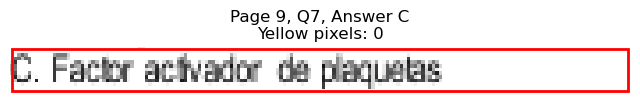

Page 9, Q7 - D: Detected box: x0=322.9, y0=579.4, x1=372.5, y1=591.5
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 244
Page 9, Q7, D: Yellow percentage: 0.0%


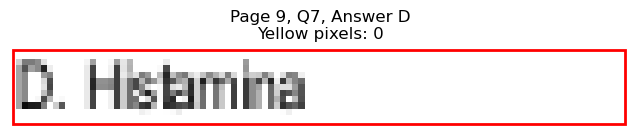

Page 9, Q7 - E: Detected box: x0=322.9, y0=591.5, x1=377.8, y1=603.5
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 308
Page 9, Q7, E: Yellow percentage: 0.0%


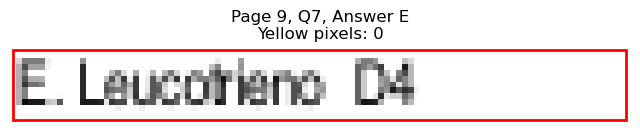


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.6, y0=639.5, x1=132.2, y1=651.6
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 263
Page 9, Q8, A: Yellow percentage: 0.0%


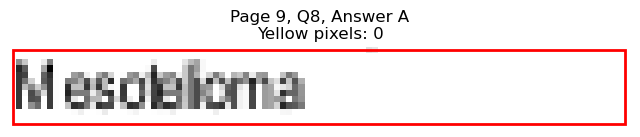

Page 9, Q8 - B: Detected box: x0=71.3, y0=651.5, x1=124.0, y1=663.6
Page 9, Q8, B: Yellow pixels: 443
Page 9, Q8, B: Total non-white pixels: 663
Page 9, Q8, B: Yellow percentage: 66.8%


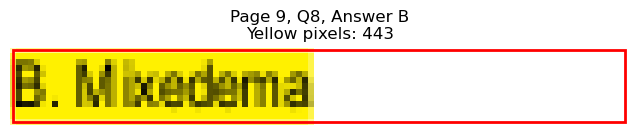

Page 9, Q8 - C: Detected box: x0=71.3, y0=663.5, x1=160.7, y1=675.6
Page 9, Q8, C: Yellow pixels: 51
Page 9, Q8, C: Total non-white pixels: 497
Page 9, Q8, C: Yellow percentage: 10.3%


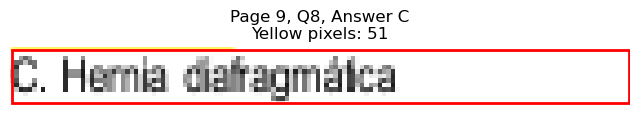

Page 9, Q8 - D: Detected box: x0=322.9, y0=639.5, x1=444.6, y1=651.6
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 610
Page 9, Q8, D: Yellow percentage: 0.0%


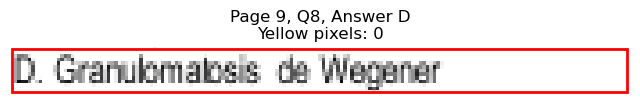

Page 9, Q8 - E: Detected box: x0=322.9, y0=651.5, x1=404.0, y1=663.6
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 587
Page 9, Q8, E: Yellow percentage: 0.0%


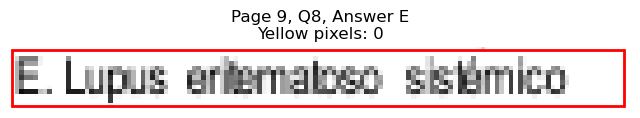


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=150.1, y0=736.4, x1=236.7, y1=748.4
Page 9, Q9, A: Yellow pixels: 737
Page 9, Q9, A: Total non-white pixels: 1109
Page 9, Q9, A: Yellow percentage: 66.5%


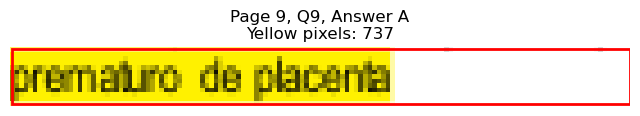

Page 9, Q9 - B: Detected box: x0=71.3, y0=748.4, x1=128.5, y1=760.4
Page 9, Q9, B: Yellow pixels: 96
Page 9, Q9, B: Total non-white pixels: 371
Page 9, Q9, B: Yellow percentage: 25.9%


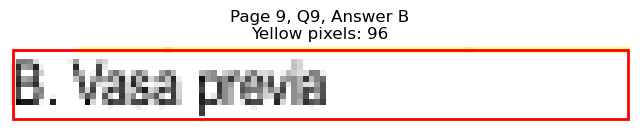

Page 9, Q9 - C: Detected box: x0=71.3, y0=760.4, x1=142.0, y1=772.4
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 326
Page 9, Q9, C: Yellow percentage: 0.0%


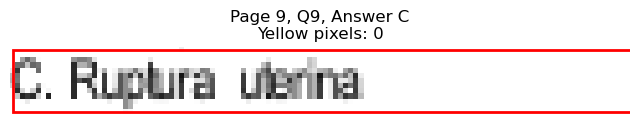

Page 9, Q9 - D: Detected box: x0=322.9, y0=736.4, x1=435.6, y1=748.4
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 567
Page 9, Q9, D: Yellow percentage: 0.0%


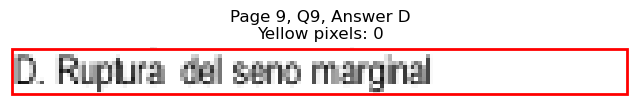

Page 9, Q9 - E: Detected box: x0=322.9, y0=748.4, x1=397.4, y1=760.4
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 347
Page 9, Q9, E: Yellow percentage: 0.0%


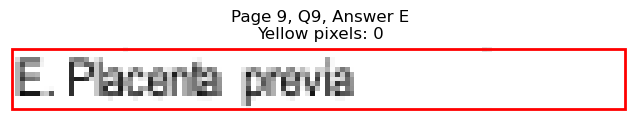


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=168.3, y1=108.8
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 445
Page 10, Q1, A: Yellow percentage: 0.0%


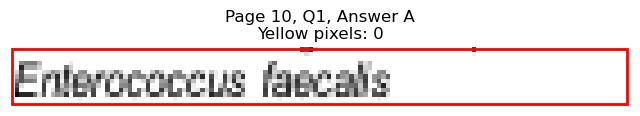

Page 10, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=169.1, y1=121.6
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 492
Page 10, Q1, B: Yellow percentage: 0.0%


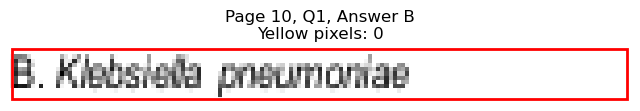

Page 10, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=154.8, y1=133.6
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 390
Page 10, Q1, C: Yellow percentage: 0.0%


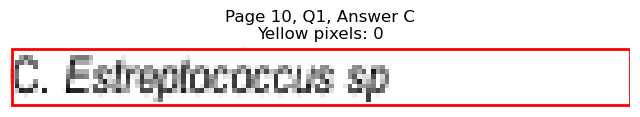

Page 10, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=424.4, y1=108.8
Page 10, Q1, D: Yellow pixels: 801
Page 10, Q1, D: Total non-white pixels: 1312
Page 10, Q1, D: Yellow percentage: 61.1%


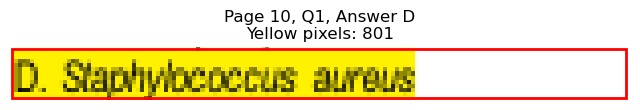

Page 10, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=400.4, y1=121.6
Page 10, Q1, E: Yellow pixels: 99
Page 10, Q1, E: Total non-white pixels: 470
Page 10, Q1, E: Yellow percentage: 21.1%


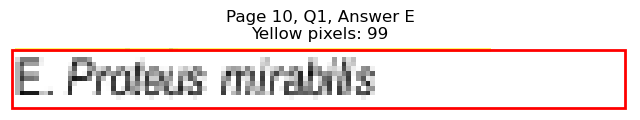


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=155.5, y1=193.6
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 362
Page 10, Q2, A: Yellow percentage: 0.0%


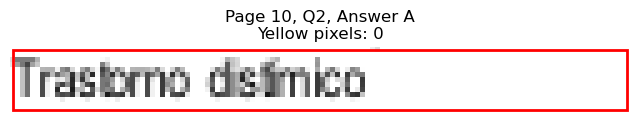

Page 10, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=129.2, y1=205.6
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 282
Page 10, Q2, B: Yellow percentage: 0.0%


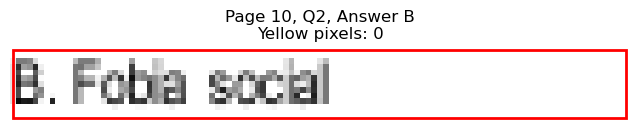

Page 10, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=165.2, y1=217.7
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 457
Page 10, Q2, C: Yellow percentage: 0.0%


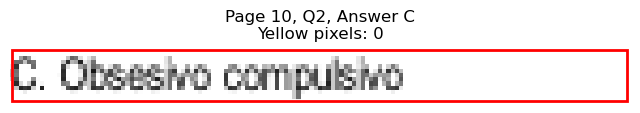

Page 10, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=401.9, y1=193.6
Page 10, Q2, D: Yellow pixels: 620
Page 10, Q2, D: Total non-white pixels: 1016
Page 10, Q2, D: Yellow percentage: 61.0%


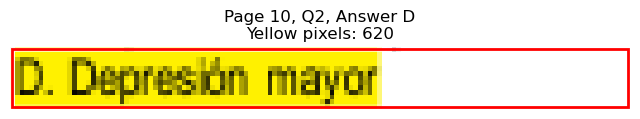

Page 10, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=420.5, y1=205.6
Page 10, Q2, E: Yellow pixels: 76
Page 10, Q2, E: Total non-white pixels: 592
Page 10, Q2, E: Yellow percentage: 12.8%


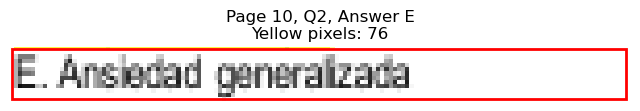


Page 10, Q2 - Selected Answer: D (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=177.3, y1=253.7
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 502
Page 10, Q3, A: Yellow percentage: 0.0%


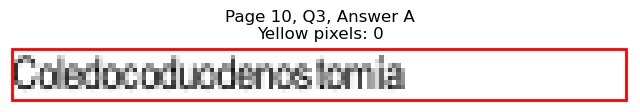

Page 10, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=190.7, y1=265.7
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 555
Page 10, Q3, B: Yellow percentage: 0.0%


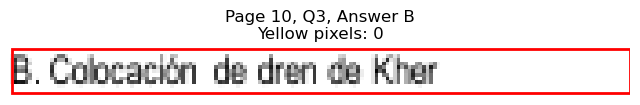

Page 10, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=162.2, y1=277.7
Page 10, Q3, C: Yellow pixels: 1163
Page 10, Q3, C: Total non-white pixels: 1846
Page 10, Q3, C: Yellow percentage: 63.0%


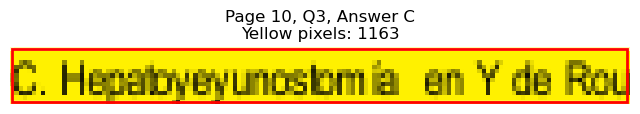

Page 10, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=484.5, y1=253.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 791
Page 10, Q3, D: Yellow percentage: 0.0%


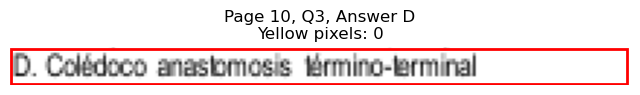

Page 10, Q3 - E: Detected box: x0=373.9, y0=253.6, x1=487.3, y1=265.7
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 567
Page 10, Q3, E: Yellow percentage: 0.0%


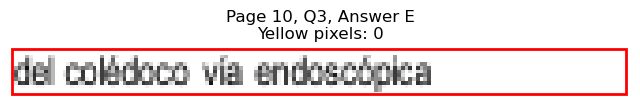


Page 10, Q3 - Selected Answer: C (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=124.0, y1=314.5
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 210
Page 10, Q4, A: Yellow percentage: 0.0%


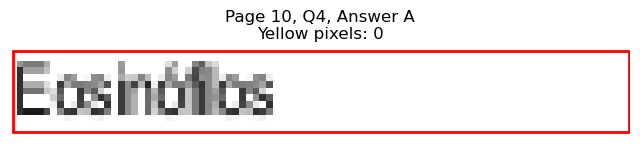

Page 10, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=118.7, y1=326.5
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 246
Page 10, Q4, B: Yellow percentage: 0.0%


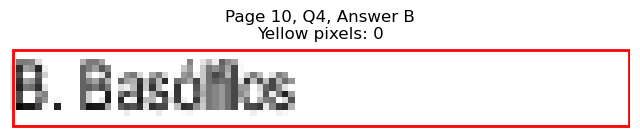

Page 10, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=123.2, y1=338.5
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 222
Page 10, Q4, C: Yellow percentage: 0.0%


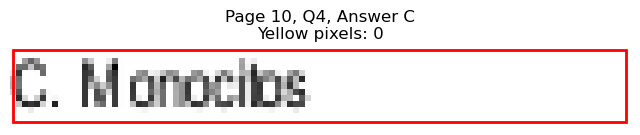

Page 10, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=374.1, y1=314.5
Page 10, Q4, D: Yellow pixels: 433
Page 10, Q4, D: Total non-white pixels: 650
Page 10, Q4, D: Yellow percentage: 66.6%


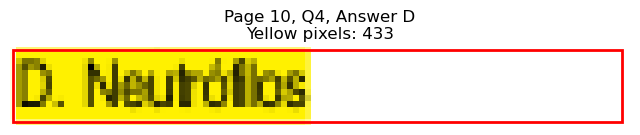

Page 10, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=368.8, y1=326.5
Page 10, Q4, E: Yellow pixels: 48
Page 10, Q4, E: Total non-white pixels: 257
Page 10, Q4, E: Yellow percentage: 18.7%


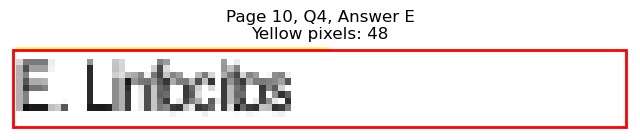


Page 10, Q4 - Selected Answer: D (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=125.5, y1=398.6
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 444
Page 10, Q5, A: Yellow percentage: 0.0%


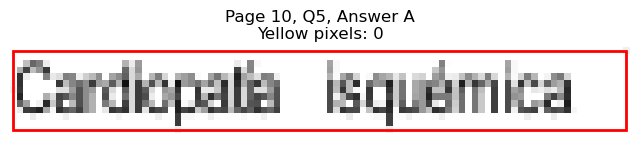

Page 10, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=121.7, y1=410.6
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 454
Page 10, Q5, B: Yellow percentage: 0.0%


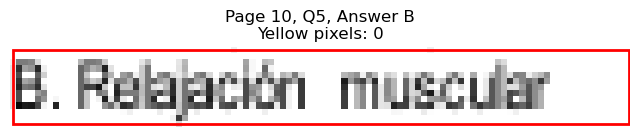

Page 10, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=127.0, y1=422.6
Page 10, Q5, C: Yellow pixels: 648
Page 10, Q5, C: Total non-white pixels: 1092
Page 10, Q5, C: Yellow percentage: 59.3%


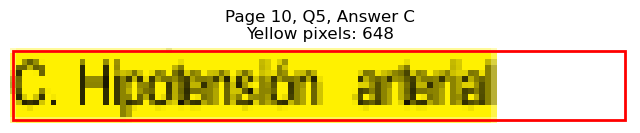

Page 10, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=411.5, y1=398.6
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 443
Page 10, Q5, D: Yellow percentage: 0.0%


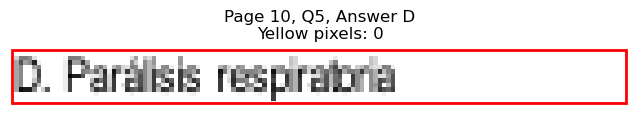

Page 10, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=362.8, y1=410.6
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 347
Page 10, Q5, E: Yellow percentage: 0.0%


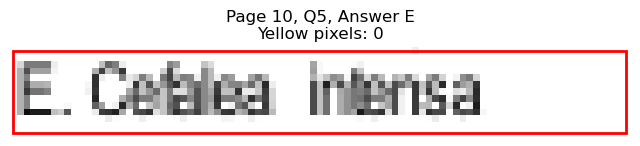


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.6, y0=458.6, x1=162.2, y1=470.6
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 415
Page 10, Q6, A: Yellow percentage: 0.0%


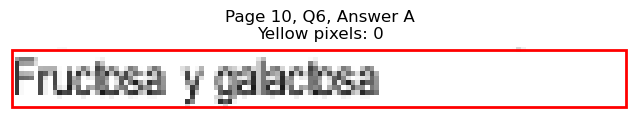

Page 10, Q6 - B: Detected box: x0=71.3, y0=470.6, x1=159.9, y1=482.6
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 422
Page 10, Q6, B: Yellow percentage: 0.0%


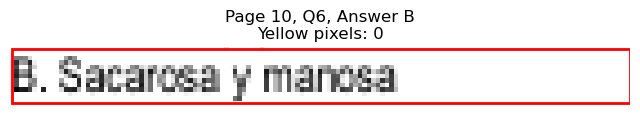

Page 10, Q6 - C: Detected box: x0=71.3, y0=483.4, x1=153.2, y1=495.4
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 368
Page 10, Q6, C: Yellow percentage: 0.0%


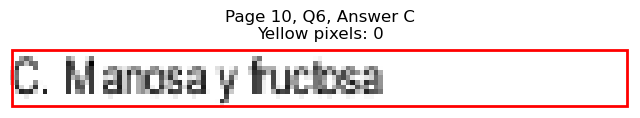

Page 10, Q6 - D: Detected box: x0=322.9, y0=458.6, x1=413.2, y1=470.6
Page 10, Q6, D: Yellow pixels: 710
Page 10, Q6, D: Total non-white pixels: 1157
Page 10, Q6, D: Yellow percentage: 61.4%


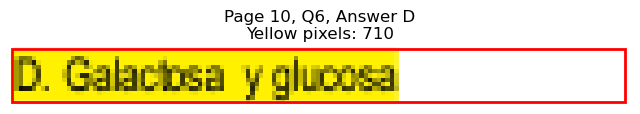

Page 10, Q6 - E: Detected box: x0=322.9, y0=470.6, x1=406.3, y1=482.6
Page 10, Q6, E: Yellow pixels: 88
Page 10, Q6, E: Total non-white pixels: 484
Page 10, Q6, E: Yellow percentage: 18.2%


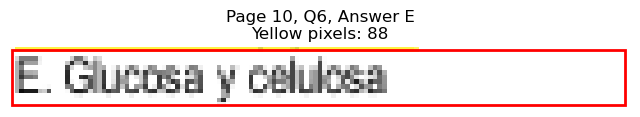


Page 10, Q6 - Selected Answer: D (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.6, y0=543.4, x1=151.1, y1=555.5
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 355
Page 10, Q7, A: Yellow percentage: 0.0%


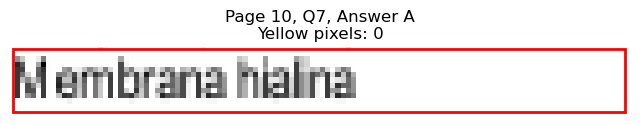

Page 10, Q7 - B: Detected box: x0=71.3, y0=555.4, x1=122.5, y1=567.5
Page 10, Q7, B: Yellow pixels: 790
Page 10, Q7, B: Total non-white pixels: 1157
Page 10, Q7, B: Yellow percentage: 68.3%


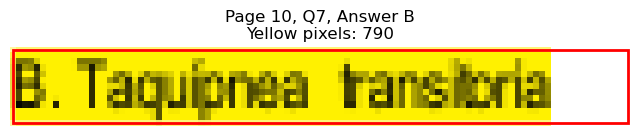

Page 10, Q7 - C: Detected box: x0=71.3, y0=567.5, x1=161.5, y1=579.5
Page 10, Q7, C: Yellow pixels: 88
Page 10, Q7, C: Total non-white pixels: 514
Page 10, Q7, C: Yellow percentage: 17.1%


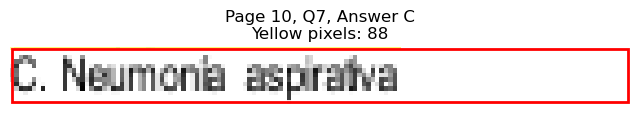

Page 10, Q7 - D: Detected box: x0=322.9, y0=543.4, x1=462.5, y1=555.5
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 676
Page 10, Q7, D: Yellow percentage: 0.0%


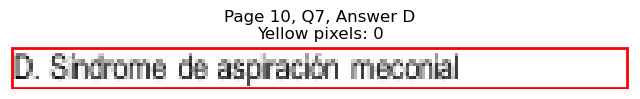

Page 10, Q7 - E: Detected box: x0=322.9, y0=555.4, x1=433.3, y1=567.5
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 547
Page 10, Q7, E: Yellow percentage: 0.0%


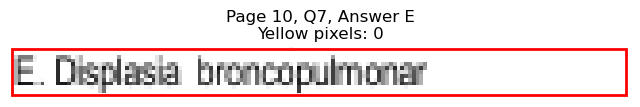


Page 10, Q7 - Selected Answer: B (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.6, y0=639.5, x1=180.9, y1=651.6
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 480
Page 10, Q8, A: Yellow percentage: 0.0%


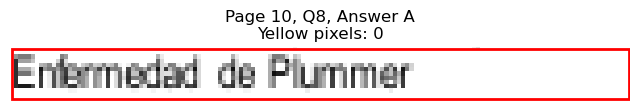

Page 10, Q8 - B: Detected box: x0=116.3, y0=651.5, x1=169.7, y1=663.6
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 273
Page 10, Q8, B: Yellow percentage: 0.0%


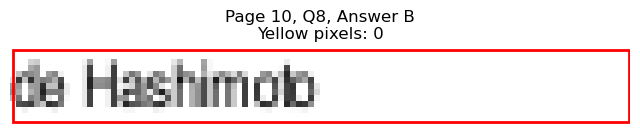

Page 10, Q8 - C: Detected box: x0=71.3, y0=663.5, x1=145.0, y1=675.6
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 342
Page 10, Q8, C: Yellow percentage: 0.0%


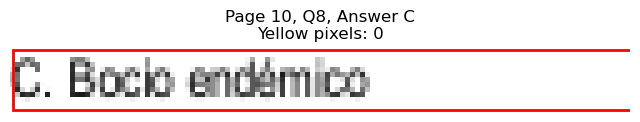

Page 10, Q8 - D: Detected box: x0=322.9, y0=639.5, x1=404.1, y1=651.6
Page 10, Q8, D: Yellow pixels: 704
Page 10, Q8, D: Total non-white pixels: 1040
Page 10, Q8, D: Yellow percentage: 67.7%


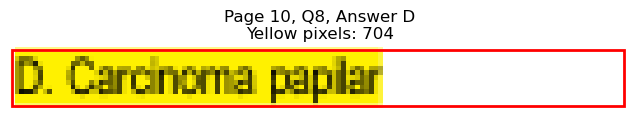

Page 10, Q8 - E: Detected box: x0=322.9, y0=651.5, x1=407.0, y1=663.6
Page 10, Q8, E: Yellow pixels: 79
Page 10, Q8, E: Total non-white pixels: 488
Page 10, Q8, E: Yellow percentage: 16.2%


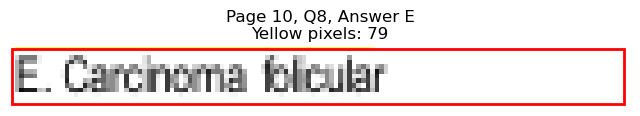


Page 10, Q8 - Selected Answer: D (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=82.6, y0=712.3, x1=229.7, y1=724.4
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 746
Page 10, Q9, A: Yellow percentage: 0.0%


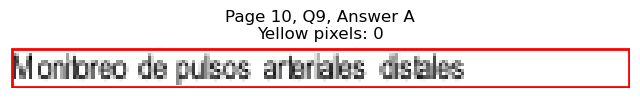

Page 10, Q9 - B: Detected box: x0=71.3, y0=724.3, x1=154.8, y1=736.4
Page 10, Q9, B: Yellow pixels: 652
Page 10, Q9, B: Total non-white pixels: 1066
Page 10, Q9, B: Yellow percentage: 61.2%


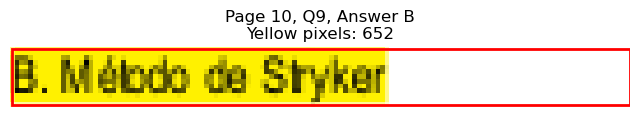

Page 10, Q9 - C: Detected box: x0=71.3, y0=736.4, x1=157.7, y1=748.4
Page 10, Q9, C: Yellow pixels: 1
Page 10, Q9, C: Total non-white pixels: 495
Page 10, Q9, C: Yellow percentage: 0.2%


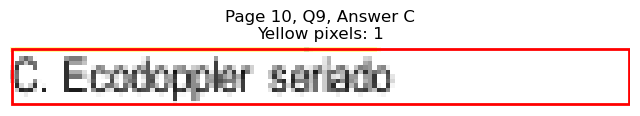

Page 10, Q9 - D: Detected box: x0=364.9, y0=712.3, x1=466.4, y1=724.4
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 491
Page 10, Q9, D: Yellow percentage: 0.0%


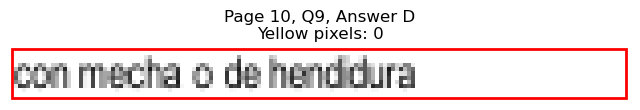

Page 10, Q9 - E: Detected box: x0=322.9, y0=724.3, x1=390.6, y1=736.4
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 340
Page 10, Q9, E: Yellow percentage: 0.0%


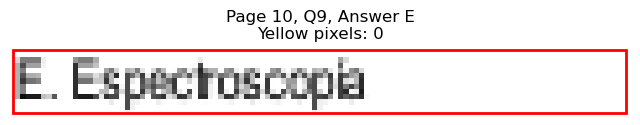


Page 10, Q9 - Selected Answer: B (based on yellow pixel count)





Page 11: Found 7 questions
Page 11, Q1 - A: Detected box: x0=71.3, y0=96.8, x1=79.7, y1=108.8
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 63
Page 11, Q1, A: Yellow percentage: 0.0%


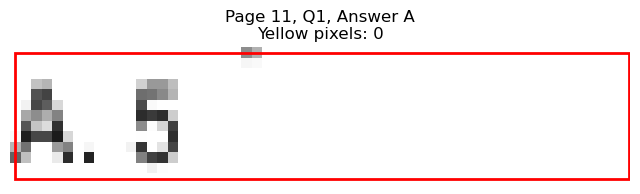

Page 11, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=93.2, y1=121.6
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 96
Page 11, Q1, B: Yellow percentage: 0.0%


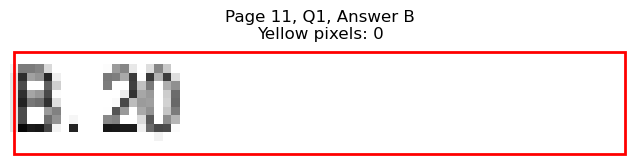

Page 11, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=94.0, y1=133.6
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 89
Page 11, Q1, C: Yellow percentage: 0.0%


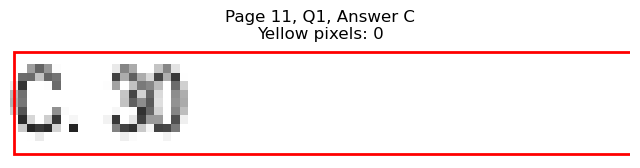

Page 11, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=345.5, y1=108.8
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 96
Page 11, Q1, D: Yellow percentage: 0.0%


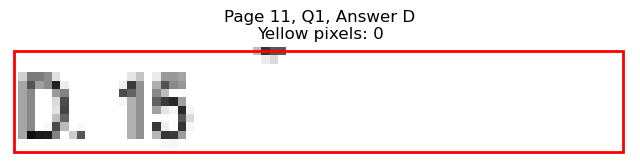

Page 11, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=344.8, y1=121.6
Page 11, Q1, E: Yellow pixels: 190
Page 11, Q1, E: Total non-white pixels: 273
Page 11, Q1, E: Yellow percentage: 69.6%


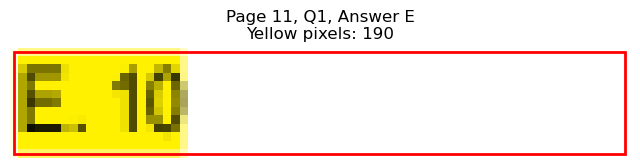


Page 11, Q1 - Selected Answer: E (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=139.7, y1=193.6
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 281
Page 11, Q2, A: Yellow percentage: 0.0%


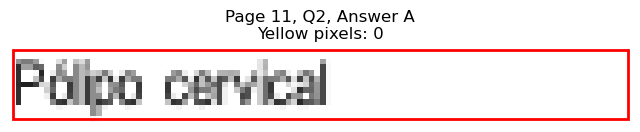

Page 11, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=153.3, y1=205.6
Page 11, Q2, B: Yellow pixels: 624
Page 11, Q2, B: Total non-white pixels: 1040
Page 11, Q2, B: Yellow percentage: 60.0%


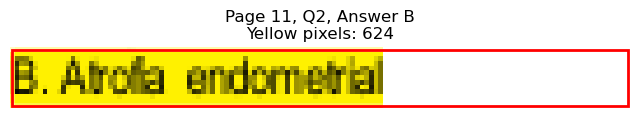

Page 11, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=172.0, y1=217.7
Page 11, Q2, C: Yellow pixels: 80
Page 11, Q2, C: Total non-white pixels: 584
Page 11, Q2, C: Yellow percentage: 13.7%


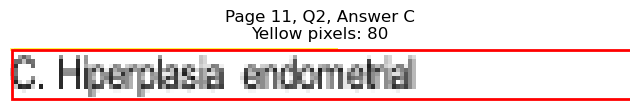

Page 11, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=400.3, y1=193.6
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 361
Page 11, Q2, D: Yellow percentage: 0.0%


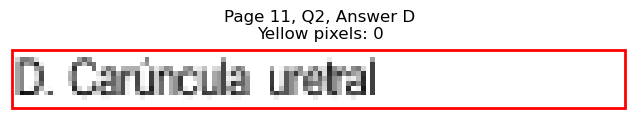

Page 11, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=407.8, y1=205.6
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 422
Page 11, Q2, E: Yellow percentage: 0.0%


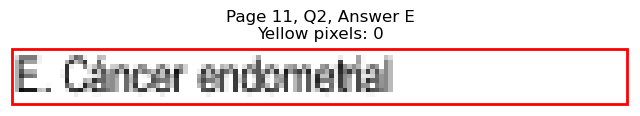


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=117.3, y1=253.7
Page 11, Q3, A: Yellow pixels: 239
Page 11, Q3, A: Total non-white pixels: 429
Page 11, Q3, A: Yellow percentage: 55.7%


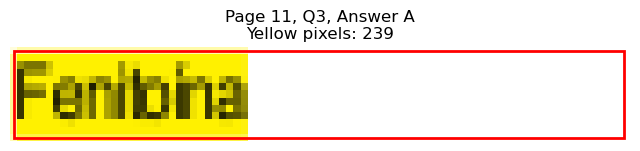

Page 11, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=127.7, y1=265.7
Page 11, Q3, B: Yellow pixels: 32
Page 11, Q3, B: Total non-white pixels: 332
Page 11, Q3, B: Yellow percentage: 9.6%


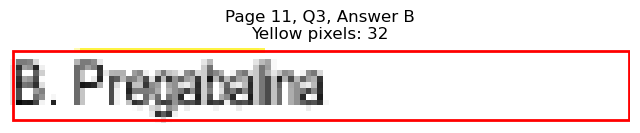

Page 11, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=130.8, y1=277.7
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 297
Page 11, Q3, C: Yellow percentage: 0.0%


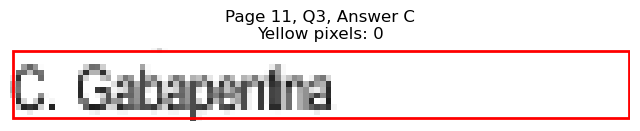

Page 11, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=381.5, y1=253.7
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 281
Page 11, Q3, D: Yellow percentage: 0.0%


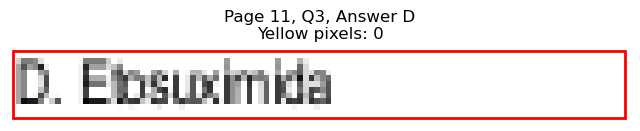

Page 11, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=375.5, y1=265.7
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 279
Page 11, Q3, E: Yellow percentage: 0.0%


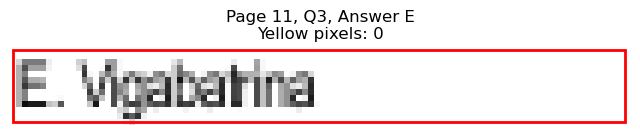


Page 11, Q3 - Selected Answer: A (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=174.2, y1=326.5
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 574
Page 11, Q4, A: Yellow percentage: 0.0%


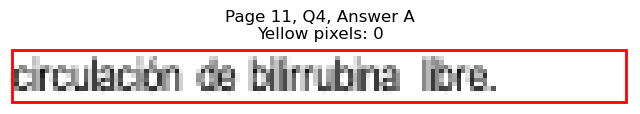

Page 11, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=149.5, y1=338.5
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 618
Page 11, Q4, B: Yellow percentage: 0.0%


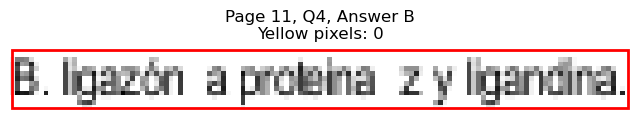

Page 11, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=163.8, y1=350.5
Page 11, Q4, C: Yellow pixels: 1313
Page 11, Q4, C: Total non-white pixels: 1859
Page 11, Q4, C: Yellow percentage: 70.6%


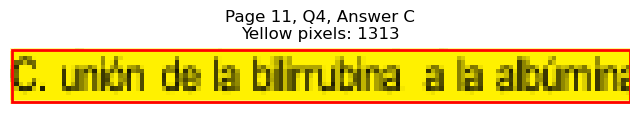

Page 11, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=419.0, y1=326.5
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 444
Page 11, Q4, D: Yellow percentage: 0.0%


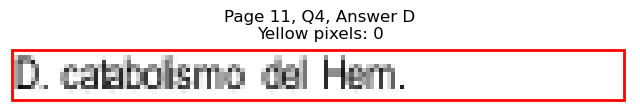

Page 11, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=443.8, y1=338.5
Page 11, Q4, E: Yellow pixels: 0
Page 11, Q4, E: Total non-white pixels: 859
Page 11, Q4, E: Yellow percentage: 0.0%


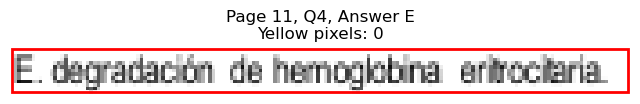


Page 11, Q4 - Selected Answer: C (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=121.0, y1=386.6
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 213
Page 11, Q5, A: Yellow percentage: 0.0%


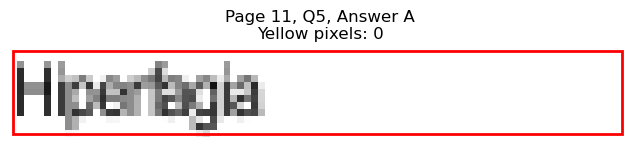

Page 11, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=118.0, y1=398.6
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 225
Page 11, Q5, B: Yellow percentage: 0.0%


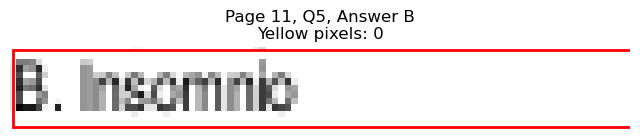

Page 11, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=136.0, y1=410.6
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 304
Page 11, Q5, C: Yellow percentage: 0.0%


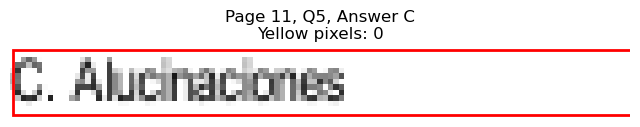

Page 11, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=373.3, y1=386.6
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 237
Page 11, Q5, D: Yellow percentage: 0.0%


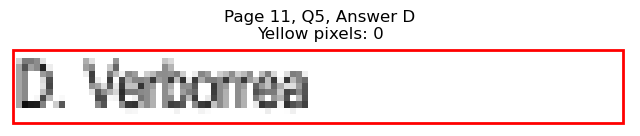

Page 11, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=374.1, y1=398.6
Page 11, Q5, E: Yellow pixels: 353
Page 11, Q5, E: Total non-white pixels: 650
Page 11, Q5, E: Yellow percentage: 54.3%


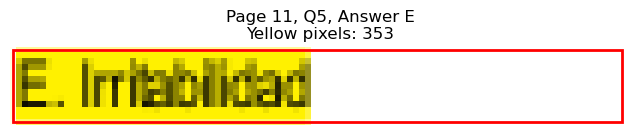


Page 11, Q5 - Selected Answer: E (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=185.5, y1=458.6
Page 11, Q6, A: Yellow pixels: 0
Page 11, Q6, A: Total non-white pixels: 505
Page 11, Q6, A: Yellow percentage: 0.0%


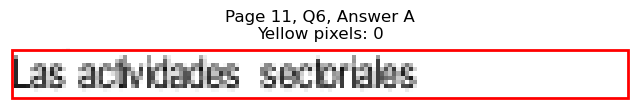

Page 11, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=200.5, y1=470.6
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 625
Page 11, Q6, B: Yellow percentage: 0.0%


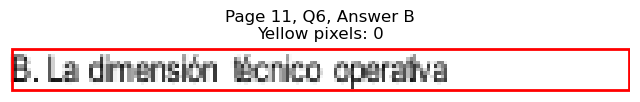

Page 11, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=216.2, y1=482.6
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 687
Page 11, Q6, C: Yellow percentage: 0.0%


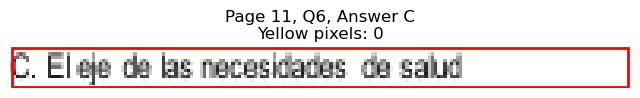

Page 11, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=413.9, y1=458.6
Page 11, Q6, D: Yellow pixels: 710
Page 11, Q6, D: Total non-white pixels: 1170
Page 11, Q6, D: Yellow percentage: 60.7%


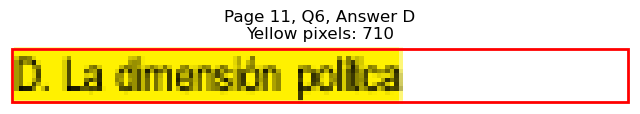

Page 11, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=445.2, y1=470.6
Page 11, Q6, E: Yellow pixels: 88
Page 11, Q6, E: Total non-white pixels: 652
Page 11, Q6, E: Yellow percentage: 13.5%


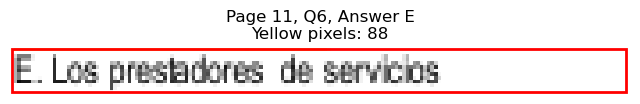


Page 11, Q6 - Selected Answer: D (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=82.6, y0=507.4, x1=118.8, y1=519.4
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 209
Page 11, Q7, A: Yellow percentage: 0.0%


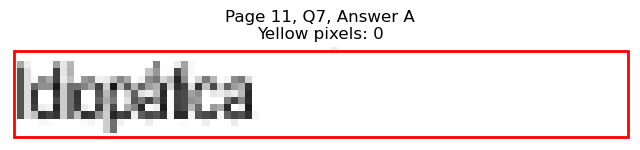

Page 11, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=140.5, y1=531.4
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 345
Page 11, Q7, B: Yellow percentage: 0.0%


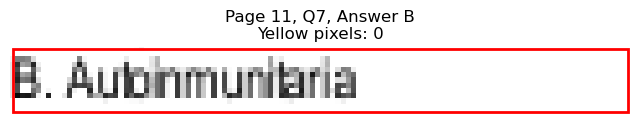

Page 11, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=121.0, y1=543.5
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 235
Page 11, Q7, C: Yellow percentage: 0.0%


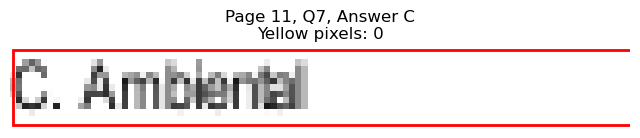

Page 11, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=383.1, y1=519.4
Page 11, Q7, D: Yellow pixels: 496
Page 11, Q7, D: Total non-white pixels: 767
Page 11, Q7, D: Yellow percentage: 64.7%


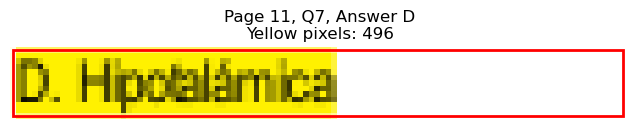

Page 11, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=375.5, y1=531.4
Page 11, Q7, E: Yellow pixels: 57
Page 11, Q7, E: Total non-white pixels: 334
Page 11, Q7, E: Yellow percentage: 17.1%


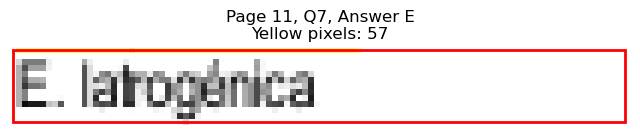


Page 11, Q7 - Selected Answer: D (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Recién nacido por cesárea, con 29 semanas de e...
1   En el tratamiento de diabetes mellitus tipo 2....
2   Pre-escolar de 3 años llega a emergencia por p...
3   ¿A qué edad en meses, el niño logra hacer una ...
4   Mujer de 50 años, obesa, hipertensa, con antec...
..                                                ...
95  ¿Cuál es el anticonvulsivante que actúa inhibi...
96  La bilirrubina se encuentra en varias formas e...
97  ¿Qué caracteriza al síndrome depresivo en adol...
98  En el Modelo de Atención Integral en Salud bas...
99  ¿Cuál es el tipo de amenorrea en una mujer con...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                           option_B  \
0                         Surfactante                         Corticoide   
1                        Sitagliptina                         Metformina   
2                      Neumonía viral                   Crup espasmódico   
3                                  24                                 15   
4            1 mg/Kg cada 24 horas SC           1 mg/Kg cada 12 horas EV   
..                                ...                                ...   
95                          Fenitoína                        Pregabalina   
96  circulación de bilirrubina libre.  ligazón a proteina z y ligandina.   
97                         Hiperfagia                           Insomnio   
98        Las actividades sectoriales     La dimensión técnico operativa   
99                         Idiopática                    Autoinmunitaria   

                                  option_C                  option_D  \
0                            Óxido nítrico                Vitamina K   
1                              Glimepirida              Pioglitazona   
2                               Neumotórax           Crisis asmática   
3                                       18                        12   
4                 1 mg/Kg cada 24 horas EV  1 mg/Kg cada 12 horas SC   
..                                     ...                       ...   
95                             Gabapentina               Etosuximida   
96  unión de la bilirrubina a la albúmina.      catabolismo del Hem.   
97                           Alucinaciones                 Verborrea   
98      El eje de las necesidades de salud     La dimensión política   
99                               Ambiental              Hipotalámica   

                                     option_E  
0                                Tetraciclina  
1                              Empagliflozina  
2                              Cuerpo extraño  
3                                          20  
4                    2 mg/Kg cada 12 horas EV  
..                                        ...  
95                                Vigabatrina  
96  degradación de hemoglobina eritrocitaria.  
97                              Irritabilidad  
98               Los prestadores de servicios  
99                                Iatrogénica  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               E
2               E
3               A
4               D
..            ...
95              A
96              C
97              E
98              D
99              D

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Recién nacido por cesárea, con 29 semanas de e...   
1   En el tratamiento de diabetes mellitus tipo 2....   
2   Pre-escolar de 3 años llega a emergencia por p...   
3   ¿A qué edad en meses, el niño logra hacer una ...   
4   Mujer de 50 años, obesa, hipertensa, con antec...   
..                                                ...   
95  ¿Cuál es el anticonvulsivante que actúa inhibi...   
96  La bilirrubina se encuentra en varias formas e...   
97  ¿Qué caracteriza al síndrome depresivo en adol...   
98  En el Modelo de Atención Integral en Salud bas...   
99  ¿Cuál es el tipo de amenorrea en una mujer con...   

                             option_A                           option_B  \
0                         Surfactante                         Corticoide   
1                        Sitagliptina                         Metformina   
2                      Neumonía viral                   Crup espasmódico   
3                                  24                                 15   
4            1 mg/Kg cada 24 horas SC           1 mg/Kg cada 12 horas EV   
..                                ...                                ...   
95                          Fenitoína                        Pregabalina   
96  circulación de bilirrubina libre.  ligazón a proteina z y ligandina.   
97                         Hiperfagia                           Insomnio   
98        Las actividades sectoriales     La dimensión técnico operativa   
99                         Idiopática                    Autoinmunitaria   

                                  option_C                  option_D  \
0                            Óxido nítrico                Vitamina K   
1                              Glimepirida              Pioglitazona   
2                               Neumotórax           Crisis asmática   
3                                       18                        12   
4                 1 mg/Kg cada 24 horas EV  1 mg/Kg cada 12 horas SC   
..                                     ...                       ...   
95                             Gabapentina               Etosuximida   
96  unión de la bilirrubina a la albúmina.      catabolismo del Hem.   
97                           Alucinaciones                 Verborrea   
98      El eje de las necesidades de salud     La dimensión política   
99                               Ambiental              Hipotalámica   

                                     option_E correct_answer  
0                                Tetraciclina              A  
1                              Empagliflozina              E  
2                              Cuerpo extraño              E  
3                                          20              A  
4                    2 mg/Kg cada 12 horas EV              D  
..                                        ...            ...  
95                                Vigabatrina              A  
96  degradación de hemoglobina eritrocitaria.              C  
97                              Irritabilidad              E  
98               Los prestadores de servicios              D  
99                                Iatrogénica              D  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/PRUEBA A.csv
